<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-data-and-parameters" data-toc-modified-id="Import-data-and-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data and parameters</a></span></li><li><span><a href="#System-initialization" data-toc-modified-id="System-initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>System initialization</a></span></li><li><span><a href="#Looping-Simulation" data-toc-modified-id="Looping-Simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Looping Simulation</a></span><ul class="toc-item"><li><span><a href="#Scenario-parameters" data-toc-modified-id="Scenario-parameters-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scenario parameters</a></span></li><li><span><a href="#Linear-ramp-version" data-toc-modified-id="Linear-ramp-version-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear ramp version</a></span></li><li><span><a href="#Sensitivity-version" data-toc-modified-id="Sensitivity-version-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Sensitivity version</a></span></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Save results</a></span></li></ul></li><li><span><a href="#Original-Simulation" data-toc-modified-id="Original-Simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Original Simulation</a></span><ul class="toc-item"><li><span><a href="#Scenario-parameters" data-toc-modified-id="Scenario-parameters-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Scenario parameters</a></span></li><li><span><a href="#Simulation-main" data-toc-modified-id="Simulation-main-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Simulation main</a></span></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Save results</a></span></li><li><span><a href="#Price-evolution" data-toc-modified-id="Price-evolution-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Price evolution</a></span></li><li><span><a href="#Supply-and-demand-evolution" data-toc-modified-id="Supply-and-demand-evolution-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Supply and demand evolution</a></span></li><li><span><a href="#Ore-grade-evolution" data-toc-modified-id="Ore-grade-evolution-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Ore grade evolution</a></span></li></ul></li><li><span><a href="#Validation" data-toc-modified-id="Validation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Validation</a></span><ul class="toc-item"><li><span><a href="#Prices" data-toc-modified-id="Prices-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Prices</a></span></li><li><span><a href="#Refineries" data-toc-modified-id="Refineries-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Refineries</a></span></li><li><span><a href="#Mining" data-toc-modified-id="Mining-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Mining</a></span></li></ul></li></ul></div>

# Import data and parameters

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
idx = pd.IndexSlice
import random 
from scipy import stats

from mine_simulation_tools import *
from refinery import *
from scrap_supply_tools import *
from demand_tools import *
from price_formation import *

import warnings
warnings.filterwarnings("ignore")

def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)
        
# from useful_functions import *
# init_plot2()

<AxesSubplot:xlabel='Year'>

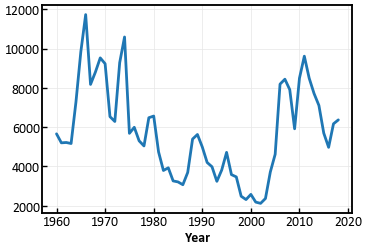

In [37]:
historical_price.LME.plot()

In [4]:
def import_data():
    ## High level parameters
    historical_prod=pd.read_excel('Data/Production data compile.xlsx', sheet_name='Selected', index_col=0)
    historical_price=pd.read_excel('Data/Price data compile.xlsx', sheet_name='Price', index_col=0) # All prices 2017 constant

    # Specific prod and mine data
    historical_mining_prod=historical_prod.loc[:, 'Total mining production']
    historical_lme_price=historical_price.loc[:, 'LME']
    historical_tcrc=historical_price.loc[:, 'Annual TCRC']
    historical_no2=historical_price.loc[:, 'No.2 ref']
    historical_sp2=historical_lme_price-historical_no2


    ## Primary supply data and patameters
    operating_mine_pool=pd.read_excel('Data/primary supply/Operating mine pool.xls', sheet_name='Sheet1', index_col=0)
    open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter.xlsx', sheet_name='max5', index_col=0)
    incentive_pool=pd.read_excel('Data/primary supply/Incentive mine pool.xls', sheet_name='Sheet1', index_col=0)
    pri_hyper_param=pd.read_excel('Data/primary supply/Hyperparameters.xlsx', sheet_name='Sheet1', index_col=0)


    ## Refinery parameters
    ref_hyper_param=pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='Parameters', index_col=0)
    conc_to_cathode_eff=ref_hyper_param.loc['conc to cathode eff', 'Value']
    scrap_to_cathode_eff=ref_hyper_param.loc['scrap to cathode eff', 'Value']


    ## Semis demand parameters
    gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
    volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
    intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
    elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
    sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix.xlsx', sheet_name='Sheet1', index_col=0)
    calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)

    # Adjust demand in 2018 to scale it back to ICSG
    intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
    .mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
    intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
    .mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
    demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))


    ## Scrap supply parameters
    use_sector_combined=pd.read_excel('Data/scrap supply/End use combined data.xlsx', sheet_name='Combined', index_col=0)
    sector_to_product=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='sector to product', index_col=0)
    product_to_waste=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to waste', index_col=0)
    product_life_and_eff=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product lifetime and efficiency', index_col=0)
    product_to_cathode_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to copper or alloy', index_col=0)
    recycle_efficiency=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='recycling efficiency', index_col=0)

    # Home scrap ratio
    home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
    home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Calibrated ratio']
    exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

    # Sector end use to product matrix 
    use_product_history=use_sector_combined.apply(lambda x: (x*sector_to_product).sum(axis=1),axis=1)
    # pd.DataFrame(np.matmul(use_sector_combined, sector_to_product.transpose()), 
    #                                  index=use_sector_combined.index, columns=sector_to_product.index)

    # Product to waste matrices
    product_to_waste_collectable=product_to_waste.iloc[:, :-2]
    product_to_waste_no_loss=product_to_waste_collectable.mul(1/product_to_waste_collectable.sum(axis=1), axis=0)

    # Product lifetime parameters and frequencies
    product_lifetime=product_life_and_eff.loc[:, 'Lifetime']
    product_lifetime_df=lifetime_df(product_lifetime)
    product_lifetime_freq_df=lifetime_freq_df(product_lifetime_df)

    # Recycling and fabrication efficiencies
    sort_eff=recycle_efficiency.iloc[:, 0]
    collect_rate=recycle_efficiency.iloc[:, 1]
    fab_eff=product_life_and_eff.loc[:, 'Fabrication efficiency']
    new_scrap_gen=1/fab_eff-1
    sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
    collect_rate_series=pd.DataFrame(np.array((list(collect_rate)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate.index)

    ## Price formation parameters
    price_formation_param=pd.read_excel('Data/price formation/Price formation.xlsx', sheet_name='Sheet1', index_col=0)
    cathode_sd_elas=price_formation_param.loc['Cathode SD elasticity', 'Value']
    conc_sd_elas=price_formation_param.loc['Concentrate SD elasticity', 'Value']
    cathode_sp2_elas=price_formation_param.loc['SP2 cathode elasticity', 'Value']
    sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']
    globals().update(locals())
import_data()
print('Done')

Done


In [3]:
ref_hyper_param

Value  \
Item                                 
pri cap                7470.609912   
pri CU                    0.860051   
pri CU TCRC elas          0.057419   
sec cap               15426.642911   
sec CU                    0.860051   
sec CU TCRC elas          0.152867   
sec ratio                 0.325000   
sec ratio TCRC elas      -0.197009   
sec ratio SP2 elas        0.315688   
conc to cathode eff       0.990000   
scrap to cathode eff      0.990000   

                                                            Description  
Item                                                                     
pri cap                                     Calculated primary capacity  
pri CU                2018 Capacity utilization rate of all refineri...  
pri CU TCRC elas                 Primary CU long run elasticity to TCRC  
sec cap                                   Calculated secondary capacity  
sec CU                2018 Capacity utilization rate of all refineri...  
sec CU TCRC elas               Secondary CU long run elasticity to TCRC  
sec ratio                Simulated sec ratio based on 2016 initial data  
sec ratio TCRC elas         Secondary ratio long run elasticity to TCRC  
sec ratio SP2 elas    Secondary ratio long run elasticity to No.2 sp...  
conc to cathode eff   Concentrate to cathode efficiency, global aver...  
scrap to cathode eff                   No.2 scrap to cathode efficiency

<IPython.core.display.Javascript object>


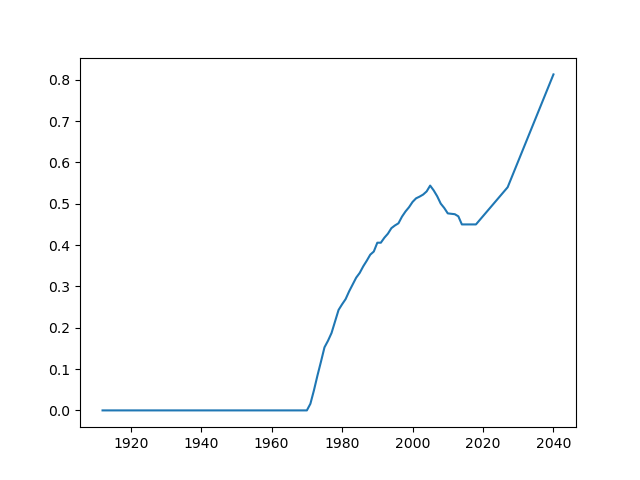

Stored 'home_scrap_ratio_series' (Series)


In [61]:
plt.figure()
plt.plot(np.arange(1912,2041),home_scrap_ratio_series)
# %store home_scrap_ratio_series
# home_scrap_ratio_series.loc[1971:2018]

# System initialization

In [6]:
def system_initialization():
    # Initialize simulation time
    history_start_time='19600101'
    simulation_start_time='20180101'
    simulation_end_time='20400101'
    simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
    history_time=pd.date_range(history_start_time, simulation_start_time, freq='AS')

    # Cathode price
    cathode_price_series=pd.Series(0, index=history_time)
    cathode_price_series.loc[:'20180101']=historical_lme_price.values

    # TCRC
    tcrc_series=pd.Series(0, index=history_time)
    tcrc_series.loc[:'20180101']=historical_tcrc.values

    # No.2 scrap spread
    sp2_series=pd.Series(0, index=history_time)
    sp2_series.loc[:'20180101']=historical_sp2.values

    # Initialize mining stats
    mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
    mine_pool_new_last=pd.DataFrame()
    mine_life_stats_panel_new_last=pd.DataFrame()
    total_mining_prod=pd.Series(0, index=simulation_time)
    irr_cutoff = 0.15

    # Initilize sxew ids
    sxew_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']==100
    sxew_id_operating=[i for i in sxew_id_operating_bool.index if sxew_id_operating_bool.loc[i]]
    sxew_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']==100
    sxew_id_new=[i for i in sxew_id_new_bool.index if sxew_id_new_bool.loc[i]]
    sxew_new=pd.Series(0, index=simulation_time)
    sxew_all=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
    sxew_all.loc['20170101']=historical_prod.loc[2017, 'SX-EW production']

    # Initialize refinery stats
    ref_stats=ref_stats_init(simulation_time, ref_hyper_param)

    # Initialize concentrate prod, add 2017
    conc_prod_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
    conc_prod_series.loc['20170101']=historical_prod.loc[2017, 'Concentrate production']

    # Initialize refined supply and demand
    ref_prod_series=pd.Series(0, index=simulation_time)
    ref_demand_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
    ref_demand_series.loc['20170101']=historical_prod.loc[2017, 'Refined usage']

    # Initialize end use by product stats
    use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
    use_product_all_life=pd.concat([use_product_history, use_product_future])

    # Initialize old scrap history
    product_eol_history=product_reach_eol(use_product_history, product_lifetime_freq_df)
    waste_from_old_history=product_eol_history.apply(lambda x: (x*product_to_waste_collectable.T).sum(axis=1), axis=1).mul(sort_eff).mul(collect_rate)
    # pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
    #                                      index=product_eol_history.index, 
    #                                      columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)

    waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
    waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

    # Initialize old scrap history
    waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
    for year_i in waste_from_new_history.index:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i=\
        simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_history.loc[year_i]=waste_from_new_year_i.values

    waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
    waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])

    waste_all_life=waste_from_old_all_life+waste_from_new_all_life

    # Initialize scrap demand
    direct_melt_scrap_demand=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
    refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
    total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                              'Refined scrap': refined_scrap_demand})

    # Initialize scrap supply shock
    scrap_shock_file=pd.read_excel('Other scenarios/China import ban/Simulation scenarios.xlsx', sheet_name='Sheet1', index_col=0)
    scrap_shock=scrap_shock_file.loc[:, 'Baseline']
    globals().update(locals())
system_initialization()    
print('Done')

Done


In [7]:
datetime(2020,1,1)
datetime(2020,1,1)
product_to_cathode_alloy
collect_rate
product_to_waste_collectable
sector_shape_matrix


<ipython-input-7-7e1091f08273>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datetime(2020,1,1)


Construction  Electrical  Industrial  Transport     Other
Copper      0.858727    0.945809    0.497488   0.708172  0.732119
Tube        0.002565    0.035018    0.054608   0.013347  0.007488
RBS         0.099818    0.019135    0.259361   0.034184  0.035564
PSS         0.000963    0.000038    0.024190   0.109451  0.149592
Wire        0.000800    0.000000    0.016104   0.006269  0.039172
Cast        0.037127    0.000000    0.148250   0.128577  0.036065

Copper   Alloyed
Plumbing               0.482413  0.517587
Building Plant         1.000000  0.000000
Architecture           0.516101  0.483899
Communications         1.000000  0.000000
Electrical Power       0.986363  0.013637
Telecommunications     0.999845  0.000155
Power Utility          0.928128  0.071872
Electrical Industrial  0.915842  0.084158
Non Elec. Industrial   0.088140  0.911860
Electrical Automotive  0.818238  0.181762
Non Elec. Automotive   0.506149  0.493851
Other Transport        0.541605  0.458395
Consumer               0.803458  0.196542
Cooling                0.985049  0.014951
Electronic             0.753166  0.246834
Diverse                0.507931  0.492069

# Looping Simulation

Some tuning parameters
1. **sec_coef**, describes to what extent secondary refinery capacity growth follows scrap supply
2. **open_parameter**, how many mines to assess for opening possibility
3. **sp2_sd_elas**, The elasticity of SP2 to scrap S-D. This is not estimated through regression, value just assigned

## Scenario parameters

Baseline

In [84]:
sensitivity_params.index('cathode_sd_elas')


1

0.0845
q 0 0.5 0.04225
q 0 0.6 0.02535
q 0 0.7 0.017745
q 0 0.8 0.014196
q 0 0.9 0.0127764
q 0 1.1 0.014054040000000002
q 0 1.2 0.016864848
q 0 1.3 0.0219243024
q 0 1.4 0.03069402336
q 0 1.5 0.04604103504
q 0 1.6 0.073665656064
q 0 1.7 0.12523161530879998
q 0 1.8 0.22541690755583996
q 0 1.9 0.42829212435609587
q 0 2 0.8565842487121917
-0.645598
q 1 0.5 -0.322799
q 1 0.6 -0.1936794
q 1 0.7 -0.13557558
q 1 0.8 -0.108460464
q 1 0.9 -0.0976144176
q 1 1.1 -0.10737585936
q 1 1.2 -0.128851031232
q 1 1.3 -0.16750634060160002
q 1 1.4 -0.23450887684224
q 1 1.5 -0.35176331526336
q 1 1.6 -0.562821304421376
q 1 1.7 -0.9567962175163391
q 1 1.8 -1.7222331915294105
q 1 1.9 -3.2722430639058797
q 1 2 -6.544486127811759
0.163601
q 2 0.5 0.0818005
q 2 0.6 0.0490803
q 2 0.7 0.03435621
q 2 0.8 0.027484968
q 2 0.9 0.0247364712
q 2 1.1 0.02721011832
q 2 1.2 0.032652141984
q 2 1.3 0.0424477845792
q 2 1.4 0.05942689841088
q 2 1.5 0.08914034761632
q 2 1.6 0.142624556186112
q 2 1.7 0.24246174551639038
q 2 1.8 0.4

Discount rate                            0.025946
q 9 1.4                                             Value
Item                                             
Capacity utilization constant            0.873000
Total cash margin constant ($/tonne)  2316.380000
Production elasticity                    0.243290
Discount rate                            0.036324
q 9 1.5                                             Value
Item                                             
Capacity utilization constant            0.873000
Total cash margin constant ($/tonne)  2316.380000
Production elasticity                    0.243290
Discount rate                            0.054486
q 9 1.6                                             Value
Item                                             
Capacity utilization constant            0.873000
Total cash margin constant ($/tonne)  2316.380000
Production elasticity                    0.243290
Discount rate                            0.087178
q 9 1.7                   

GDP                      NaN           NaN             0.69           0.11
q 12 1.8               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction            -0.0         0.020            -0.10           0.07
Electrical              -0.0         0.020            -0.05           0.07
Industrial              -0.0         0.020            -0.08           0.07
Transport               -0.0         0.020             0.00           0.07
Other                   -0.0         0.020            -0.12           0.07
China                    0.0         0.001            -0.17           0.07
EU                       0.0         0.001            -0.02           0.07
Japan                    0.0         0.001             0.02           0.07
NAM                      0.0         0.001            -0.16           0.07
ROW                      0.0         0.001            -0.07           0.07
GDP                      NaN           NaN             0.69           0.11
q 12 1.9        

q 15 1.8               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction            -0.0           0.0             -0.0            0.0
Electrical              -0.0           0.0             -0.0            0.0
Industrial              -0.0           0.0             -0.0            0.0
Transport               -0.0           0.0              0.0            0.0
Other                   -0.0           0.0             -0.0            0.0
China                    0.0           0.0             -0.0            0.0
EU                       0.0           0.0             -0.0            0.0
Japan                    0.0           0.0              0.0            0.0
NAM                      0.0           0.0             -0.0            0.0
ROW                      0.0           0.0             -0.0            0.0
GDP                      NaN           NaN              0.0            0.0
q 15 1.9               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Constru

240

In [96]:
vars()[combos[0][0]]
combo = combos[50]
muls = [0.5,0.7,0.9,1.1,1.3,1.5]

mul1 = muls[2]
mul2 = muls[3]
scenario = 'q '+str(sensitivity_params.index(combo[0])) + '+' + \
 str(sensitivity_params.index(combo[1]))+' '+str(mul1)+'+'+str(mul2)
scenario    

'q 2+8 0.9+1.1'

In [32]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sp2_sd_elas=0.0845

China import ban:

In [34]:
scrap_shock=scrap_shock_file.loc[:, 'Reuter all']

5sm:

In [4]:
scrap_shock.loc[2019:2023]=1e-7

C:\Users\Guest User\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


prs_50:

In [17]:
sort_eff_series.loc[2019:, :]=[0.9, 0.55, 0.55, 0.75, 0.75, 0.3]
collect_rate_series.loc[2019:, :]=[0.82, 0.49, 0.69, 0.97, 0.76, 0.74]

prs_10:

In [23]:
sort_eff_series.loc[2019:, :]=[0.9, 0.55, 0.55, 0.7, 0.75, 0.2]
collect_rate_series.loc[2019:, :]=[0.74, 0.14, 0.64, 0.94, 0.68, 0.77]

## Linear ramp version

In [1]:
collect_rate

NameError: name 'collect_rate' is not defined

In [5]:
# 'b '+str(num_yrs)+' yr '+str(opp_pct)+' %'
import warnings
warnings.filterwarnings("ignore")

In [190]:
scenarios = ['baseline_baseline_check']
scenarios = ['b 12 yr 100 %']
import_data()
system_initialization()
# collect_rate_df = pd.DataFrame([collect_rate.values,
#                                 [0.74,0.14,0.64,0.94,0.68,0.77],
#                                 [0.76,0.23,0.65,0.96,0.70,0.85],
#                                 [0.82,0.49,0.69,0.97,0.76,0.74],
#                                 [0.92,0.73,0.75,0.96,0.86,0.88]],
#                                index = [0,10,20,50,100], columns = collect_rate.index)

# sort_eff_df = pd.DataFrame([sort_eff.values,
#                            [0.9,0.55,0.55,0.70,0.75,0.20],
#                            [0.9,0.55,0.55,0.70,0.75,0.20],
#                            [0.9,0.55,0.55,0.75,0.75,0.3],
#                            [0.9,0.70,0.55,0.85,0.75,0.35]], 
#                            index = [0,10,20,50,100], columns = sort_eff.index)

collect_rate_df = pd.DataFrame([collect_rate.values,
                                [0.92,0.73,0.75,0.96,0.86,0.88]],
                               index = [0,100], columns = collect_rate.index)

sort_eff_df = pd.DataFrame([sort_eff.values,
                           [0.9,0.70,0.55,0.85,0.75,0.35]], 
                           index = [0,100], columns = sort_eff.index)
    
num_yrs, opp_pct = 5,50

# for num_yrs,opp_pct in [(0,0)]+[(a,b) for a in np.arange(1,21) for b in np.arange(5,101,5)]:
for num_yrs,opp_pct in [(12,100)]:
    import_data()
    system_initialization()
    
    if num_yrs != 0:
        sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
        collect_rate_series=pd.DataFrame(np.array((list(collect_rate)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate.index)

    # For supply shock scenarios
        if opp_pct not in collect_rate_df.index:
            collect_rate_df.loc[opp_pct,:] = np.nan
            collect_rate_df = collect_rate_df.sort_index().interpolate(method='index')
            sort_eff_df.loc[opp_pct,:] = np.nan
            sort_eff_df = sort_eff_df.sort_index().interpolate(method='index')
#     For linear ramp scenarios
        for waste_i in collect_rate.index:
            collect_rate_series.loc[2018:2018+num_yrs,waste_i] = \
                np.linspace(collect_rate.loc[waste_i],collect_rate_df.loc[opp_pct,waste_i],num_yrs+1)
            sort_eff_series.loc[2018:2018+num_yrs,waste_i] = \
                np.linspace(sort_eff.loc[waste_i],sort_eff_df.loc[opp_pct,waste_i],num_yrs+1)
            collect_rate_series.loc[2019+num_yrs:,waste_i]=collect_rate_df.loc[opp_pct,waste_i]
            sort_eff_series.loc[2019+num_yrs:,waste_i]=sort_eff_df.loc[opp_pct,waste_i]
#     # For spike scenarios
#         for waste_i in collect_rate.index:
#             collect_rate_series.loc[2019:2019+num_yrs-1,waste_i] = \
#                 collect_rate_df.loc[opp_pct,waste_i]
#             sort_eff_series.loc[2019:2019+num_yrs-1,waste_i] = \
#                 sort_eff_df.loc[opp_pct,waste_i]
    # For demand shock scenarios - set demand opportunity as 20%, compare with 15% of total scrap generated
#         pca = product_to_cathode_alloy.copy()
#         pca_o=product_to_cathode_alloy.copy()
#         pca.loc[:,'Copper']= product_to_cathode_alloy.loc[:,'Copper']*(1-opp_pct/100*0.2)
#         pca.loc[:,'Alloyed'] = 1-pca.loc[:,'Copper']

#         ssm = sector_shape_matrix.copy()
#         ssm_o=sector_shape_matrix.copy()
#         ssm.loc['Copper']= sector_shape_matrix.loc['Copper']*(1-opp_pct/100*0.2)
#         ssm.loc['Tube ':] = (1-ssm.loc['Copper'])*sector_shape_matrix.loc['Tube ':]/sector_shape_matrix.loc['Tube ':].sum()

            
    print(sort_eff_series)
    print(collect_rate_series)
    scenario = 'test '+str(num_yrs)+' yr '+str(opp_pct)+' %'
    
    for year_i in np.arange(2018, 2041):
        print(year_i, scenario)
        t=datetime(year_i, 1, 1)
        t_lag_1=datetime(year_i-1, 1, 1)
        t_lag_2=datetime(year_i-2, 1, 1)

        #### Scenario parameters ####
        sort_eff=sort_eff_series.loc[year_i]
        collect_rate=collect_rate_series.loc[year_i]

        # For demand shock scenarios
#         if num_yrs != 0:
#             if year_i-2018 <= num_yrs:
#                 product_to_cathode_alloy = pca_o+(pca-pca_o)*(year_i-2018)/num_yrs
#                 sector_shape_matrix = ssm_o+(ssm-ssm_o)*(year_i-2018)/num_yrs
#         print(product_to_cathode_alloy,sector_shape_matrix)
        
        #### Price formation ####
        if year_i > 2018:        
            ### Cathode price ###
            cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
            cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                              cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)

            ### TCRC ###
            conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
            tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                            conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)

            ### SP2 ###
            scrap_bal_l1=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
            cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
            sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                                          scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                          cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)

        # TCRC to cents per pound
        tcrc_cpp_series = tcrc_series.copy().div(22.0462)


        #### Production of operating mine ####
        for mine_id in operating_mine_pool.index:
            mine_data = operating_mine_pool.loc[mine_id]
            mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                             mine_life_stats_panel_operating, mine_data, 
                                                             cathode_price_series, tcrc_cpp_series, pri_hyper_param)
            mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

        # Total production statistics
        prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
        sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
        conc_operating=prod_operating-sxew_operating


        #### Production of new mines ####
        if year_i > 2018:
            # Read subsample size parameter and generate new incentive pool for year_i
            subsample_size=open_parameter.loc[year_i, 'Subsample size']
            mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, tcrc_cpp_series,
                                               pri_hyper_param, subsample_size, irr_cutoff=irr_cutoff)
            print('New mines opening this year: ', mine_pool_new_year_i.shape[0])

            # Initialize mine life panel data for incentive pool year_i
            mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)

            # Append new incentive pool at year_i
            mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
            mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)

            for mine_id in mine_pool_new.index:
                mine_data = mine_pool_new.loc[mine_id]
                mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                                 mine_life_stats_panel_new, mine_data, 
                                                                 cathode_price_series, tcrc_cpp_series, pri_hyper_param)
                mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values


            # Total production statistics
            prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
            sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
            conc_new=prod_new-sxew_new

            # Update incentive pool info
            mine_pool_new_last=mine_pool_new.copy()
            mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()


        #### Update total mining production ####
        if year_i == 2018:
            conc_new=pd.Series(0, index=simulation_time)
            prod_new=pd.Series(0, index=simulation_time)

        conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
        sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
        print('Total mining production: ', prod_operating.loc[t]+prod_new.loc[t])


        #### Demand for refined copper ####
        if year_i == 2018:
            pass
        else:
            intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, 
                                                         intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                         elas_sec_reg, method='sec and reg')
            intensity_prediction.loc[year_i, :]=intensity_next.values
            demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values

        # Demand by shape and refined copper demand
        demand_by_sector=demand_prediction.groupby(level=0, axis=1).sum()
        demand_by_shape=demand_by_sector.apply(lambda x: (x*sector_shape_matrix).sum(axis=1), axis=1)
#         pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
#                                      index=demand_by_sector.index, columns=sector_shape_matrix.index)
        ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']


        #### Production of refineries ####
        if year_i == 2018:
            pass
        else:
            ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                                ref_demand_series, waste_all_life.sum(axis=1),
                                                                ref_stats, ref_hyper_param, growth_lag=1)
            ref_stats.loc[t, :]=ref_stats_next

        total_ref_prod=ref_stats.loc[t, 'Primary production']+ref_stats.loc[t, 'Secondary production']+sxew_all.loc[t]
        ref_prod_series.loc[t]=total_ref_prod


        #### Generation of old scrap ####
        if year_i > 2018:
            # Calculate end use by sector and by product
            use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                              .loc[:, list(sector_to_product.columns)].loc[year_i, :]
            use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                         index=sector_to_product.index)
            use_product_all_life.loc[year_i]=use_product_year_i.values

            # Product reaching end of life and waste collected
            product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
            waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
            waste_from_old_future.loc[year_i]=waste_collected_year_i


        #### Generation of new scrap ####
        if year_i > 2018:
            home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
            exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
            waste_from_new_year_i=\
            simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff,
                                        home_scrap_ratio, exchange_scrap_ratio)
            waste_from_new_future.loc[year_i]=waste_from_new_year_i

            scrap_supply_shock_year_i=scrap_shock.loc[year_i]/6 # Distribute evenly to six waste streams

            # All scrap
            waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i+scrap_supply_shock_year_i


        print('Total scrap supply: ', waste_all_life.sum(axis=1).loc[year_i])


        #### Demand of scrap
        direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1).loc[year_i]
        refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
        total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap']=direct_melt_scrap_demand_year_i
        total_scrap_demand_all_life.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i


    ###################### SAVING RESULTS ##########################

    prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})

    mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
    mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
    mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
    mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
    mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

    conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                                  index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
    conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
    conc_demand_all.name='Concentrate demand'


    ref_prod_df_history=\
    historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
    ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
    ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
    ref_prod_df_future.columns=ref_prod_df_history.columns
    ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

    ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                                  index=pd.date_range('19500101', '20180101', freq='AS'))
    ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
    ref_demand_all.name='Refined demand'


    scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
    scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
    scrap_supply.name='Scrap production'

    scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
    scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')

    sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)

    mine_life_stats_all_tp=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1).transpose()

    prices_simulated.to_excel('Data/scenario results/John/05 Iterative/price '+scenario+'.xlsx')
    sd_simulated.to_excel('Data/scenario results/John/05 Iterative/S&D '+scenario+'.xlsx')
    mine_life_stats_all_tp.to_excel('Data/scenario results/John/05 Iterative/Mine level info/mine '+scenario+'.xlsx')

Waste type  C&D     MSW  WEEE     ELV   IEW    INEW
2018        0.9  0.5500  0.55  0.7000  0.75  0.2000
2019        0.9  0.5625  0.55  0.7125  0.75  0.2125
2020        0.9  0.5750  0.55  0.7250  0.75  0.2250
2021        0.9  0.5875  0.55  0.7375  0.75  0.2375
2022        0.9  0.6000  0.55  0.7500  0.75  0.2500
2023        0.9  0.6125  0.55  0.7625  0.75  0.2625
2024        0.9  0.6250  0.55  0.7750  0.75  0.2750
2025        0.9  0.6375  0.55  0.7875  0.75  0.2875
2026        0.9  0.6500  0.55  0.8000  0.75  0.3000
2027        0.9  0.6625  0.55  0.8125  0.75  0.3125
2028        0.9  0.6750  0.55  0.8250  0.75  0.3250
2029        0.9  0.6875  0.55  0.8375  0.75  0.3375
2030        0.9  0.7000  0.55  0.8500  0.75  0.3500
2031        0.9  0.7000  0.55  0.8500  0.75  0.3500
2032        0.9  0.7000  0.55  0.8500  0.75  0.3500
2033        0.9  0.7000  0.55  0.8500  0.75  0.3500
2034        0.9  0.7000  0.55  0.8500  0.75  0.3500
2035        0.9  0.7000  0.55  0.8500  0.75  0.3500
2036        

KeyboardInterrupt: 

<AxesSubplot:>

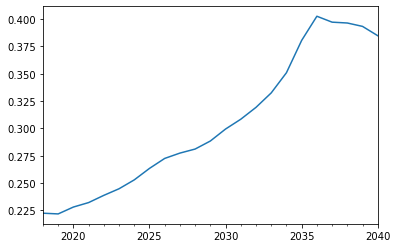

In [18]:
sd_simulated.loc[:,'Total'] = sd_simulated.loc[:,['SX-EW production','Primary refining production','Direct melt scrap','Secondary refining production']].sum(axis=1)
sd_simulated.loc[:,'Total scrap'] = sd_simulated.loc[:,['Direct melt scrap','Secondary refining production']].sum(axis=1)
waste_from_old = pd.concat([waste_from_old_history,waste_from_old_future])
waste_from_new = pd.concat([waste_from_new_history,waste_from_new_future])
waste_from_old.index = [datetime(i,1,1) for i in waste_from_old.index]
waste_from_new.index = [datetime(i,1,1) for i in waste_from_new.index]

sd_simulated.loc[:,'Total old scrap'] = sd_simulated.loc[:,['Direct melt scrap','Secondary refining production']].sum(axis=1)* (waste_from_old.sum(axis=1)/(waste_from_new.sum(axis=1)+waste_from_old.sum(axis=1)))
(sd_simulated.loc[:,'Total old scrap']/sd_simulated.loc[:,'Total']).loc['20180101':].plot()

## Sensitivity version

In [6]:
import_data()
system_initialization()
collect_rate_df = pd.DataFrame([collect_rate.values,
                                [0.92,0.73,0.75,0.96,0.86,0.88]],
                               index = [0,100], columns = collect_rate.index)

sort_eff_df = pd.DataFrame([sort_eff.values,
                           [0.9,0.70,0.55,0.85,0.75,0.35]], 
                           index = [0,100], columns = sort_eff.index)


num_yrs, opp_pct = 5,50#1,21 # 20,60 needs 7-11,15-16 too, remember to switch to linear, add 9y25
# 1y5, 5y50, and 9y25 all need rerun
    
sensitivity_params = ['sp2_sd_elas','cathode_sd_elas','conc_sd_elas','product_lifetime',
                      'open_parameter','irr_cutoff','fab_eff','pri_hyper_param-1','pri_hyper_param-2',
                      'ref_hyper_param-1','ref_hyper_param-2','elas_sec_reg-1','elas_sec_reg-2',
                      'elas_sec_reg-3','elas_sec_reg-4','ref_hyper_param-3','ref_hyper_param-4','ref_hyper_param-5']
combos = list()
for i in np.arange(1,2):
    init_combo = list()
#     for j in combinations(list(sensitivity_params[0:7])+list(sensitivity_params[11:]),i):
    for j in combinations(list(sensitivity_params[:]),i):
        init_combo += list([j])
    combos += init_combo
len(combos[0])
muls = [0.5,0.75,1.25,1.5]
muls = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
for combo in combos:
    combo1 = combo[0].split('-')[0]
    for mul1 in muls:
        if len(combo) == 1:
            muls2 = [0]
            if len(combo[0].split('-')) != 1:
                label1 = combo[0].split('-')[1]
            
        else:
            muls2 = muls
            combo2 = combo[1].split('-')[0]
            if len(combo[0].split('-')) != 1:
                label1 = combo[0].split('-')[1]
            if len(combo[1].split('-')) != 1:
                label2 = combo[1].split('-')[1]
            
        for mul2 in muls2:
            import_data()
            system_initialization()
            print(combo1,vars()[combo1])
    
            if combo1 == 'ref_hyper_param':
                if label1 == '1':
                    ref_hyper_param.loc[['pri CU TCRC elas','sec ratio TCRC elas'],'Value'] *= mul1
                elif label1 == '2':
                    ref_hyper_param.loc['sec ratio SP2 elas','Value'] *= mul1
                elif label1 == '3':
                    ref_hyper_param.loc['pri CU TCRC elas','Value'] *= mul1
                elif label1 == '4':
                    ref_hyper_param.loc['sec ratio TCRC elas','Value'] *= mul1
                elif label1 == '5':
                    ref_hyper_param.loc['sec CU TCRC elas','Value'] *= mul1
            elif combo1 == 'pri_hyper_param':
                if label1 == '1':
                    pri_hyper_param.loc['Production elasticity','Value'] *= mul1
                elif label1 == '2':
                    pri_hyper_param.loc['Discount rate','Value'] *= mul1
            elif combo1 == 'elas_sec_reg':
                if label1 == '1':
                    elas_sec_reg.loc[:,'Intercept mean'] *= mul1
                elif label1 == '2':
                    elas_sec_reg.loc[:,'Intercept SD'] *= mul1
                elif label1 == '3':
                    elas_sec_reg.loc[:,'Elasticity mean'] *= mul1
                elif label1 == '4':
                    elas_sec_reg.loc[:,'Elasticity SD'] *= mul1
            else:
                vars()[combo1] *= mul1
                if combo1 == 'open_parameter':
                    open_parameter = open_parameter.astype('int')
            
            if len(combo) == 1:
#                 scenario = 'q'+str(num_yrs)+'y'+str(opp_pct)+' '+str(sensitivity_params.index(combo[0]))+' '+str(round(mul1,2))
                scenario = 'base '+str(sensitivity_params.index(combo[0]))+' '+str(round(mul1,2))
            else:
                if combo2 == 'ref_hyper_param':
                    if label2 == '1':
                        ref_hyper_param.loc[['pri CU TCRC elas','sec ratio TCRC elas'],'Value'] *= mul2
                    elif label2 == '2':
                        ref_hyper_param.loc['sec ratio SP2 elas','Value'] *= mul2
                elif combo2 == 'pri_hyper_param':
                    if label2 == '1':
                        pri_hyper_param.loc['Production elasticity','Value'] *= mul2
                    elif label2 == '2':
                        pri_hyper_param.loc['Discount rate','Value'] *= mul2
                elif combo2 == 'elas_sec_reg':
                    if label2 == '1':
                        elas_sec_reg.loc[:,'Intercept mean'] *= mul2
                    elif label2 == '2':
                        elas_sec_reg.loc[:,'Intercept SD'] *= mul2
                    elif label2 == '3':
                        elas_sec_reg.loc[:,'Elasticity mean'] *= mul2
                    elif label2 == '4':
                        elas_sec_reg.loc[:,'Elasticity SD'] *= mul2
                else:
                    vars()[combo2] *= mul2
                    if combo2 == 'open_parameter':
                        open_parameter = open_parameter.astype('int')
#                 scenario = 'q'+str(num_yrs)+'y'+str(opp_pct)+' '+str(sensitivity_params.index(combo[0])) + '+' + \
#                     str(sensitivity_params.index(combo[1]))+' '+str(round(mul1,2))+'+'+str(round(mul2,2))
                scenario = 'base '+str(sensitivity_params.index(combo[0])) + '+' + \
                    str(sensitivity_params.index(combo[1]))+' '+str(round(mul1,2))+'+'+str(round(mul2,2))
            print('new:\n',vars()[combo1])
        #### End sensitivity multiplication
            if num_yrs != 0:
                sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
                collect_rate_series=pd.DataFrame(np.array((list(collect_rate)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=collect_rate.index)

#             # For supply shock scenarios
#                 if opp_pct not in collect_rate_df.index:
#                     collect_rate_df.loc[opp_pct,:] = np.nan
#                     collect_rate_df = collect_rate_df.sort_index().interpolate(method='index')
#                     sort_eff_df.loc[opp_pct,:] = np.nan
#                     sort_eff_df = sort_eff_df.sort_index().interpolate(method='index')
#         #     For linear ramp scenarios
#                 for waste_i in collect_rate.index:
#                     collect_rate_series.loc[2018:2018+num_yrs,waste_i] = \
#                         np.linspace(collect_rate.loc[waste_i],collect_rate_df.loc[opp_pct,waste_i],num_yrs+1)
#                     sort_eff_series.loc[2018:2018+num_yrs,waste_i] = \
#                         np.linspace(sort_eff.loc[waste_i],sort_eff_df.loc[opp_pct,waste_i],num_yrs+1)
#                     collect_rate_series.loc[2019+num_yrs:,waste_i]=collect_rate_df.loc[opp_pct,waste_i]
#                     sort_eff_series.loc[2019+num_yrs:,waste_i]=sort_eff_df.loc[opp_pct,waste_i]
        #     # For spike scenarios
#                 for waste_i in collect_rate.index:
#                     collect_rate_series.loc[2019:2019+num_yrs-1,waste_i] = \
#                         collect_rate_df.loc[opp_pct,waste_i]
#                     sort_eff_series.loc[2019:2019+num_yrs-1,waste_i] = \
#                         sort_eff_df.loc[opp_pct,waste_i]
            # For demand shock scenarios - set demand opportunity as 20%, compare with 15% of total scrap generated
        #         pca = product_to_cathode_alloy.copy()
        #         pca_o=product_to_cathode_alloy.copy()
        #         pca.loc[:,'Copper']= product_to_cathode_alloy.loc[:,'Copper']*(1-opp_pct/100*0.2)
        #         pca.loc[:,'Alloyed'] = 1-pca.loc[:,'Copper']

        #         ssm = sector_shape_matrix.copy()
        #         ssm_o=sector_shape_matrix.copy()
        #         ssm.loc['Copper']= sector_shape_matrix.loc['Copper']*(1-opp_pct/100*0.2)
        #         ssm.loc['Tube ':] = (1-ssm.loc['Copper'])*sector_shape_matrix.loc['Tube ':]/sector_shape_matrix.loc['Tube ':].sum()


            print(sort_eff_series)
            print(collect_rate_series)

            for year_i in np.arange(2018, 2041):
                print(year_i, scenario)
                t=datetime(year_i, 1, 1)
                t_lag_1=datetime(year_i-1, 1, 1)
                t_lag_2=datetime(year_i-2, 1, 1)

                #### Scenario parameters ####
                sort_eff=sort_eff_series.loc[year_i]
                collect_rate=collect_rate_series.loc[year_i]

                # For demand shock scenarios
        #         if num_yrs != 0:
        #             if year_i-2018 <= num_yrs:
        #                 product_to_cathode_alloy = pca_o+(pca-pca_o)*(year_i-2018)/num_yrs
        #                 sector_shape_matrix = ssm_o+(ssm-ssm_o)*(year_i-2018)/num_yrs
        #         print(product_to_cathode_alloy,sector_shape_matrix)

                #### Price formation ####
                if year_i > 2018:        
                    ### Cathode price ###
                    cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
                    cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                                      cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)

                    ### TCRC ###
                    conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
                    tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                                    conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)

                    ### SP2 ###
                    scrap_bal_l1=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
                    cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
                    sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                                                  scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                                  cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)

                # TCRC to cents per pound
                tcrc_cpp_series = tcrc_series.copy().div(22.0462)


                #### Production of operating mine ####
                for mine_id in operating_mine_pool.index:
                    mine_data = operating_mine_pool.loc[mine_id]
                    mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                                     mine_life_stats_panel_operating, mine_data, 
                                                                     cathode_price_series, tcrc_cpp_series, pri_hyper_param)
                    mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

                # Total production statistics
                prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
                sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
                conc_operating=prod_operating-sxew_operating


                #### Production of new mines ####
                if year_i > 2018:
                    # Read subsample size parameter and generate new incentive pool for year_i
                    subsample_size=open_parameter.loc[year_i, 'Subsample size']
                    mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, tcrc_cpp_series,
                                                       pri_hyper_param, subsample_size, irr_cutoff=irr_cutoff)
                    print('New mines opening this year: ', mine_pool_new_year_i.shape[0])

                    # Initialize mine life panel data for incentive pool year_i
                    mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)

                    # Append new incentive pool at year_i
                    mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
                    mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)

                    for mine_id in mine_pool_new.index:
                        mine_data = mine_pool_new.loc[mine_id]
                        mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                                         mine_life_stats_panel_new, mine_data, 
                                                                         cathode_price_series, tcrc_cpp_series, pri_hyper_param)
                        mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values


                    # Total production statistics
                    prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
                    sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
                    conc_new=prod_new-sxew_new

                    # Update incentive pool info
                    mine_pool_new_last=mine_pool_new.copy()
                    mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()


                #### Update total mining production ####
                if year_i == 2018:
                    conc_new=pd.Series(0, index=simulation_time)
                    prod_new=pd.Series(0, index=simulation_time)

                conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
                sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
                print('Total mining production: ', prod_operating.loc[t]+prod_new.loc[t])


                #### Demand for refined copper ####
                if year_i == 2018:
                    pass
                else:
                    intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, 
                                                                 intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                                 elas_sec_reg, method='sec and reg')
                    intensity_prediction.loc[year_i, :]=intensity_next.values
                    demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values

                # Demand by shape and refined copper demand
                demand_by_sector=demand_prediction.groupby(level=0, axis=1).sum()
                demand_by_shape=demand_by_sector.apply(lambda x: (x*sector_shape_matrix).sum(axis=1), axis=1)
        #         pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
        #                                      index=demand_by_sector.index, columns=sector_shape_matrix.index)
                ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']


                #### Production of refineries ####
                if year_i == 2018:
                    pass
                else:
                    ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                                        ref_demand_series, waste_all_life.sum(axis=1),
                                                                        ref_stats, ref_hyper_param, growth_lag=1)
                    ref_stats.loc[t, :]=ref_stats_next

                total_ref_prod=ref_stats.loc[t, 'Primary production']+ref_stats.loc[t, 'Secondary production']+sxew_all.loc[t]
                ref_prod_series.loc[t]=total_ref_prod


                #### Generation of old scrap ####
                if year_i > 2018:
                    # Calculate end use by sector and by product
                    use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                                      .loc[:, list(sector_to_product.columns)].loc[year_i, :]
                    use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                                 index=sector_to_product.index)
                    use_product_all_life.loc[year_i]=use_product_year_i.values

                    # Product reaching end of life and waste collected
                    product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
                    waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
                    waste_from_old_future.loc[year_i]=waste_collected_year_i


                #### Generation of new scrap ####
                if year_i > 2018:
                    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
                    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
                    waste_from_new_year_i=\
                    simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff,
                                                home_scrap_ratio, exchange_scrap_ratio)
                    waste_from_new_future.loc[year_i]=waste_from_new_year_i

                    scrap_supply_shock_year_i=scrap_shock.loc[year_i]/6 # Distribute evenly to six waste streams

                    # All scrap
                    waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i+scrap_supply_shock_year_i


                print('Total scrap supply: ', waste_all_life.sum(axis=1).loc[year_i])


                #### Demand of scrap
                direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1).loc[year_i]
                refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
                total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap']=direct_melt_scrap_demand_year_i
                total_scrap_demand_all_life.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i


            ###################### SAVING RESULTS ##########################

            prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})

            mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
            mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
            mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
            mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
            mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

            conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                                          index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
            conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
            conc_demand_all.name='Concentrate demand'


            ref_prod_df_history=\
            historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
            ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
            ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
            ref_prod_df_future.columns=ref_prod_df_history.columns
            ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

            ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                                          index=pd.date_range('19500101', '20180101', freq='AS'))
            ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
            ref_demand_all.name='Refined demand'


            scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
            scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
            scrap_supply.name='Scrap production'

            scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
            scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')

            sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)

            mine_life_stats_all_tp=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1).transpose()

            prices_simulated.to_excel('Data/scenario results/John/05 Iterative/price '+scenario+'.xlsx')
            sd_simulated.to_excel('Data/scenario results/John/05 Iterative/S&D '+scenario+'.xlsx')
            mine_life_stats_all_tp.to_excel('Data/scenario results/John/05 Iterative/Mine level info/mine '+scenario+'.xlsx')

sp2_sd_elas 0.0845
new:
 0.04225
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55  0.7  0.75   0.2
2037        0.9  0.55  0.55  0.7  0.75   0.2
2038        0.9  0.55 

Total mining production:  21608.77300242887
Total scrap supply:  12134.721436894202
2024 base 0 0.6
New mines opening this year:  34
Total mining production:  21944.402103626322
Total scrap supply:  12397.041995334017
2025 base 0 0.6
New mines opening this year:  45
Total mining production:  22307.266666938835
Total scrap supply:  12657.42735197452
2026 base 0 0.6
New mines opening this year:  22
Total mining production:  22911.353528736014
Total scrap supply:  12914.259734898056
2027 base 0 0.6
New mines opening this year:  50
Total mining production:  23226.063834490124
Total scrap supply:  13163.012652264157
2028 base 0 0.6
New mines opening this year:  52
Total mining production:  23496.89551021957
Total scrap supply:  13324.833464923287
2029 base 0 0.6
New mines opening this year:  38
Total mining production:  23505.655541356547
Total scrap supply:  13488.59358652872
2030 base 0 0.6
New mines opening this year:  38
Total mining production:  23521.430942359657
Total scrap supply:  

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 0 0.8
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 0 0.8
New mines opening this year:  0
Total mining production:  21295.663471097458
Total scrap supply:  11390.666763011628
2021 base 0 0.8
New mines opening this year:  49
Total mining production:  21248.746049201087
Total scrap supply:  11622.501126922692
2022 base 0 0.8
New mines opening this year:  15
Total mining production:  21690.439904757055
Total scrap supply:  11875.807387175048
2023 base 0 0.8
New mines opening this year:  57
Total mining production:  21613.662732146924
Total scrap supply:  12134.459444347125
2024 base 0 0.8
New mines opening this year:  34
Total mining production:  21957.045849015743
Total scrap supply:  12396.461881684989
2025 base 0 0.8
New mines opening this year:  45
Total mining production:  22318.865702548406
Total scrap suppl

Total mining production:  26280.635333243248
Total scrap supply:  15143.114469922542
sp2_sd_elas 0.0845
new:
 0.0845
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55 

New mines opening this year:  57
Total mining production:  21619.291033712718
Total scrap supply:  12134.0697305521
2024 base 0 1.1
New mines opening this year:  34
Total mining production:  21977.781117472805
Total scrap supply:  12395.616986327539
2025 base 0 1.1
New mines opening this year:  45
Total mining production:  22356.692215242165
Total scrap supply:  12655.282990695781
2026 base 0 1.1
New mines opening this year:  22
Total mining production:  22941.159051475202
Total scrap supply:  12911.787949080319
2027 base 0 1.1
New mines opening this year:  50
Total mining production:  23261.319907867106
Total scrap supply:  13160.907217362084
2028 base 0 1.1
New mines opening this year:  52
Total mining production:  23523.568088387034
Total scrap supply:  13323.65684225964
2029 base 0 1.1
New mines opening this year:  38
Total mining production:  23509.06088058833
Total scrap supply:  13488.384185169834
2030 base 0 1.1
New mines opening this year:  39
Total mining production:  23557.4

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 0 1.3
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 0 1.3
New mines opening this year:  0
Total mining production:  21296.040700915728
Total scrap supply:  11390.666763011628
2021 base 0 1.3
New mines opening this year:  49
Total mining production:  21251.041430639525
Total scrap supply:  11622.501126922692
2022 base 0 1.3
New mines opening this year:  15
Total mining production:  21696.472602250575
Total scrap supply:  11875.652379545767
2023 base 0 1.3
New mines opening this year:  57
Total mining production:  21627.638730091974
Total scrap supply:  12133.812188994443
2024 base 0 1.3
New mines opening this year:  34
Total mining production:  22005.70066572489
Total scrap supply:  12395.07091331241
2025 base 0 1.3
New mines opening this year:  45
Total mining production:  22390.32376418457
Total scrap supply: 

Total mining production:  26262.341197331974
Total scrap supply:  15141.46309339266
sp2_sd_elas 0.0845
new:
 0.12675
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55 

Total scrap supply:  11875.558785445073
2023 base 0 1.6
New mines opening this year:  57
Total mining production:  21632.78377966626
Total scrap supply:  12133.429423857144
2024 base 0 1.6
New mines opening this year:  34
Total mining production:  22013.9185309504
Total scrap supply:  12394.277961414982
2025 base 0 1.6
New mines opening this year:  45
Total mining production:  22403.771881712233
Total scrap supply:  12653.376867558545
2026 base 0 1.6
New mines opening this year:  22
Total mining production:  22976.114668604965
Total scrap supply:  12909.728159959868
2027 base 0 1.6
New mines opening this year:  50
Total mining production:  23264.025516038004
Total scrap supply:  13159.351412203556
2028 base 0 1.6
New mines opening this year:  53
Total mining production:  23497.416683062962
Total scrap supply:  13323.114262172663
2029 base 0 1.6
New mines opening this year:  40
Total mining production:  23536.80745495957
Total scrap supply:  13488.343879984277
2030 base 0 1.6
New mines 

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 0 1.8
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 0 1.8
New mines opening this year:  0
Total mining production:  21296.419529589057
Total scrap supply:  11390.666763011628
2021 base 0 1.8
New mines opening this year:  49
Total mining production:  21253.251876117858
Total scrap supply:  11622.501126922692
2022 base 0 1.8
New mines opening this year:  15
Total mining production:  21702.341769354054
Total scrap supply:  11875.496141104299
2023 base 0 1.8
New mines opening this year:  57
Total mining production:  21636.078691315153
Total scrap supply:  12133.176697523699
2024 base 0 1.8
New mines opening this year:  35
Total mining production:  22019.851280655
Total scrap supply:  12393.766915637463
2025 base 0 1.8
New mines opening this year:  45
Total mining production:  22411.624736682294
Total scrap supply: 

Total mining production:  26110.64293940712
Total scrap supply:  15134.95205638465
sp2_sd_elas 0.0845
new:
 0.169
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55  0.

New mines opening this year:  57
Total mining production:  21553.109362617604
Total scrap supply:  12130.234563242679
2024 base 1 0.5
New mines opening this year:  34
Total mining production:  21983.827513002077
Total scrap supply:  12391.035285976865
2025 base 1 0.5
New mines opening this year:  45
Total mining production:  22367.544266776218
Total scrap supply:  12652.005065696443
2026 base 1 0.5
New mines opening this year:  22
Total mining production:  22879.96559245934
Total scrap supply:  12911.569417189257
2027 base 1 0.5
New mines opening this year:  50
Total mining production:  23093.436854284028
Total scrap supply:  13166.49261793261
2028 base 1 0.5
New mines opening this year:  53
Total mining production:  23323.226792812267
Total scrap supply:  13333.500710578184
2029 base 1 0.5
New mines opening this year:  38
Total mining production:  23423.976551986496
Total scrap supply:  13497.08112732925
2030 base 1 0.5
New mines opening this year:  37
Total mining production:  23474.

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 1 0.7
New mines opening this year:  149
Total mining production:  20294.25841566275
Total scrap supply:  11178.567596692528
2020 base 1 0.7
New mines opening this year:  0
Total mining production:  21220.3718665206
Total scrap supply:  11392.952011408343
2021 base 1 0.7
New mines opening this year:  49
Total mining production:  21199.083079416196
Total scrap supply:  11624.353192968858
2022 base 1 0.7
New mines opening this year:  15
Total mining production:  21661.78082455082
Total scrap supply:  11873.618432039017
2023 base 1 0.7
New mines opening this year:  57
Total mining production:  21592.379996356918
Total scrap supply:  12129.6377685103
2024 base 1 0.7
New mines opening this year:  34
Total mining production:  22006.179395899162
Total scrap supply:  12390.834527716135
2025 base 1 0.7
New mines opening this year:  45
Total mining production:  22373.430579224714
Total scrap supply:  12

Total mining production:  26305.53430128871
Total scrap supply:  15151.409423191506
cathode_sd_elas -0.645598
new:
 -0.5810382000000001
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036     

Total scrap supply:  11875.74553056318
2023 base 1 1
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 1 1
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 1 1
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.693911118542
2026 base 1 1
New mines opening this year:  22
Total mining production:  22939.336970231536
Total scrap supply:  12912.268411744884
2027 base 1 1
New mines opening this year:  50
Total mining production:  23237.54695102579
Total scrap supply:  13161.387879596172
2028 base 1 1
New mines opening this year:  52
Total mining production:  23506.167331953904
Total scrap supply:  13324.088991137065
2029 base 1 1
New mines opening this year:  38
Total mining production:  23515.965755683115
Total scrap supply:  13488.473978496615
2030 base 1 1
New mines opening this yea

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 1 1.2
New mines opening this year:  149
Total mining production:  20362.379713778264
Total scrap supply:  11178.567596692528
2020 base 1 1.2
New mines opening this year:  0
Total mining production:  21295.215627027785
Total scrap supply:  11389.152997460249
2021 base 1 1.2
New mines opening this year:  49
Total mining production:  21287.253764864636
Total scrap supply:  11620.960055688472
2022 base 1 1.2
New mines opening this year:  16
Total mining production:  21758.621828780793
Total scrap supply:  11876.141952654873
2023 base 1 1.2
New mines opening this year:  57
Total mining production:  21669.019019909858
Total scrap supply:  12136.342844627992
2024 base 1 1.2
New mines opening this year:  35
Total mining production:  21968.56646883097
Total scrap supply:  12400.158272177645
2025 base 1 1.2
New mines opening this year:  45
Total mining production:  22316.103343924013
Total scrap supply

New mines opening this year:  44
Total mining production:  25886.564246209895
Total scrap supply:  15114.167328467045
cathode_sd_elas -0.645598
new:
 -0.9038371999999999
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.5

Total mining production:  21756.11431165111
Total scrap supply:  11877.172104742387
2023 base 1 1.5
New mines opening this year:  57
Total mining production:  21735.244642661106
Total scrap supply:  12139.282873768316
2024 base 1 1.5
New mines opening this year:  35
Total mining production:  22006.06844581497
Total scrap supply:  12403.13911559086
2025 base 1 1.5
New mines opening this year:  45
Total mining production:  22307.077349394753
Total scrap supply:  12663.600862340309
2026 base 1 1.5
New mines opening this year:  22
Total mining production:  23026.11689295679
Total scrap supply:  12917.748137727818
2027 base 1 1.5
New mines opening this year:  50
Total mining production:  23365.54724091028
Total scrap supply:  13158.342210742157
2028 base 1 1.5
New mines opening this year:  50
Total mining production:  23565.915534203526
Total scrap supply:  13314.576331321847
2029 base 1 1.5
New mines opening this year:  38
Total mining production:  23540.564895519936
Total scrap supply:  1

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 1 1.7
New mines opening this year:  149
Total mining production:  20385.88378174867
Total scrap supply:  11178.567596692528
2020 base 1 1.7
New mines opening this year:  0
Total mining production:  21292.345099899772
Total scrap supply:  11385.402110919154
2021 base 1 1.7
New mines opening this year:  49
Total mining production:  21270.320740044972
Total scrap supply:  11617.206442841272
2022 base 1 1.7
New mines opening this year:  16
Total mining production:  21740.19448369208
Total scrap supply:  11878.14355430045
2023 base 1 1.7
New mines opening this year:  57
Total mining production:  21736.349574899636
Total scrap supply:  12141.76889305212
2024 base 1 1.7
New mines opening this year:  36
Total mining production:  22016.586060153568
Total scrap supply:  12404.945930585825
2025 base 1 1.7
New mines opening this year:  43
Total mining production:  22300.450077052665
Total scrap supply:  

Total mining production:  25508.980243144608
Total scrap supply:  15170.402971210735
cathode_sd_elas -0.645598
new:
 -1.2266362
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  

Total scrap supply:  11882.200588916648
2023 base 1 2
New mines opening this year:  57
Total mining production:  21771.94839295693
Total scrap supply:  12150.553761527875
2024 base 1 2
New mines opening this year:  35
Total mining production:  22058.217885027967
Total scrap supply:  12412.886772205336
2025 base 1 2
New mines opening this year:  43
Total mining production:  22321.805456353683
Total scrap supply:  12665.840823594524
2026 base 1 2
New mines opening this year:  21
Total mining production:  23032.61561486996
Total scrap supply:  12913.30879670806
2027 base 1 2
New mines opening this year:  49
Total mining production:  23413.301586146827
Total scrap supply:  13148.738434555435
2028 base 1 2
New mines opening this year:  50
Total mining production:  23552.91961223069
Total scrap supply:  13304.124945858153
2029 base 1 2
New mines opening this year:  38
Total mining production:  23245.899019573957
Total scrap supply:  13479.194264195636
2030 base 1 2
New mines opening this yea

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 2 0.6
New mines opening this year:  149
Total mining production:  20361.328320361645
Total scrap supply:  11178.567596692528
2020 base 2 0.6
New mines opening this year:  0
Total mining production:  21330.523765461217
Total scrap supply:  11390.666763011628
2021 base 2 0.6
New mines opening this year:  49
Total mining production:  21278.706903052214
Total scrap supply:  11618.508225916974
2022 base 2 0.6
New mines opening this year:  15
Total mining production:  21734.340875160444
Total scrap supply:  11868.436008906301
2023 base 2 0.6
New mines opening this year:  57
Total mining production:  21653.347230734973
Total scrap supply:  12126.285245079742
2024 base 2 0.6
New mines opening this year:  36
Total mining production:  22041.5204000416
Total scrap supply:  12386.99076057089
2025 base 2 0.6
New mines opening this year:  45
Total mining production:  22429.225892294104
Total scrap supply: 

New mines opening this year:  34
Total mining production:  26465.083647474374
Total scrap supply:  15148.7328204506
conc_sd_elas 0.163601
new:
 0.1308808
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.

Total mining production:  21700.006415163476
Total scrap supply:  11874.2060705778
2023 base 2 0.9
New mines opening this year:  57
Total mining production:  21622.8657421892
Total scrap supply:  12132.807188810442
2024 base 2 0.9
New mines opening this year:  35
Total mining production:  21980.240673940047
Total scrap supply:  12394.39849400451
2025 base 2 0.9
New mines opening this year:  45
Total mining production:  22355.617425008248
Total scrap supply:  12654.360217438678
2026 base 2 0.9
New mines opening this year:  22
Total mining production:  22939.41722564411
Total scrap supply:  12911.47302704315
2027 base 2 0.9
New mines opening this year:  50
Total mining production:  23263.837150586452
Total scrap supply:  13161.25908758509
2028 base 2 0.9
New mines opening this year:  53
Total mining production:  23548.354241650817
Total scrap supply:  13323.650241263476
2029 base 2 0.9
New mines opening this year:  40
Total mining production:  23571.285650747803
Total scrap supply:  1348

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 2 1.1
New mines opening this year:  149
Total mining production:  20307.304139914864
Total scrap supply:  11178.567596692528
2020 base 2 1.1
New mines opening this year:  0
Total mining production:  21214.779181796595
Total scrap supply:  11390.666763011628
2021 base 2 1.1
New mines opening this year:  49
Total mining production:  21223.58781513295
Total scrap supply:  11622.734193701324
2022 base 2 1.1
New mines opening this year:  15
Total mining production:  21706.98336689648
Total scrap supply:  11874.240840037364
2023 base 2 1.1
New mines opening this year:  57
Total mining production:  21623.35397682789
Total scrap supply:  12130.724460455745
2024 base 2 1.1
New mines opening this year:  35
Total mining production:  21996.59257336892
Total scrap supply:  12393.131138120905
2025 base 2 1.1
New mines opening this year:  45
Total mining production:  22386.70623576686
Total scrap supply:  1

Total mining production:  26269.175152680258
Total scrap supply:  15151.68465737607
conc_sd_elas 0.163601
new:
 0.2126813
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  

Total scrap supply:  11876.960004833101
2023 base 2 1.4
New mines opening this year:  57
Total mining production:  21615.493619118
Total scrap supply:  12132.317658557773
2024 base 2 1.4
New mines opening this year:  34
Total mining production:  21993.84588513799
Total scrap supply:  12395.90950062343
2025 base 2 1.4
New mines opening this year:  43
Total mining production:  22362.73030077378
Total scrap supply:  12657.040010856956
2026 base 2 1.4
New mines opening this year:  22
Total mining production:  22892.409118308133
Total scrap supply:  12912.843598305606
2027 base 2 1.4
New mines opening this year:  50
Total mining production:  23173.953980243597
Total scrap supply:  13161.004517046957
2028 base 2 1.4
New mines opening this year:  52
Total mining production:  23383.700908963463
Total scrap supply:  13326.175561895074
2029 base 2 1.4
New mines opening this year:  38
Total mining production:  23393.273390582588
Total scrap supply:  13493.289075599841
2030 base 2 1.4
New mines op

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 2 1.6
New mines opening this year:  149
Total mining production:  20295.950768669096
Total scrap supply:  11178.567596692528
2020 base 2 1.6
New mines opening this year:  0
Total mining production:  21191.176853522924
Total scrap supply:  11390.666763011628
2021 base 2 1.6
New mines opening this year:  49
Total mining production:  21203.07302510915
Total scrap supply:  11627.284314702341
2022 base 2 1.6
New mines opening this year:  15
Total mining production:  21671.776425507494
Total scrap supply:  11877.652919223443
2023 base 2 1.6
New mines opening this year:  57
Total mining production:  21615.89346832488
Total scrap supply:  12132.107887868857
2024 base 2 1.6
New mines opening this year:  34
Total mining production:  22007.18759820261
Total scrap supply:  12396.749005815595
2025 base 2 1.6
New mines opening this year:  43
Total mining production:  22395.46201925881
Total scrap supply:  

New mines opening this year:  36
Total mining production:  26241.07212189134
Total scrap supply:  15155.048486852682
conc_sd_elas 0.163601
new:
 0.2944818
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0

Total mining production:  21592.8128156852
Total scrap supply:  11876.751320346215
2023 base 2 1.9
New mines opening this year:  56
Total mining production:  21587.801164615656
Total scrap supply:  12130.565330015035
2024 base 2 1.9
New mines opening this year:  34
Total mining production:  22018.696480597227
Total scrap supply:  12397.118822651897
2025 base 2 1.9
New mines opening this year:  43
Total mining production:  22415.94536004591
Total scrap supply:  12655.220706756714
2026 base 2 1.9
New mines opening this year:  22
Total mining production:  22910.503726821764
Total scrap supply:  12909.661696215788
2027 base 2 1.9
New mines opening this year:  50
Total mining production:  23127.92698561235
Total scrap supply:  13159.645338222079
2028 base 2 1.9
New mines opening this year:  52
Total mining production:  23294.53117673244
Total scrap supply:  13330.213726751224
2029 base 2 1.9
New mines opening this year:  38
Total mining production:  23322.420976516052
Total scrap supply:  1

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 3 0.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 3 0.5
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 3 0.5
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 3 0.5
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 3 0.5
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 3 0.5
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 3 0.5
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 3 0.6
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 3 0.6
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 3 0.6
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 3 0.6
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 3 0.6
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 3 0.6
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 3 0.6
New mines opening this year:  36
Total mining production:  26287.29

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 3 0.8
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 3 0.8
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 3 0.8
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 3 0.8
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 3 0.8
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 3 0.8
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 3 0.8
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 3 0.9
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 3 0.9
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 3 0.9
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 3 0.9
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 3 0.9
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 3 0.9
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 3 0.9
New mines opening this year:  36
Total mining production:  26287.29

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 3 1.1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 3 1.1
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 3 1.1
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 3 1.1
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 3 1.1
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 3 1.1
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 3 1.1
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 3 1.2
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 3 1.2
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 3 1.2
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 3 1.2
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 3 1.2
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 3 1.2
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 3 1.2
New mines opening this year:  36
Total mining production:  26287.29

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 3 1.4
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 3 1.4
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 3 1.4
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 3 1.4
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 3 1.4
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 3 1.4
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 3 1.4
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 3 1.5
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 3 1.5
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 3 1.5
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 3 1.5
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 3 1.5
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 3 1.5
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 3 1.5
New mines opening this year:  36
Total mining production:  26287.29

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 3 1.7
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 3 1.7
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 3 1.7
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 3 1.7
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 3 1.7
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 3 1.7
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 3 1.7
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 3 1.8
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 3 1.8
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 3 1.8
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 3 1.8
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 3 1.8
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 3 1.8
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 3 1.8
New mines opening this year:  36
Total mining production:  26287.29

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 3 2
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 3 2
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 3 2
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 3 2
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 3 2
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 3 2
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 3 2
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.6939111185

Total mining production:  23691.032757833455
Total scrap supply:  13920.315307351417
2034 base 4 0.5
New mines opening this year:  59
Total mining production:  24213.519934098338
Total scrap supply:  14057.434827873116
2035 base 4 0.5
New mines opening this year:  102
Total mining production:  24927.64866246089
Total scrap supply:  14197.702694687126
2036 base 4 0.5
New mines opening this year:  24
Total mining production:  25444.474404357494
Total scrap supply:  14340.462914466294
2037 base 4 0.5
New mines opening this year:  73
Total mining production:  25634.58440817609
Total scrap supply:  14481.967993148108
2038 base 4 0.5
New mines opening this year:  44
Total mining production:  25564.454406639652
Total scrap supply:  14619.937473774711
2039 base 4 0.5
New mines opening this year:  138
Total mining production:  25945.91651070344
Total scrap supply:  14752.661193961261
2040 base 4 0.5
New mines opening this year:  41
Total mining production:  26450.736634034038
Total scrap supply

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 4 0.7
New mines opening this year:  111
Total mining production:  19920.295317558044
Total scrap supply:  11178.567596692528
2020 base 4 0.7
New mines opening this year:  0
Total mining production:  20404.3400378699
Total scrap supply:  11390.666763011628
2021 base 4 0.7
New mines opening this year:  37
Total mining production:  20209.02605744048
Total scrap supply:  11622.501126922692
2022 base 4 0.7
New mines opening this year:  11
Total mining production:  20432.54003742472
Total scrap supply:  11869.237344551493
2023 base 4 0.7
New mines opening this year:  41
Total mining production:  20413.181249808316
Total scrap supply:  12109.990085575177
2024 base 4 0.7
New mines opening this year:  23
Total mining production:  20792.184484327714
Total scrap supply:  12348.71159087445
2025 base 4 0.7
New mines opening this year:  28
Total mining production:  20945.04162873679
Total scrap supply:  12

New mines opening this year:  85
Total mining production:  24978.54500886723
Total scrap supply:  14073.018380202744
2034 base 4 0.8
New mines opening this year:  48
Total mining production:  25473.427233095434
Total scrap supply:  14232.773114830437
2035 base 4 0.8
New mines opening this year:  90
Total mining production:  26139.640816593954
Total scrap supply:  14388.39729322901
2036 base 4 0.8
New mines opening this year:  24
Total mining production:  25842.21728679122
Total scrap supply:  14536.20613042723
2037 base 4 0.8
New mines opening this year:  51
Total mining production:  24707.738758481028
Total scrap supply:  14679.959079083364
2038 base 4 0.8
New mines opening this year:  33
Total mining production:  24017.00621517084
Total scrap supply:  14819.026856476961
2039 base 4 0.8
New mines opening this year:  106
Total mining production:  24406.15758510446
Total scrap supply:  14947.160578736399
2040 base 4 0.8
New mines opening this year:  37
Total mining production:  25274.12

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 4 1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 4 1
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 4 1
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 4 1
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 4 1
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 4 1
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 4 1
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.6939111185

New mines opening this year:  55
Total mining production:  24774.71356608965
Total scrap supply:  14199.72239015466
2034 base 4 1.1
New mines opening this year:  29
Total mining production:  24558.93303638367
Total scrap supply:  14376.907508697564
2035 base 4 1.1
New mines opening this year:  65
Total mining production:  24699.468885943134
Total scrap supply:  14541.442104091697
2036 base 4 1.1
New mines opening this year:  18
Total mining production:  24336.12279549516
Total scrap supply:  14683.4065978895
2037 base 4 1.1
New mines opening this year:  46
Total mining production:  23794.558259910824
Total scrap supply:  14804.330238098943
2038 base 4 1.1
New mines opening this year:  30
Total mining production:  24421.126333130735
Total scrap supply:  14920.010709167438
2039 base 4 1.1
New mines opening this year:  104
Total mining production:  25188.830186453357
Total scrap supply:  15039.276244506398
2040 base 4 1.1
New mines opening this year:  32
Total mining production:  25792.13

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 4 1.3
New mines opening this year:  193
Total mining production:  21210.59188707122
Total scrap supply:  11178.567596692528
2020 base 4 1.3
New mines opening this year:  0
Total mining production:  23010.316809716795
Total scrap supply:  11390.666763011628
2021 base 4 1.3
New mines opening this year:  67
Total mining production:  22673.681618502527
Total scrap supply:  11623.255554887923
2022 base 4 1.3
New mines opening this year:  17
Total mining production:  22599.377771123094
Total scrap supply:  11888.936850940316
2023 base 4 1.3
New mines opening this year:  71
Total mining production:  22071.664657554247
Total scrap supply:  12179.98668281468
2024 base 4 1.3
New mines opening this year:  39
Total mining production:  22412.349045328963
Total scrap supply:  12482.973344269858
2025 base 4 1.3
New mines opening this year:  46
Total mining production:  22473.338160824827
Total scrap supply:

Total scrap supply:  13991.957048028398
2033 base 4 1.4
New mines opening this year:  65
Total mining production:  24673.987176309693
Total scrap supply:  14177.800327694074
2034 base 4 1.4
New mines opening this year:  44
Total mining production:  25330.26161971996
Total scrap supply:  14356.985817715922
2035 base 4 1.4
New mines opening this year:  97
Total mining production:  26030.073456300644
Total scrap supply:  14521.509906586734
2036 base 4 1.4
New mines opening this year:  32
Total mining production:  25865.877955014857
Total scrap supply:  14669.579213835495
2037 base 4 1.4
New mines opening this year:  90
Total mining production:  25542.17941871577
Total scrap supply:  14804.492539989235
2038 base 4 1.4
New mines opening this year:  47
Total mining production:  26092.16615423486
Total scrap supply:  14928.59237310328
2039 base 4 1.4
New mines opening this year:  188
Total mining production:  27521.888715841083
Total scrap supply:  15041.493739490805
2040 base 4 1.4
New mines

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 4 1.6
New mines opening this year:  240
Total mining production:  21515.30386960241
Total scrap supply:  11178.567596692528
2020 base 4 1.6
New mines opening this year:  0
Total mining production:  23622.178956960237
Total scrap supply:  11390.666763011628
2021 base 4 1.6
New mines opening this year:  78
Total mining production:  23094.513396450693
Total scrap supply:  11623.255554887923
2022 base 4 1.6
New mines opening this year:  24
Total mining production:  22674.450756529583
Total scrap supply:  11892.540032916926
2023 base 4 1.6
New mines opening this year:  87
Total mining production:  22345.129516954505
Total scrap supply:  12194.768777673778
2024 base 4 1.6
New mines opening this year:  48
Total mining production:  22866.365368191062
Total scrap supply:  12513.990414062806
2025 base 4 1.6
New mines opening this year:  56
Total mining production:  23191.49263215176
Total scrap supply:

Total scrap supply:  14000.965943382744
2033 base 4 1.7
New mines opening this year:  77
Total mining production:  21578.012699090043
Total scrap supply:  14185.419889189554
2034 base 4 1.7
New mines opening this year:  56
Total mining production:  22620.919779658
Total scrap supply:  14353.523527341014
2035 base 4 1.7
New mines opening this year:  151
Total mining production:  24134.95754920762
Total scrap supply:  14502.568993810526
2036 base 4 1.7
New mines opening this year:  54
Total mining production:  25271.916926815007
Total scrap supply:  14629.939400694118
2037 base 4 1.7
New mines opening this year:  185
Total mining production:  26606.691339084166
Total scrap supply:  14737.349861027511
2038 base 4 1.7
New mines opening this year:  113
Total mining production:  28627.639723516382
Total scrap supply:  14835.87862848718
2039 base 4 1.7
New mines opening this year:  424
Total mining production:  31523.779616901607
Total scrap supply:  14936.462021972426
2040 base 4 1.7
New min

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 4 1.9
New mines opening this year:  289
Total mining production:  22078.644352855103
Total scrap supply:  11178.567596692528
2020 base 4 1.9
New mines opening this year:  0
Total mining production:  24733.206460529607
Total scrap supply:  11390.666763011628
2021 base 4 1.9
New mines opening this year:  91
Total mining production:  23730.487840310547
Total scrap supply:  11623.255554887923
2022 base 4 1.9
New mines opening this year:  28
Total mining production:  22694.89246831525
Total scrap supply:  11898.221748699185
2023 base 4 1.9
New mines opening this year:  101
Total mining production:  22343.583046870488
Total scrap supply:  12218.798849045666
2024 base 4 1.9
New mines opening this year:  54
Total mining production:  23285.177744238285
Total scrap supply:  12567.246782725666
2025 base 4 1.9
New mines opening this year:  66
Total mining production:  23363.07029265517
Total scrap supply

New mines opening this year:  80
Total mining production:  15844.900215854115
Total scrap supply:  14237.792391313937
2034 base 4 2
New mines opening this year:  58
Total mining production:  17301.390652643764
Total scrap supply:  14410.441393400977
2035 base 4 2
New mines opening this year:  157
Total mining production:  19158.109514888016
Total scrap supply:  14558.46328832977
2036 base 4 2
New mines opening this year:  63
Total mining production:  20802.950187389506
Total scrap supply:  14679.25866208968
2037 base 4 2
New mines opening this year:  224
Total mining production:  22611.715033271354
Total scrap supply:  14777.840311705773
2038 base 4 2
New mines opening this year:  143
Total mining production:  25508.556992871447
Total scrap supply:  14864.10454294424
2039 base 4 2
New mines opening this year:  540
Total mining production:  30749.213708028954
Total scrap supply:  14946.980842897967
2040 base 4 2
New mines opening this year:  171
Total mining production:  35827.727101402

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 5 0.6
New mines opening this year:  178
Total mining production:  21000.26338413054
Total scrap supply:  11178.567596692528
2020 base 5 0.6
New mines opening this year:  0
Total mining production:  22581.056927664995
Total scrap supply:  11390.666763011628
2021 base 5 0.6
New mines opening this year:  59
Total mining production:  22312.4055334642
Total scrap supply:  11622.501126922692
2022 base 5 0.6
New mines opening this year:  16
Total mining production:  22472.24211595361
Total scrap supply:  11883.65564732248
2023 base 5 0.6
New mines opening this year:  76
Total mining production:  22208.88544946209
Total scrap supply:  12165.061294169658
2024 base 5 0.6
New mines opening this year:  45
Total mining production:  22775.82244174965
Total scrap supply:  12457.600021644734
2025 base 5 0.6
New mines opening this year:  48
Total mining production:  22924.576491240045
Total scrap supply:  127

Total mining production:  28236.081856752717
Total scrap supply:  15064.604239207067
irr_cutoff 0.15
new:
 0.12
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55  0.7 

New mines opening this year:  58
Total mining production:  21899.576988206325
Total scrap supply:  12147.994615732588
2024 base 5 0.9
New mines opening this year:  36
Total mining production:  22199.326493539913
Total scrap supply:  12422.11889130761
2025 base 5 0.9
New mines opening this year:  44
Total mining production:  22216.556445167575
Total scrap supply:  12690.962302164162
2026 base 5 0.9
New mines opening this year:  21
Total mining production:  22611.278634917897
Total scrap supply:  12951.37898975382
2027 base 5 0.9
New mines opening this year:  48
Total mining production:  23067.914292442496
Total scrap supply:  13195.998472476847
2028 base 5 0.9
New mines opening this year:  47
Total mining production:  23433.76935692331
Total scrap supply:  13345.677668864773
2029 base 5 0.9
New mines opening this year:  36
Total mining production:  23520.840043811026
Total scrap supply:  13498.431129648257
2030 base 5 0.9
New mines opening this year:  33
Total mining production:  23601.

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 5 1.1
New mines opening this year:  138
Total mining production:  20183.163221980372
Total scrap supply:  11178.567596692528
2020 base 5 1.1
New mines opening this year:  0
Total mining production:  20936.065348164375
Total scrap supply:  11390.666763011628
2021 base 5 1.1
New mines opening this year:  47
Total mining production:  20976.783826341838
Total scrap supply:  11622.501126922692
2022 base 5 1.1
New mines opening this year:  15
Total mining production:  21508.203256685887
Total scrap supply:  11873.263835568892
2023 base 5 1.1
New mines opening this year:  55
Total mining production:  21489.427505859072
Total scrap supply:  12125.226440430877
2024 base 5 1.1
New mines opening this year:  32
Total mining production:  21911.281918906257
Total scrap supply:  12380.232545613797
2025 base 5 1.1
New mines opening this year:  44
Total mining production:  22248.35728662773
Total scrap supply

Total mining production:  25087.481575262995
Total scrap supply:  15087.739281609996
irr_cutoff 0.15
new:
 0.195
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55  0.7

New mines opening this year:  47
Total mining production:  20843.95770388309
Total scrap supply:  12111.52553360659
2024 base 5 1.4
New mines opening this year:  26
Total mining production:  21112.791062351655
Total scrap supply:  12354.436357030989
2025 base 5 1.4
New mines opening this year:  37
Total mining production:  21265.626832576723
Total scrap supply:  12602.192065005655
2026 base 5 1.4
New mines opening this year:  19
Total mining production:  21748.630685606353
Total scrap supply:  12851.95216204918
2027 base 5 1.4
New mines opening this year:  51
Total mining production:  22208.295697855257
Total scrap supply:  13095.199994694283
2028 base 5 1.4
New mines opening this year:  59
Total mining production:  22699.546035946176
Total scrap supply:  13251.736549170228
2029 base 5 1.4
New mines opening this year:  49
Total mining production:  23023.37079665706
Total scrap supply:  13407.3132396544
2030 base 5 1.4
New mines opening this year:  48
Total mining production:  23323.550

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 5 1.6
New mines opening this year:  94
Total mining production:  19805.046923222824
Total scrap supply:  11178.567596692528
2020 base 5 1.6
New mines opening this year:  0
Total mining production:  20150.65433086051
Total scrap supply:  11390.666763011628
2021 base 5 1.6
New mines opening this year:  36
Total mining production:  20204.502450512588
Total scrap supply:  11622.501126922692
2022 base 5 1.6
New mines opening this year:  10
Total mining production:  20680.50796628251
Total scrap supply:  11867.362519344824
2023 base 5 1.6
New mines opening this year:  44
Total mining production:  20589.1617393386
Total scrap supply:  12103.006142136348
2024 base 5 1.6
New mines opening this year:  24
Total mining production:  20833.98508846348
Total scrap supply:  12339.854765710668
2025 base 5 1.6
New mines opening this year:  36
Total mining production:  20969.140553044075
Total scrap supply:  12

Total mining production:  24483.85518393874
Total scrap supply:  15009.365200653112
irr_cutoff 0.15
new:
 0.27
Waste type  C&D   MSW  WEEE  ELV   IEW  INEW
2018        0.9  0.55  0.55  0.7  0.75   0.2
2019        0.9  0.55  0.55  0.7  0.75   0.2
2020        0.9  0.55  0.55  0.7  0.75   0.2
2021        0.9  0.55  0.55  0.7  0.75   0.2
2022        0.9  0.55  0.55  0.7  0.75   0.2
2023        0.9  0.55  0.55  0.7  0.75   0.2
2024        0.9  0.55  0.55  0.7  0.75   0.2
2025        0.9  0.55  0.55  0.7  0.75   0.2
2026        0.9  0.55  0.55  0.7  0.75   0.2
2027        0.9  0.55  0.55  0.7  0.75   0.2
2028        0.9  0.55  0.55  0.7  0.75   0.2
2029        0.9  0.55  0.55  0.7  0.75   0.2
2030        0.9  0.55  0.55  0.7  0.75   0.2
2031        0.9  0.55  0.55  0.7  0.75   0.2
2032        0.9  0.55  0.55  0.7  0.75   0.2
2033        0.9  0.55  0.55  0.7  0.75   0.2
2034        0.9  0.55  0.55  0.7  0.75   0.2
2035        0.9  0.55  0.55  0.7  0.75   0.2
2036        0.9  0.55  0.55  0.7  

New mines opening this year:  41
Total mining production:  20299.021509179798
Total scrap supply:  12091.337626793971
2024 base 5 1.9
New mines opening this year:  22
Total mining production:  20519.44333458435
Total scrap supply:  12321.318881077612
2025 base 5 1.9
New mines opening this year:  33
Total mining production:  20637.719400474285
Total scrap supply:  12563.71165700453
2026 base 5 1.9
New mines opening this year:  17
Total mining production:  20992.757969047932
Total scrap supply:  12810.377688939243
2027 base 5 1.9
New mines opening this year:  47
Total mining production:  21274.351502013913
Total scrap supply:  13050.35334501856
2028 base 5 1.9
New mines opening this year:  56
Total mining production:  21737.32824949865
Total scrap supply:  13204.733463916427
2029 base 5 1.9
New mines opening this year:  49
Total mining production:  22121.515130990676
Total scrap supply:  13359.228686860659
2030 base 5 1.9
New mines opening this year:  50
Total mining production:  22522.3

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 6 0.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 6 0.5
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 6 0.5
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 6 0.5
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 6 0.5
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 6 0.5
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 6 0.5
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

Total scrap supply:  14003.036212840538
2033 base 6 0.6
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 6 0.6
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 6 0.6
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 6 0.6
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 6 0.6
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 6 0.6
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 6 0.6
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 6 0.6
New mines o

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 6 0.8
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 6 0.8
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 6 0.8
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 6 0.8
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 6 0.8
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 6 0.8
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 6 0.8
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

Total scrap supply:  14003.036212840538
2033 base 6 0.9
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 6 0.9
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 6 0.9
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 6 0.9
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 6 0.9
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 6 0.9
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 6 0.9
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 6 0.9
New mines o

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 6 1.1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 6 1.1
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 6 1.1
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 6 1.1
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 6 1.1
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 6 1.1
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 6 1.1
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

Total scrap supply:  14003.036212840538
2033 base 6 1.2
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 6 1.2
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 6 1.2
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 6 1.2
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 6 1.2
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 6 1.2
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 6 1.2
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 6 1.2
New mines o

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 6 1.4
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 6 1.4
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 6 1.4
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 6 1.4
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 6 1.4
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 6 1.4
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 6 1.4
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

Total scrap supply:  14003.036212840538
2033 base 6 1.5
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 6 1.5
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 6 1.5
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 6 1.5
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 6 1.5
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 6 1.5
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 6 1.5
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 6 1.5
New mines o

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 6 1.7
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 6 1.7
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 6 1.7
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 6 1.7
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 6 1.7
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 6 1.7
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 6 1.7
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12

Total scrap supply:  14003.036212840538
2033 base 6 1.8
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 6 1.8
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 6 1.8
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 6 1.8
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 6 1.8
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 6 1.8
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 6 1.8
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 6 1.8
New mines o

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 6 2
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 6 2
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 6 2
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 6 2
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 6 2
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 6 2
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 6 2
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.6939111185

Total scrap supply:  14614.027827932628
2037 base 7 0.5
New mines opening this year:  42
Total mining production:  24540.401756332132
Total scrap supply:  14744.437730515754
2038 base 7 0.5
New mines opening this year:  29
Total mining production:  24895.57455278746
Total scrap supply:  14873.186213695848
2039 base 7 0.5
New mines opening this year:  99
Total mining production:  25525.761595993874
Total scrap supply:  15004.562646325514
2040 base 7 0.5
New mines opening this year:  36
Total mining production:  26072.155745263546
Total scrap supply:  15135.6846290281
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                           Value
Item                                           
Capacity utilization consta

Total mining production:  20497.754909387957
Total scrap supply:  10967.168860009264
2019 base 7 0.7
New mines opening this year:  149
Total mining production:  20326.24733770531
Total scrap supply:  11178.567596692528
2020 base 7 0.7
New mines opening this year:  0
Total mining production:  21282.78226654518
Total scrap supply:  11390.550102592762
2021 base 7 0.7
New mines opening this year:  49
Total mining production:  21249.967648135113
Total scrap supply:  11621.944349348012
2022 base 7 0.7
New mines opening this year:  15
Total mining production:  21700.44505742685
Total scrap supply:  11874.485334781868
2023 base 7 0.7
New mines opening this year:  57
Total mining production:  21631.607545307303
Total scrap supply:  12132.5447726941
2024 base 7 0.7
New mines opening this year:  36
Total mining production:  21985.930071326427
Total scrap supply:  12394.44952246031
2025 base 7 0.7
New mines opening this year:  45
Total mining production:  22351.716583144425
Total scrap supply:  12

New mines opening this year:  17
Total mining production:  24788.725284010237
Total scrap supply:  14615.698411779253
2037 base 7 0.8
New mines opening this year:  42
Total mining production:  25041.479549348587
Total scrap supply:  14746.499872047196
2038 base 7 0.8
New mines opening this year:  29
Total mining production:  25354.610163394995
Total scrap supply:  14877.27188046182
2039 base 7 0.8
New mines opening this year:  99
Total mining production:  25930.688671469845
Total scrap supply:  15011.711684027698
2040 base 7 0.8
New mines opening this year:  35
Total mining production:  26331.32478367641
Total scrap supply:  15145.04378648714
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                           Val

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 7 1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 7 1
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 7 1
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 7 1
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 7 1
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 7 1
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 7 1
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.6939111185

Total scrap supply:  14614.831679375364
2037 base 7 1.1
New mines opening this year:  42
Total mining production:  24969.67139993659
Total scrap supply:  14744.803440994203
2038 base 7 1.1
New mines opening this year:  29
Total mining production:  25290.15456050367
Total scrap supply:  14874.245587648249
2039 base 7 1.1
New mines opening this year:  99
Total mining production:  25854.520348592432
Total scrap supply:  15007.831615583033
2040 base 7 1.1
New mines opening this year:  36
Total mining production:  26260.3377964663
Total scrap supply:  15140.853572432155
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                           Value
Item                                           
Capacity utilization constan

Total mining production:  20564.244890990718
Total scrap supply:  10967.168860009264
2019 base 7 1.3
New mines opening this year:  148
Total mining production:  20332.29166389792
Total scrap supply:  11178.567596692528
2020 base 7 1.3
New mines opening this year:  0
Total mining production:  21227.27390629431
Total scrap supply:  11390.784194367057
2021 base 7 1.3
New mines opening this year:  49
Total mining production:  21222.429476616642
Total scrap supply:  11622.34778428554
2022 base 7 1.3
New mines opening this year:  15
Total mining production:  21702.92271602092
Total scrap supply:  11874.14688441057
2023 base 7 1.3
New mines opening this year:  57
Total mining production:  21617.876716593113
Total scrap supply:  12131.14034806498
2024 base 7 1.3
New mines opening this year:  35
Total mining production:  21983.563683188164
Total scrap supply:  12392.991499929562
2025 base 7 1.3
New mines opening this year:  45
Total mining production:  22372.975347645173
Total scrap supply:  12

New mines opening this year:  17
Total mining production:  25049.844541271832
Total scrap supply:  14608.526493046204
2037 base 7 1.4
New mines opening this year:  44
Total mining production:  25263.358204728327
Total scrap supply:  14741.911609125602
2038 base 7 1.4
New mines opening this year:  30
Total mining production:  25493.856826887284
Total scrap supply:  14876.078768354044
2039 base 7 1.4
New mines opening this year:  100
Total mining production:  25987.85055938903
Total scrap supply:  15012.497074434414
2040 base 7 1.4
New mines opening this year:  36
Total mining production:  26254.411554258553
Total scrap supply:  15145.830406868117
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          V

Total mining production:  20597.784759132206
Total scrap supply:  10967.168860009264
2019 base 7 1.6
New mines opening this year:  148
Total mining production:  20357.797196208157
Total scrap supply:  11178.567596692528
2020 base 7 1.6
New mines opening this year:  0
Total mining production:  21238.079221776705
Total scrap supply:  11390.902398154418
2021 base 7 1.6
New mines opening this year:  49
Total mining production:  21219.88418782688
Total scrap supply:  11622.914507991785
2022 base 7 1.6
New mines opening this year:  15
Total mining production:  21694.166632869514
Total scrap supply:  11875.40797527778
2023 base 7 1.6
New mines opening this year:  57
Total mining production:  21609.092131168356
Total scrap supply:  12132.734796221896
2024 base 7 1.6
New mines opening this year:  34
Total mining production:  21972.10271489395
Total scrap supply:  12394.30944100046
2025 base 7 1.6
New mines opening this year:  45
Total mining production:  22365.565684556404
Total scrap supply:  

New mines opening this year:  17
Total mining production:  25068.045201726316
Total scrap supply:  14608.809817181587
2037 base 7 1.7
New mines opening this year:  44
Total mining production:  25289.122025169578
Total scrap supply:  14740.95005626352
2038 base 7 1.7
New mines opening this year:  30
Total mining production:  25498.540254429397
Total scrap supply:  14873.773773624249
2039 base 7 1.7
New mines opening this year:  104
Total mining production:  26016.387601095048
Total scrap supply:  15009.887267127473
2040 base 7 1.7
New mines opening this year:  37
Total mining production:  26279.895811961287
Total scrap supply:  15143.43646705498
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                           V

Total mining production:  20631.52145563683
Total scrap supply:  10967.168860009264
2019 base 7 1.9
New mines opening this year:  148
Total mining production:  20382.50404609263
Total scrap supply:  11178.567596692528
2020 base 7 1.9
New mines opening this year:  0
Total mining production:  21246.271683289924
Total scrap supply:  11391.021375897573
2021 base 7 1.9
New mines opening this year:  49
Total mining production:  21212.430637100966
Total scrap supply:  11623.479827280838
2022 base 7 1.9
New mines opening this year:  15
Total mining production:  21681.284859700878
Total scrap supply:  11876.64778400869
2023 base 7 1.9
New mines opening this year:  57
Total mining production:  21599.98258130571
Total scrap supply:  12134.254084157039
2024 base 7 1.9
New mines opening this year:  34
Total mining production:  21971.22643715957
Total scrap supply:  12395.450182115586
2025 base 7 1.9
New mines opening this year:  43
Total mining production:  22341.020821303908
Total scrap supply:  1

Total mining production:  25157.470707414006
Total scrap supply:  14608.165501874622
2037 base 7 2
New mines opening this year:  44
Total mining production:  25356.495709420225
Total scrap supply:  14740.48005996315
2038 base 7 2
New mines opening this year:  30
Total mining production:  25514.137885860408
Total scrap supply:  14873.87204995526
2039 base 7 2
New mines opening this year:  106
Total mining production:  25954.071125497685
Total scrap supply:  15010.602707765456
2040 base 7 2
New mines opening this year:  37
Total mining production:  26158.65111131894
Total scrap supply:  15144.360922738531
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          Value
Item                                  

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 8 0.6
New mines opening this year:  149
Total mining production:  20309.516340967166
Total scrap supply:  11178.567596692528
2020 base 8 0.6
New mines opening this year:  0
Total mining production:  21220.91463070631
Total scrap supply:  11390.666763011628
2021 base 8 0.6
New mines opening this year:  49
Total mining production:  21227.454989612605
Total scrap supply:  11621.779741627939
2022 base 8 0.6
New mines opening this year:  15
Total mining production:  21709.97559356545
Total scrap supply:  11872.914917820419
2023 base 8 0.6
New mines opening this year:  57
Total mining production:  21624.791581847057
Total scrap supply:  12129.661621421401
2024 base 8 0.6
New mines opening this year:  36
Total mining production:  21988.248612693285
Total scrap supply:  12391.873509622437
2025 base 8 0.6
New mines opening this year:  45
Total mining production:  22359.000303491914
Total scrap supply:

Total mining production:  24422.009846790228
Total scrap supply:  14610.315830245027
2037 base 8 0.7
New mines opening this year:  42
Total mining production:  24714.41762103667
Total scrap supply:  14740.948370013863
2038 base 8 0.7
New mines opening this year:  29
Total mining production:  25056.135683058998
Total scrap supply:  14870.863826453848
2039 base 8 0.7
New mines opening this year:  99
Total mining production:  25653.979096341212
Total scrap supply:  15003.468827593062
2040 base 8 0.7
New mines opening this year:  37
Total mining production:  26134.14951756636
Total scrap supply:  15135.208118618737
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          Value
Item                          

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 8 0.9
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 8 0.9
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 8 0.9
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 8 0.9
New mines opening this year:  15
Total mining production:  21691.88269146694
Total scrap supply:  11875.74553056318
2023 base 8 0.9
New mines opening this year:  57
Total mining production:  21616.595696622742
Total scrap supply:  12134.19918887422
2024 base 8 0.9
New mines opening this year:  34
Total mining production:  21963.514326479977
Total scrap supply:  12395.895203128997
2025 base 8 0.9
New mines opening this year:  45
Total mining production:  22339.015128103692
Total scrap supply:  1

Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 8 1
New mines opening this year:  42
Total mining production:  25053.196332750435
Total scrap supply:  14744.420044747943
2038 base 8 1
New mines opening this year:  30
Total mining production:  25357.376778865008
Total scrap supply:  14875.259748000495
2039 base 8 1
New mines opening this year:  99
Total mining production:  25914.50053268108
Total scrap supply:  15009.731500770105
2040 base 8 1
New mines opening this year:  36
Total mining production:  26287.29127627091
Total scrap supply:  15142.856043153333
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          Value
Item                                   

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 8 1.2
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 8 1.2
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 8 1.2
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 8 1.2
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 8 1.2
New mines opening this year:  57
Total mining production:  21622.159190907834
Total scrap supply:  12134.19918887422
2024 base 8 1.2
New mines opening this year:  34
Total mining production:  21985.00848767448
Total scrap supply:  12395.895203128997
2025 base 8 1.2
New mines opening this year:  45
Total mining production:  22363.348932788656
Total scrap supply:  12

New mines opening this year:  17
Total mining production:  24819.50305331053
Total scrap supply:  14614.362190006528
2037 base 8 1.3
New mines opening this year:  42
Total mining production:  25068.294871204744
Total scrap supply:  14745.357168434412
2038 base 8 1.3
New mines opening this year:  29
Total mining production:  25370.638172502368
Total scrap supply:  14876.472084859399
2039 base 8 1.3
New mines opening this year:  99
Total mining production:  25925.092357290378
Total scrap supply:  15011.159090030711
2040 base 8 1.3
New mines opening this year:  36
Total mining production:  26291.95663267477
Total scrap supply:  15144.322796206374
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          Val

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 8 1.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 8 1.5
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 8 1.5
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 8 1.5
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 8 1.5
New mines opening this year:  57
Total mining production:  21622.159190907834
Total scrap supply:  12134.19918887422
2024 base 8 1.5
New mines opening this year:  34
Total mining production:  21991.889295727386
Total scrap supply:  12395.895203128997
2025 base 8 1.5
New mines opening this year:  45
Total mining production:  22373.538840907193
Total scrap supply:  1

Total mining production:  25136.92235777203
Total scrap supply:  14608.562417615722
2037 base 8 1.6
New mines opening this year:  44
Total mining production:  25308.848482008747
Total scrap supply:  14743.056944200865
2038 base 8 1.6
New mines opening this year:  30
Total mining production:  25533.767329578262
Total scrap supply:  14879.848378135679
2039 base 8 1.6
New mines opening this year:  100
Total mining production:  26041.837123321995
Total scrap supply:  15017.843191940747
2040 base 8 1.6
New mines opening this year:  36
Total mining production:  26323.369915090483
Total scrap supply:  15151.289049020415
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          Value
Item                        

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 8 1.8
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 8 1.8
New mines opening this year:  0
Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 8 1.8
New mines opening this year:  49
Total mining production:  21249.927329940263
Total scrap supply:  11622.501126922692
2022 base 8 1.8
New mines opening this year:  15
Total mining production:  21693.12271858046
Total scrap supply:  11875.74553056318
2023 base 8 1.8
New mines opening this year:  57
Total mining production:  21622.119647659634
Total scrap supply:  12134.19918887422
2024 base 8 1.8
New mines opening this year:  34
Total mining production:  21991.8334660675
Total scrap supply:  12395.898475919914
2025 base 8 1.8
New mines opening this year:  45
Total mining production:  22373.49952874677
Total scrap supply:  12

New mines opening this year:  17
Total mining production:  24841.74193654099
Total scrap supply:  14613.968590706316
2037 base 8 1.9
New mines opening this year:  42
Total mining production:  25087.07249479068
Total scrap supply:  14745.601148273643
2038 base 8 1.9
New mines opening this year:  29
Total mining production:  25378.348251522675
Total scrap supply:  14877.800149966099
2039 base 8 1.9
New mines opening this year:  99
Total mining production:  25924.945166458718
Total scrap supply:  15013.029611215738
2040 base 8 1.9
New mines opening this year:  36
Total mining production:  26294.41668376849
Total scrap supply:  15146.07132004975
pri_hyper_param                                          Value
Item                                          
Capacity utilization constant            0.873
Total cash margin constant ($/tonne)  2316.380
Production elasticity                    0.024
Discount rate                            0.100
new:
                                          Value

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 9 0.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 9 0.5
New mines opening this year:  0
Total mining production:  21296.850900857324
Total scrap supply:  11390.666763011628
2021 base 9 0.5
New mines opening this year:  49
Total mining production:  21237.209472089562
Total scrap supply:  11621.671595028609
2022 base 9 0.5
New mines opening this year:  15
Total mining production:  21668.498871436524
Total scrap supply:  11875.867490465274
2023 base 9 0.5
New mines opening this year:  57
Total mining production:  21583.398016311352
Total scrap supply:  12136.613508993385
2024 base 9 0.5
New mines opening this year:  34
Total mining production:  21919.076943188506
Total scrap supply:  12399.783857705213
2025 base 9 0.5
New mines opening this year:  43
Total mining production:  22167.601680645123
Total scrap suppl

New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 9 0.6
New mines opening this year:  0
Total mining production:  21296.655017163335
Total scrap supply:  11390.666763011628
2021 base 9 0.6
New mines opening this year:  49
Total mining production:  21239.700193307246
Total scrap supply:  11621.836824092423
2022 base 9 0.6
New mines opening this year:  15
Total mining production:  21673.151903445527
Total scrap supply:  11875.875919935137
2023 base 9 0.6
New mines opening this year:  57
Total mining production:  21590.66593397949
Total scrap supply:  12136.14514868303
2024 base 9 0.6
New mines opening this year:  34
Total mining production:  21926.47242496738
Total scrap supply:  12398.932737702833
2025 base 9 0.6
New mines opening this year:  43
Total mining production:  22191.90540403856
Total scrap supply:  12659.648923987508
2026 base 9 0.6
New mines opening this year:  22
Total mining production:  22780.1

Total mining production:  20352.476736851902
Total scrap supply:  11178.567596692528
2020 base 9 0.7
New mines opening this year:  0
Total mining production:  21296.453393388743
Total scrap supply:  11390.666763011628
2021 base 9 0.7
New mines opening this year:  49
Total mining production:  21242.136646782
Total scrap supply:  11622.002390939424
2022 base 9 0.7
New mines opening this year:  15
Total mining production:  21677.4819733207
Total scrap supply:  11875.868163587815
2023 base 9 0.7
New mines opening this year:  57
Total mining production:  21597.28600882906
Total scrap supply:  12135.667533304233
2024 base 9 0.7
New mines opening this year:  34
Total mining production:  21933.237547396595
Total scrap supply:  12398.115597691483
2025 base 9 0.7
New mines opening this year:  44
Total mining production:  22273.13650763732
Total scrap supply:  12658.543793990926
2026 base 9 0.7
New mines opening this year:  22
Total mining production:  22860.24130932762
Total scrap supply:  12915

Total scrap supply:  11178.567596692528
2020 base 9 0.8
New mines opening this year:  0
Total mining production:  21296.24603881306
Total scrap supply:  11390.666763011628
2021 base 9 0.8
New mines opening this year:  49
Total mining production:  21244.571842611214
Total scrap supply:  11622.16829644244
2022 base 9 0.8
New mines opening this year:  15
Total mining production:  21684.426706091137
Total scrap supply:  11875.84399527383
2023 base 9 0.8
New mines opening this year:  57
Total mining production:  21606.330810199222
Total scrap supply:  12135.182650998193
2024 base 9 0.8
New mines opening this year:  34
Total mining production:  21938.961866537356
Total scrap supply:  12397.335265053036
2025 base 9 0.8
New mines opening this year:  45
Total mining production:  22297.646918842485
Total scrap supply:  12657.543940708936
2026 base 9 0.8
New mines opening this year:  22
Total mining production:  22903.894603856086
Total scrap supply:  12914.377013280795
2027 base 9 0.8
New mines 

New mines opening this year:  0
Total mining production:  21296.03296234442
Total scrap supply:  11390.666763011628
2021 base 9 0.9
New mines opening this year:  49
Total mining production:  21247.036855453713
Total scrap supply:  11622.334541477263
2022 base 9 0.9
New mines opening this year:  15
Total mining production:  21688.218879573295
Total scrap supply:  11875.803191298048
2023 base 9 0.9
New mines opening this year:  57
Total mining production:  21611.685221285814
Total scrap supply:  12134.692521569332
2024 base 9 0.9
New mines opening this year:  34
Total mining production:  21956.65897221963
Total scrap supply:  12396.593992101692
2025 base 9 0.9
New mines opening this year:  45
Total mining production:  22318.137392669145
Total scrap supply:  12656.577634093137
2026 base 9 0.9
New mines opening this year:  22
Total mining production:  22914.620889904385
Total scrap supply:  12913.218553271337
2027 base 9 0.9
New mines opening this year:  50
Total mining production:  23250.

Total mining production:  21295.814172519356
Total scrap supply:  11390.666763011628
2021 base 9 1
New mines opening this year:  49
Total mining production:  21249.6772405785
Total scrap supply:  11622.501126922692
2022 base 9 1
New mines opening this year:  15
Total mining production:  21692.91926297034
Total scrap supply:  11875.74553056318
2023 base 9 1
New mines opening this year:  57
Total mining production:  21617.46541316616
Total scrap supply:  12134.19918887422
2024 base 9 1
New mines opening this year:  34
Total mining production:  21975.556103270086
Total scrap supply:  12395.895203128997
2025 base 9 1
New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.693911118542
2026 base 9 1
New mines opening this year:  22
Total mining production:  22939.336970231536
Total scrap supply:  12912.268411744884
2027 base 9 1
New mines opening this year:  50
Total mining production:  23237.54695102579
Total scrap supply:  13161.38787959617

New mines opening this year:  49
Total mining production:  21252.227993395936
Total scrap supply:  11622.668053660534
2022 base 9 1.1
New mines opening this year:  15
Total mining production:  21696.358275061848
Total scrap supply:  11875.670794712274
2023 base 9 1.1
New mines opening this year:  57
Total mining production:  21626.794873164195
Total scrap supply:  12133.704713210518
2024 base 9 1.1
New mines opening this year:  34
Total mining production:  21991.582741072492
Total scrap supply:  12395.236630823818
2025 base 9 1.1
New mines opening this year:  45
Total mining production:  22371.66546446454
Total scrap supply:  12654.854235845694
2026 base 9 1.1
New mines opening this year:  22
Total mining production:  22953.674504037444
Total scrap supply:  12911.31183699572
2027 base 9 1.1
New mines opening this year:  50
Total mining production:  23249.50097815688
Total scrap supply:  13160.572626716454
2028 base 9 1.1
New mines opening this year:  52
Total mining production:  23512.

Total mining production:  21254.764020414535
Total scrap supply:  11622.835322575611
2022 base 9 1.2
New mines opening this year:  15
Total mining production:  21699.637557558544
Total scrap supply:  11875.578768269972
2023 base 9 1.2
New mines opening this year:  57
Total mining production:  21631.243680240375
Total scrap supply:  12133.211163805146
2024 base 9 1.2
New mines opening this year:  35
Total mining production:  22010.714685488674
Total scrap supply:  12394.61998600133
2025 base 9 1.2
New mines opening this year:  45
Total mining production:  22402.082865965225
Total scrap supply:  12654.069803271239
2026 base 9 1.2
New mines opening this year:  22
Total mining production:  22974.225164819465
Total scrap supply:  12910.352655078312
2027 base 9 1.2
New mines opening this year:  50
Total mining production:  23262.550407196657
Total scrap supply:  13159.742916979885
2028 base 9 1.2
New mines opening this year:  53
Total mining production:  23539.058111656264
Total scrap supply

Total scrap supply:  11623.002934555778
2022 base 9 1.3
New mines opening this year:  15
Total mining production:  21702.77975007726
Total scrap supply:  11875.46923878217
2023 base 9 1.3
New mines opening this year:  57
Total mining production:  21635.465114346625
Total scrap supply:  12132.720611504365
2024 base 9 1.3
New mines opening this year:  35
Total mining production:  22016.582190358702
Total scrap supply:  12394.045871197968
2025 base 9 1.3
New mines opening this year:  45
Total mining production:  22410.00310831349
Total scrap supply:  12653.336761105182
2026 base 9 1.3
New mines opening this year:  22
Total mining production:  23041.00052405538
Total scrap supply:  12909.447477540634
2027 base 9 1.3
New mines opening this year:  50
Total mining production:  23309.98670799964
Total scrap supply:  13158.803430262185
2028 base 9 1.3
New mines opening this year:  53
Total mining production:  23486.761522717097
Total scrap supply:  13323.78749064417
2029 base 9 1.3
New mines op

New mines opening this year:  15
Total mining production:  21706.62794838861
Total scrap supply:  11875.341996953832
2023 base 9 1.4
New mines opening this year:  57
Total mining production:  21640.43777645116
Total scrap supply:  12132.235121770493
2024 base 9 1.4
New mines opening this year:  35
Total mining production:  22021.782813244943
Total scrap supply:  12393.514403878673
2025 base 9 1.4
New mines opening this year:  45
Total mining production:  22417.028678680254
Total scrap supply:  12652.662050485167
2026 base 9 1.4
New mines opening this year:  22
Total mining production:  23046.93714978706
Total scrap supply:  12908.627198127397
2027 base 9 1.4
New mines opening this year:  50
Total mining production:  23315.1734661863
Total scrap supply:  13157.954690912618
2028 base 9 1.4
New mines opening this year:  53
Total mining production:  23533.034756087898
Total scrap supply:  13323.181627962173
2029 base 9 1.4
New mines opening this year:  41
Total mining production:  23581.33

Total mining production:  21709.10145183156
Total scrap supply:  11875.1968367846
2023 base 9 1.5
New mines opening this year:  57
Total mining production:  21643.99227415071
Total scrap supply:  12131.756748090267
2024 base 9 1.5
New mines opening this year:  35
Total mining production:  22035.453782113822
Total scrap supply:  12393.025297990089
2025 base 9 1.5
New mines opening this year:  45
Total mining production:  22438.91100267463
Total scrap supply:  12652.013211256635
2026 base 9 1.5
New mines opening this year:  22
Total mining production:  23065.48407340588
Total scrap supply:  12907.945968185042
2027 base 9 1.5
New mines opening this year:  51
Total mining production:  23351.237680291706
Total scrap supply:  13157.628104686806
2028 base 9 1.5
New mines opening this year:  53
Total mining production:  23549.034247183845
Total scrap supply:  13323.500625939158
2029 base 9 1.5
New mines opening this year:  41
Total mining production:  23598.941968951287
Total scrap supply:  13

Total scrap supply:  11875.033555701904
2023 base 9 1.6
New mines opening this year:  57
Total mining production:  21647.319774286727
Total scrap supply:  12131.28752589847
2024 base 9 1.6
New mines opening this year:  35
Total mining production:  22041.827661267955
Total scrap supply:  12392.57788827582
2025 base 9 1.6
New mines opening this year:  45
Total mining production:  22448.858397037504
Total scrap supply:  12651.400547826146
2026 base 9 1.6
New mines opening this year:  22
Total mining production:  23073.990048078547
Total scrap supply:  12907.157438817188
2027 base 9 1.6
New mines opening this year:  51
Total mining production:  23358.598567079218
Total scrap supply:  13156.83340925131
2028 base 9 1.6
New mines opening this year:  53
Total mining production:  23597.195489342008
Total scrap supply:  13323.01143837131
2029 base 9 1.6
New mines opening this year:  41
Total mining production:  23641.547138749153
Total scrap supply:  13490.591007637397
2030 base 9 1.6
New mines 

New mines opening this year:  57
Total mining production:  21676.738371965897
Total scrap supply:  12130.82946711739
2024 base 9 1.7
New mines opening this year:  35
Total mining production:  22071.19242610911
Total scrap supply:  12392.171141905159
2025 base 9 1.7
New mines opening this year:  45
Total mining production:  22445.139174288845
Total scrap supply:  12651.260502893087
2026 base 9 1.7
New mines opening this year:  22
Total mining production:  23071.541559507743
Total scrap supply:  12907.737927236769
2027 base 9 1.7
New mines opening this year:  51
Total mining production:  23359.135849940874
Total scrap supply:  13157.579218225319
2028 base 9 1.7
New mines opening this year:  53
Total mining production:  23600.410965314048
Total scrap supply:  13323.370131988631
2029 base 9 1.7
New mines opening this year:  41
Total mining production:  23649.158596818856
Total scrap supply:  13490.497097116238
2030 base 9 1.7
New mines opening this year:  39
Total mining production:  23735

Total mining production:  21679.65583097507
Total scrap supply:  12130.389664539416
2024 base 9 1.8
New mines opening this year:  35
Total mining production:  22074.192549242973
Total scrap supply:  12391.817983268811
2025 base 9 1.8
New mines opening this year:  45
Total mining production:  22449.161739355244
Total scrap supply:  12650.72174167564
2026 base 9 1.8
New mines opening this year:  22
Total mining production:  23074.499805158714
Total scrap supply:  12907.022564640656
2027 base 9 1.8
New mines opening this year:  51
Total mining production:  23362.85641692158
Total scrap supply:  13156.824092894314
2028 base 9 1.8
New mines opening this year:  53
Total mining production:  23636.599373271492
Total scrap supply:  13322.812283592908
2029 base 9 1.8
New mines opening this year:  41
Total mining production:  23681.72366837362
Total scrap supply:  13489.95800405668
2030 base 9 1.8
New mines opening this year:  40
Total mining production:  23754.173822592915
Total scrap supply:  1

Total scrap supply:  12129.959900105016
2024 base 9 1.9
New mines opening this year:  36
Total mining production:  22077.29853640402
Total scrap supply:  12391.488044711956
2025 base 9 1.9
New mines opening this year:  45
Total mining production:  22453.40481336986
Total scrap supply:  12650.192152835069
2026 base 9 1.9
New mines opening this year:  22
Total mining production:  23077.603126752183
Total scrap supply:  12906.330744554374
2027 base 9 1.9
New mines opening this year:  52
Total mining production:  23395.500942246144
Total scrap supply:  13156.10606204592
2028 base 9 1.9
New mines opening this year:  53
Total mining production:  23670.896647349768
Total scrap supply:  13322.292728566972
2029 base 9 1.9
New mines opening this year:  41
Total mining production:  23690.36737708022
Total scrap supply:  13489.747154857616
2030 base 9 1.9
New mines opening this year:  40
Total mining production:  23763.550866757883
Total scrap supply:  13659.329596116168
2031 base 9 1.9
New mines 

New mines opening this year:  36
Total mining production:  22081.222379515297
Total scrap supply:  12391.193535940203
2025 base 9 2
New mines opening this year:  45
Total mining production:  22459.343599889413
Total scrap supply:  12649.68428646542
2026 base 9 2
New mines opening this year:  23
Total mining production:  23084.528189430588
Total scrap supply:  12905.671254112125
2027 base 9 2
New mines opening this year:  52
Total mining production:  23403.697560015804
Total scrap supply:  13155.439118063496
2028 base 9 2
New mines opening this year:  53
Total mining production:  23677.921397884114
Total scrap supply:  13321.850166081102
2029 base 9 2
New mines opening this year:  41
Total mining production:  23699.811988007237
Total scrap supply:  13489.342194539113
2030 base 9 2
New mines opening this year:  40
Total mining production:  23788.896765755977
Total scrap supply:  13658.7816575014
2031 base 9 2
New mines opening this year:  38
Total mining production:  24450.831215256276
T

Total scrap supply:  12396.273944144848
2025 base 10 0.5
New mines opening this year:  45
Total mining production:  22315.306916536472
Total scrap supply:  12657.28448847081
2026 base 10 0.5
New mines opening this year:  22
Total mining production:  22912.014956391773
Total scrap supply:  12914.696143583904
2027 base 10 0.5
New mines opening this year:  50
Total mining production:  23229.876682379057
Total scrap supply:  13163.753471390683
2028 base 10 0.5
New mines opening this year:  52
Total mining production:  23509.635223345147
Total scrap supply:  13325.387892970411
2029 base 10 0.5
New mines opening this year:  38
Total mining production:  23534.398553109837
Total scrap supply:  13488.144746776505
2030 base 10 0.5
New mines opening this year:  38
Total mining production:  23565.05357398732
Total scrap supply:  13656.32331800278
2031 base 10 0.5
New mines opening this year:  38
Total mining production:  24166.9787653839
Total scrap supply:  13831.763183763642
2032 base 10 0.5
New

Total scrap supply:  12396.211677411318
2025 base 10 0.6
New mines opening this year:  45
Total mining production:  22316.084829102394
Total scrap supply:  12656.977168175745
2026 base 10 0.6
New mines opening this year:  22
Total mining production:  22913.119554401605
Total scrap supply:  12914.169787937792
2027 base 10 0.6
New mines opening this year:  50
Total mining production:  23252.5937072172
Total scrap supply:  13163.109182438435
2028 base 10 0.6
New mines opening this year:  52
Total mining production:  23556.621305915192
Total scrap supply:  13324.77524656936
2029 base 10 0.6
New mines opening this year:  38
Total mining production:  23549.036314799858
Total scrap supply:  13488.022293286513
2030 base 10 0.6
New mines opening this year:  38
Total mining production:  23543.878159487616
Total scrap supply:  13657.04278899963
2031 base 10 0.6
New mines opening this year:  38
Total mining production:  24141.900331214623
Total scrap supply:  13833.220688758653
2032 base 10 0.6
Ne

Total scrap supply:  12396.142599150879
2025 base 10 0.7
New mines opening this year:  45
Total mining production:  22318.98265856092
Total scrap supply:  12656.662713684944
2026 base 10 0.7
New mines opening this year:  22
Total mining production:  22915.718776454996
Total scrap supply:  12913.649782696804
2027 base 10 0.7
New mines opening this year:  50
Total mining production:  23253.96127699044
Total scrap supply:  13162.511373372306
2028 base 10 0.7
New mines opening this year:  52
Total mining production:  23556.02394003793
Total scrap supply:  13324.273995394202
2029 base 10 0.7
New mines opening this year:  38
Total mining production:  23545.4841116144
Total scrap supply:  13487.764277389786
2030 base 10 0.7
New mines opening this year:  38
Total mining production:  23536.872121904642
Total scrap supply:  13657.104844931973
2031 base 10 0.7
New mines opening this year:  38
Total mining production:  24133.90272006771
Total scrap supply:  13833.577132493741
2032 base 10 0.7
New 

Total scrap supply:  12396.066780476058
2025 base 10 0.8
New mines opening this year:  45
Total mining production:  22321.506377911202
Total scrap supply:  12656.354548857922
2026 base 10 0.8
New mines opening this year:  22
Total mining production:  22917.879513666387
Total scrap supply:  12913.176244896566
2027 base 10 0.8
New mines opening this year:  50
Total mining production:  23254.891453345892
Total scrap supply:  13161.99309958386
2028 base 10 0.8
New mines opening this year:  52
Total mining production:  23555.00271720834
Total scrap supply:  13323.860061864958
2029 base 10 0.8
New mines opening this year:  38
Total mining production:  23541.55749512832
Total scrap supply:  13487.591349603987
2030 base 10 0.8
New mines opening this year:  38
Total mining production:  23532.44908561023
Total scrap supply:  13657.246053136563
2031 base 10 0.8
New mines opening this year:  38
Total mining production:  24134.71911979418
Total scrap supply:  13833.996868162518
2032 base 10 0.8
New

Total scrap supply:  12395.984291988134
2025 base 10 0.9
New mines opening this year:  45
Total mining production:  22336.320480732567
Total scrap supply:  12656.027152133032
2026 base 10 0.9
New mines opening this year:  22
Total mining production:  22930.274418920148
Total scrap supply:  12912.671624331218
2027 base 10 0.9
New mines opening this year:  50
Total mining production:  23253.78787042711
Total scrap supply:  13161.46095457012
2028 base 10 0.9
New mines opening this year:  52
Total mining production:  23550.906192071277
Total scrap supply:  13323.606721945373
2029 base 10 0.9
New mines opening this year:  38
Total mining production:  23534.424819315514
Total scrap supply:  13487.843790066674
2030 base 10 0.9
New mines opening this year:  38
Total mining production:  23522.18807773422
Total scrap supply:  13657.899549392736
2031 base 10 0.9
New mines opening this year:  38
Total mining production:  24125.894956357144
Total scrap supply:  13834.800257866897
2032 base 10 0.9
N

New mines opening this year:  45
Total mining production:  22354.551442354576
Total scrap supply:  12655.693911118542
2026 base 10 1
New mines opening this year:  22
Total mining production:  22939.336970231536
Total scrap supply:  12912.268411744884
2027 base 10 1
New mines opening this year:  50
Total mining production:  23237.54695102579
Total scrap supply:  13161.387879596172
2028 base 10 1
New mines opening this year:  52
Total mining production:  23506.167331953904
Total scrap supply:  13324.088991137065
2029 base 10 1
New mines opening this year:  38
Total mining production:  23515.965755683115
Total scrap supply:  13488.473978496615
2030 base 10 1
New mines opening this year:  38
Total mining production:  23531.21306611572
Total scrap supply:  13658.277943420659
2031 base 10 1
New mines opening this year:  38
Total mining production:  24134.28491468222
Total scrap supply:  13834.923105651325
2032 base 10 1
New mines opening this year:  35
Total mining production:  24720.3881735

Total mining production:  22356.880441746856
Total scrap supply:  12655.355236670817
2026 base 10 1.1
New mines opening this year:  22
Total mining production:  22940.918672032753
Total scrap supply:  12911.782353160987
2027 base 10 1.1
New mines opening this year:  50
Total mining production:  23237.64397802305
Total scrap supply:  13160.922525950318
2028 base 10 1.1
New mines opening this year:  52
Total mining production:  23504.271534388376
Total scrap supply:  13323.799554266838
2029 base 10 1.1
New mines opening this year:  38
Total mining production:  23511.33078675496
Total scrap supply:  13488.45554009456
2030 base 10 1.1
New mines opening this year:  39
Total mining production:  23554.379102325714
Total scrap supply:  13658.552293203515
2031 base 10 1.1
New mines opening this year:  38
Total mining production:  24189.336599015256
Total scrap supply:  13835.407524699081
2032 base 10 1.1
New mines opening this year:  35
Total mining production:  24680.449204152683
Total scrap s

Total mining production:  22370.87531152847
Total scrap supply:  12655.011524318374
2026 base 10 1.2
New mines opening this year:  22
Total mining production:  22952.371204793562
Total scrap supply:  12911.36914222692
2027 base 10 1.2
New mines opening this year:  50
Total mining production:  23245.11360790954
Total scrap supply:  13160.757129247482
2028 base 10 1.2
New mines opening this year:  52
Total mining production:  23463.159577354738
Total scrap supply:  13324.073141269555
2029 base 10 1.2
New mines opening this year:  38
Total mining production:  23470.141498039153
Total scrap supply:  13489.16193726973
2030 base 10 1.2
New mines opening this year:  39
Total mining production:  23554.868442518033
Total scrap supply:  13659.606450441575
2031 base 10 1.2
New mines opening this year:  38
Total mining production:  24208.607461759355
Total scrap supply:  13836.241338288844
2032 base 10 1.2
New mines opening this year:  35
Total mining production:  24683.624476870966
Total scrap su

Total mining production:  22390.82937814107
Total scrap supply:  12654.66314528003
2026 base 10 1.3
New mines opening this year:  22
Total mining production:  22964.781574648652
Total scrap supply:  12910.905181302489
2027 base 10 1.3
New mines opening this year:  50
Total mining production:  23253.775069764924
Total scrap supply:  13160.519053664984
2028 base 10 1.3
New mines opening this year:  52
Total mining production:  23463.5207724725
Total scrap supply:  13324.39128575485
2029 base 10 1.3
New mines opening this year:  38
Total mining production:  23466.538663435178
Total scrap supply:  13490.022773573579
2030 base 10 1.3
New mines opening this year:  39
Total mining production:  23551.62706747179
Total scrap supply:  13660.82041745952
2031 base 10 1.3
New mines opening this year:  38
Total mining production:  24210.219547195797
Total scrap supply:  13837.553606524287
2032 base 10 1.3
New mines opening this year:  35
Total mining production:  24696.13404936016
Total scrap supply

Total mining production:  22397.946564326885
Total scrap supply:  12654.310425147713
2026 base 10 1.4
New mines opening this year:  22
Total mining production:  22969.16444242535
Total scrap supply:  12910.453966079474
2027 base 10 1.4
New mines opening this year:  50
Total mining production:  23252.28465005385
Total scrap supply:  13160.168974140346
2028 base 10 1.4
New mines opening this year:  52
Total mining production:  23459.880142633345
Total scrap supply:  13324.32397712256
2029 base 10 1.4
New mines opening this year:  39
Total mining production:  23452.694141529686
Total scrap supply:  13490.308091044326
2030 base 10 1.4
New mines opening this year:  39
Total mining production:  23538.82396267516
Total scrap supply:  13661.363749093021
2031 base 10 1.4
New mines opening this year:  38
Total mining production:  24212.408255661794
Total scrap supply:  13838.155097674822
2032 base 10 1.4
New mines opening this year:  35
Total mining production:  24703.92962848456
Total scrap sup

Total mining production:  22399.694036165176
Total scrap supply:  12653.953581045544
2026 base 10 1.5
New mines opening this year:  22
Total mining production:  22969.84342116367
Total scrap supply:  12910.0142922814
2027 base 10 1.5
New mines opening this year:  50
Total mining production:  23251.430348225582
Total scrap supply:  13159.840098802295
2028 base 10 1.5
New mines opening this year:  53
Total mining production:  23472.669235934765
Total scrap supply:  13324.218879659944
2029 base 10 1.5
New mines opening this year:  39
Total mining production:  23470.797417748476
Total scrap supply:  13490.458438479489
2030 base 10 1.5
New mines opening this year:  39
Total mining production:  23549.92129971658
Total scrap supply:  13661.736957402252
2031 base 10 1.5
New mines opening this year:  38
Total mining production:  24223.134286555152
Total scrap supply:  13838.761487249902
2032 base 10 1.5
New mines opening this year:  35
Total mining production:  24724.712624016003
Total scrap su

Total mining production:  22404.498861436598
Total scrap supply:  12653.59244949267
2026 base 10 1.6
New mines opening this year:  22
Total mining production:  22973.27466873505
Total scrap supply:  12909.58672651178
2027 base 10 1.6
New mines opening this year:  50
Total mining production:  23252.785125117665
Total scrap supply:  13159.564796521958
2028 base 10 1.6
New mines opening this year:  53
Total mining production:  23471.961697275525
Total scrap supply:  13324.230855402473
2029 base 10 1.6
New mines opening this year:  40
Total mining production:  23482.068772273964
Total scrap supply:  13490.77718740108
2030 base 10 1.6
New mines opening this year:  39
Total mining production:  23574.941841161766
Total scrap supply:  13662.295369908663
2031 base 10 1.6
New mines opening this year:  38
Total mining production:  24247.861637082795
Total scrap supply:  13839.395171045286
2032 base 10 1.6
New mines opening this year:  35
Total mining production:  24746.243015064087
Total scrap su

Total mining production:  22408.72730529544
Total scrap supply:  12653.222397746378
2026 base 10 1.7
New mines opening this year:  22
Total mining production:  22976.097446172073
Total scrap supply:  12909.168813466847
2027 base 10 1.7
New mines opening this year:  50
Total mining production:  23253.784090293462
Total scrap supply:  13159.319491792301
2028 base 10 1.7
New mines opening this year:  53
Total mining production:  23471.02839258402
Total scrap supply:  13324.2722018603
2029 base 10 1.7
New mines opening this year:  40
Total mining production:  23454.245121649838
Total scrap supply:  13491.105583797935
2030 base 10 1.7
New mines opening this year:  39
Total mining production:  23550.408166634883
Total scrap supply:  13662.836637237331
2031 base 10 1.7
New mines opening this year:  38
Total mining production:  24259.103369099947
Total scrap supply:  13839.982912716412
2032 base 10 1.7
New mines opening this year:  35
Total mining production:  24762.844255062308
Total scrap su

Total mining production:  22410.00942576066
Total scrap supply:  12652.869291464267
2026 base 10 1.8
New mines opening this year:  22
Total mining production:  22976.177500173104
Total scrap supply:  12908.780609496413
2027 base 10 1.8
New mines opening this year:  50
Total mining production:  23252.421605732452
Total scrap supply:  13159.095832939945
2028 base 10 1.8
New mines opening this year:  53
Total mining production:  23468.197186059642
Total scrap supply:  13324.28583528844
2029 base 10 1.8
New mines opening this year:  40
Total mining production:  23448.84884179462
Total scrap supply:  13491.342656123601
2030 base 10 1.8
New mines opening this year:  39
Total mining production:  23545.491886100164
Total scrap supply:  13663.233994489588
2031 base 10 1.8
New mines opening this year:  38
Total mining production:  24259.099742676015
Total scrap supply:  13840.390107214458
2032 base 10 1.8
New mines opening this year:  35
Total mining production:  24769.792640709937
Total scrap s

Total mining production:  22413.09660134976
Total scrap supply:  12652.51626442469
2026 base 10 1.9
New mines opening this year:  22
Total mining production:  22977.91203966114
Total scrap supply:  12908.440450048542
2027 base 10 1.9
New mines opening this year:  50
Total mining production:  23247.692423914894
Total scrap supply:  13158.966497220981
2028 base 10 1.9
New mines opening this year:  53
Total mining production:  23462.829292250655
Total scrap supply:  13324.41571141708
2029 base 10 1.9
New mines opening this year:  40
Total mining production:  23447.114942302847
Total scrap supply:  13491.701026699255
2030 base 10 1.9
New mines opening this year:  39
Total mining production:  23543.69135577227
Total scrap supply:  13663.702638166824
2031 base 10 1.9
New mines opening this year:  38
Total mining production:  24268.57230294761
Total scrap supply:  13840.760969013607
2032 base 10 1.9
New mines opening this year:  35
Total mining production:  24775.186284584983
Total scrap supp

Total scrap supply:  12652.148515343653
2026 base 10 2
New mines opening this year:  22
Total mining production:  22977.643352449246
Total scrap supply:  12908.072904286557
2027 base 10 2
New mines opening this year:  50
Total mining production:  23246.08493533584
Total scrap supply:  13158.802938882409
2028 base 10 2
New mines opening this year:  53
Total mining production:  23460.002320575346
Total scrap supply:  13324.494754620542
2029 base 10 2
New mines opening this year:  40
Total mining production:  23437.457863264033
Total scrap supply:  13491.973203333702
2030 base 10 2
New mines opening this year:  39
Total mining production:  23532.35386757535
Total scrap supply:  13664.088007614258
2031 base 10 2
New mines opening this year:  38
Total mining production:  24271.023100491104
Total scrap supply:  13841.035598479293
2032 base 10 2
New mines opening this year:  35
Total mining production:  24778.19935040665
Total scrap supply:  14005.685484722444
2033 base 10 2
New mines opening

New mines opening this year:  102
Total mining production:  32721.38031147774
Total scrap supply:  15355.728009787585
2035 base 11 0.5
New mines opening this year:  194
Total mining production:  34426.065174413074
Total scrap supply:  15594.834202240969
2036 base 11 0.5
New mines opening this year:  48
Total mining production:  35683.46873328743
Total scrap supply:  15832.48284427173
2037 base 11 0.5
New mines opening this year:  152
Total mining production:  36292.892656592
Total scrap supply:  16069.80123084483
2038 base 11 0.5
New mines opening this year:  82
Total mining production:  37186.707043541435
Total scrap supply:  16309.106028704216
2039 base 11 0.5
New mines opening this year:  288
Total mining production:  38960.11488027698
Total scrap supply:  16550.005387995472
2040 base 11 0.5
New mines opening this year:  81
Total mining production:  40901.87460541613
Total scrap supply:  16787.162957744713
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Ela

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 11 0.7
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11213.443051105754
2020 base 11 0.7
New mines opening this year:  0
Total mining production:  21335.88268778606
Total scrap supply:  11460.421922260302
2021 base 11 0.7
New mines opening this year:  49
Total mining production:  21373.24486745747
Total scrap supply:  11722.591554455474
2022 base 11 0.7
New mines opening this year:  15
Total mining production:  21943.976522993362
Total scrap supply:  12001.13701491353
2023 base 11 0.7
New mines opening this year:  57
Total mining production:  21995.697336230955
Total scrap supply:  12285.343613340152
2024 base 11 0.7
New mines opening this year:  37
Total mining production:  22519.78940447617
Total scrap supply:  12573.7058199279
2025 base 11 0.7
New mines opening this year:  47
Total mining production:  23029.49481057977
Total scrap suppl

Total scrap supply:  13065.910525020747
2027 base 11 0.8
New mines opening this year:  58
Total mining production:  24061.219865640545
Total scrap supply:  13340.257158471306
2028 base 11 0.8
New mines opening this year:  66
Total mining production:  24540.529570587678
Total scrap supply:  13528.432116542366
2029 base 11 0.8
New mines opening this year:  54
Total mining production:  24924.76477784463
Total scrap supply:  13720.471067305762
2030 base 11 0.8
New mines opening this year:  56
Total mining production:  25625.919692571384
Total scrap supply:  13917.433152787386
2031 base 11 0.8
New mines opening this year:  53
Total mining production:  26784.81294961288
Total scrap supply:  14119.913200005378
2032 base 11 0.8
New mines opening this year:  58
Total mining production:  27608.73885189208
Total scrap supply:  14316.05685264864
2033 base 11 0.8
New mines opening this year:  99
Total mining production:  28217.520016861545
Total scrap supply:  14509.94563070583
2034 base 11 0.8
New

New mines opening this year:  74
Total mining production:  26634.359571243036
Total scrap supply:  14690.411387881024
2036 base 11 0.9
New mines opening this year:  21
Total mining production:  26824.607927743524
Total scrap supply:  14857.53841304784
2037 base 11 0.9
New mines opening this year:  47
Total mining production:  26714.227121041447
Total scrap supply:  15012.312052080651
2038 base 11 0.9
New mines opening this year:  31
Total mining production:  26935.91505037197
Total scrap supply:  15160.311199791311
2039 base 11 0.9
New mines opening this year:  113
Total mining production:  27746.75916118515
Total scrap supply:  15307.129116239816
2040 base 11 0.9
New mines opening this year:  39
Total mining production:  28459.686579336878
Total scrap supply:  15451.781161051067
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020    

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 11 1.1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11167.034392773208
2020 base 11 1.1
New mines opening this year:  0
Total mining production:  21283.49223618989
Total scrap supply:  11367.780963926616
2021 base 11 1.1
New mines opening this year:  49
Total mining production:  21220.80158668307
Total scrap supply:  11589.893591337763
2022 base 11 1.1
New mines opening this year:  15
Total mining production:  21635.997876758025
Total scrap supply:  11835.228640189205
2023 base 11 1.1
New mines opening this year:  57
Total mining production:  21532.085398079496
Total scrap supply:  12086.043049227643
2024 base 11 1.1
New mines opening this year:  34
Total mining production:  21807.517056484005
Total scrap supply:  12340.454871102387
2025 base 11 1.1
New mines opening this year:  42
Total mining production:  21761.19491990884
Total scrap s

Total scrap supply:  12769.027561107141
2027 base 11 1.2
New mines opening this year:  44
Total mining production:  21450.806018238887
Total scrap supply:  12988.949271590807
2028 base 11 1.2
New mines opening this year:  45
Total mining production:  21839.23968800852
Total scrap supply:  13117.568133743489
2029 base 11 1.2
New mines opening this year:  34
Total mining production:  21972.12138493076
Total scrap supply:  13242.61532391176
2030 base 11 1.2
New mines opening this year:  33
Total mining production:  21830.20645242096
Total scrap supply:  13372.45522477879
2031 base 11 1.2
New mines opening this year:  30
Total mining production:  22071.858253841838
Total scrap supply:  13514.322073613714
2032 base 11 1.2
New mines opening this year:  29
Total mining production:  22275.971744247105
Total scrap supply:  13653.755552259927
2033 base 11 1.2
New mines opening this year:  52
Total mining production:  22340.338755964847
Total scrap supply:  13786.415810169305
2034 base 11 1.2
New

New mines opening this year:  60
Total mining production:  21335.10464812798
Total scrap supply:  13824.77783823531
2036 base 11 1.3
New mines opening this year:  17
Total mining production:  20954.976471637186
Total scrap supply:  13938.635051889756
2037 base 11 1.3
New mines opening this year:  44
Total mining production:  19992.215441616347
Total scrap supply:  14039.226761938893
2038 base 11 1.3
New mines opening this year:  29
Total mining production:  17365.545150199996
Total scrap supply:  14122.79046938616
2039 base 11 1.3
New mines opening this year:  97
Total mining production:  16204.90610861432
Total scrap supply:  14188.65167410844
2040 base 11 1.3
New mines opening this year:  27
Total mining production:  17010.898353950557
Total scrap supply:  14238.84314380509
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020        

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 11 1.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11121.356229029723
2020 base 11 1.5
New mines opening this year:  0
Total mining production:  21228.67697692413
Total scrap supply:  11278.027190737092
2021 base 11 1.5
New mines opening this year:  49
Total mining production:  21081.447136608702
Total scrap supply:  11463.123598307538
2022 base 11 1.5
New mines opening this year:  15
Total mining production:  21242.043301970476
Total scrap supply:  11679.152709330167
2023 base 11 1.5
New mines opening this year:  56
Total mining production:  20762.835270427342
Total scrap supply:  11902.38372949565
2024 base 11 1.5
New mines opening this year:  33
Total mining production:  20233.498758722082
Total scrap supply:  12130.25925972751
2025 base 11 1.5
New mines opening this year:  36
Total mining production:  19454.55853791561
Total scrap su

Total scrap supply:  12492.975492507725
2027 base 11 1.6
New mines opening this year:  38
Total mining production:  16623.473651285545
Total scrap supply:  12652.592630520783
2028 base 11 1.6
New mines opening this year:  34
Total mining production:  17248.760618871467
Total scrap supply:  12699.684750955625
2029 base 11 1.6
New mines opening this year:  25
Total mining production:  17579.581367084298
Total scrap supply:  12733.61367815418
2030 base 11 1.6
New mines opening this year:  27
Total mining production:  17757.448011233824
Total scrap supply:  12782.896657129277
2031 base 11 1.6
New mines opening this year:  28
Total mining production:  18347.023927625145
Total scrap supply:  12859.614450055322
2032 base 11 1.6
New mines opening this year:  27
Total mining production:  19033.935869297347
Total scrap supply:  12947.773016398316
2033 base 11 1.6
New mines opening this year:  52
Total mining production:  19420.358753032546
Total scrap supply:  13037.599667576682
2034 base 11 1.6

New mines opening this year:  74
Total mining production:  18959.687682311822
Total scrap supply:  13017.431809508695
2036 base 11 1.7
New mines opening this year:  27
Total mining production:  18645.868067211097
Total scrap supply:  13067.5588229648
2037 base 11 1.7
New mines opening this year:  74
Total mining production:  17674.998873073466
Total scrap supply:  13105.33099785988
2038 base 11 1.7
New mines opening this year:  44
Total mining production:  17805.279885662487
Total scrap supply:  13133.397200856558
2039 base 11 1.7
New mines opening this year:  163
Total mining production:  18745.92003521845
Total scrap supply:  13157.73281302118
2040 base 11 1.7
New mines opening this year:  69
Total mining production:  15308.152196390429
Total scrap supply:  13185.569991783605
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020      

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 11 1.9
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11076.39647073553
2020 base 11 1.9
New mines opening this year:  0
Total mining production:  21162.818140165036
Total scrap supply:  11191.066000700584
2021 base 11 1.9
New mines opening this year:  49
Total mining production:  20860.89174652173
Total scrap supply:  11342.002503881125
2022 base 11 1.9
New mines opening this year:  15
Total mining production:  20480.42600624484
Total scrap supply:  11532.182026061035
2023 base 11 1.9
New mines opening this year:  55
Total mining production:  19964.70506826617
Total scrap supply:  11732.168479266
2024 base 11 1.9
New mines opening this year:  32
Total mining production:  18992.641806346168
Total scrap supply:  11936.415782664171
2025 base 11 1.9
New mines opening this year:  34
Total mining production:  16979.889020431336
Total scrap suppl

New mines opening this year:  29
Total mining production:  12418.242213223168
Total scrap supply:  12364.891524284456
2028 base 11 2
New mines opening this year:  28
Total mining production:  12835.227569388131
Total scrap supply:  12338.70141988877
2029 base 11 2
New mines opening this year:  16
Total mining production:  12849.39349921741
Total scrap supply:  12316.00124785793
2030 base 11 2
New mines opening this year:  11
Total mining production:  12663.954252662621
Total scrap supply:  12329.63484175952
2031 base 11 2
New mines opening this year:  16
Total mining production:  12717.090221372628
Total scrap supply:  12370.041966701076
2032 base 11 2
New mines opening this year:  18
Total mining production:  13002.911462114253
Total scrap supply:  12421.604799884477
2033 base 11 2
New mines opening this year:  44
Total mining production:  13643.786159761876
Total scrap supply:  12473.538545886073
2034 base 11 2
New mines opening this year:  27
Total mining production:  14373.11996311

Total scrap supply:  6159.067977359886
2037 base 12 0.5
New mines opening this year:  0
Total mining production:  0.0
Total scrap supply:  6064.836184593225
2038 base 12 0.5
New mines opening this year:  0
Total mining production:  0.0
Total scrap supply:  5959.831402710031
2039 base 12 0.5
New mines opening this year:  0
Total mining production:  0.0
Total scrap supply:  5840.508846125688
2040 base 12 0.5
New mines opening this year:  0
Total mining production:  0.0
Total scrap supply:  5705.272664521032
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020            -0.05           0.07
Industrial             -0.09         0.020            -0.08           0.07
Transport              -0.02         0.020             0.00           0.07
Other                  -0.08         0.020            -0.12           0.07
China                   0.

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 12 0.7
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.482983338363
2020 base 12 0.7
New mines opening this year:  0
Total mining production:  21295.727175534288
Total scrap supply:  11390.497916688812
2021 base 12 0.7
New mines opening this year:  49
Total mining production:  21249.471952945383
Total scrap supply:  11622.258748529426
2022 base 12 0.7
New mines opening this year:  15
Total mining production:  21692.518291191875
Total scrap supply:  11875.44142827276
2023 base 12 0.7
New mines opening this year:  57
Total mining production:  21616.91587746166
Total scrap supply:  12133.834717218517
2024 base 12 0.7
New mines opening this year:  34
Total mining production:  21962.607177183494
Total scrap supply:  12395.472560396047
2025 base 12 0.7
New mines opening this year:  45
Total mining production:  22337.87956445374
Total scrap s

Total scrap supply:  12911.789868093123
2027 base 12 0.8
New mines opening this year:  50
Total mining production:  23253.240752993544
Total scrap supply:  13160.52122477194
2028 base 12 0.8
New mines opening this year:  52
Total mining production:  23548.03896842673
Total scrap supply:  13322.772572573465
2029 base 12 0.8
New mines opening this year:  38
Total mining production:  23528.05621217186
Total scrap supply:  13487.223224772737
2030 base 12 0.8
New mines opening this year:  39
Total mining production:  23542.204455488565
Total scrap supply:  13657.534215922538
2031 base 12 0.8
New mines opening this year:  38
Total mining production:  24175.393953660114
Total scrap supply:  13834.618308190658
2032 base 12 0.8
New mines opening this year:  35
Total mining production:  24752.45422198071
Total scrap supply:  14002.942433343502
2033 base 12 0.8
New mines opening this year:  57
Total mining production:  24542.498964507886
Total scrap supply:  14162.185189604854
2034 base 12 0.8
Ne

New mines opening this year:  60
Total mining production:  24013.079222497967
Total scrap supply:  14474.630671246949
2036 base 12 0.9
New mines opening this year:  17
Total mining production:  24664.205430114056
Total scrap supply:  14614.7577592217
2037 base 12 0.9
New mines opening this year:  42
Total mining production:  24951.67615850795
Total scrap supply:  14744.576591812705
2038 base 12 0.9
New mines opening this year:  29
Total mining production:  25276.82308033241
Total scrap supply:  14873.845746323035
2039 base 12 0.9
New mines opening this year:  99
Total mining production:  25850.598072055123
Total scrap supply:  15007.290827858844
2040 base 12 0.9
New mines opening this year:  36
Total mining production:  26272.643931235387
Total scrap supply:  15140.275333536107
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020      

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 12 1.1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.60243811411
2020 base 12 1.1
New mines opening this year:  0
Total mining production:  21295.84998943611
Total scrap supply:  11390.736290477247
2021 base 12 1.1
New mines opening this year:  49
Total mining production:  21249.761587182613
Total scrap supply:  11622.600934987911
2022 base 12 1.1
New mines opening this year:  15
Total mining production:  21693.082947509633
Total scrap supply:  11875.870757834395
2023 base 12 1.1
New mines opening this year:  57
Total mining production:  21617.691510445813
Total scrap supply:  12134.349278748905
2024 base 12 1.1
New mines opening this year:  34
Total mining production:  21975.865194509905
Total scrap supply:  12396.069249467158
2025 base 12 1.1
New mines opening this year:  45
Total mining production:  22354.926868372313
Total scrap 

Total scrap supply:  12912.740257333566
2027 base 12 1.2
New mines opening this year:  50
Total mining production:  23260.978115349095
Total scrap supply:  13161.92688169049
2028 base 12 1.2
New mines opening this year:  52
Total mining production:  23523.79372575063
Total scrap supply:  13324.694234162373
2029 base 12 1.2
New mines opening this year:  38
Total mining production:  23510.13772090972
Total scrap supply:  13489.453504206489
2030 base 12 1.2
New mines opening this year:  39
Total mining production:  23559.47681140232
Total scrap supply:  13659.880680412154
2031 base 12 1.2
New mines opening this year:  38
Total mining production:  24202.305599064857
Total scrap supply:  13836.727968047984
2032 base 12 1.2
New mines opening this year:  35
Total mining production:  24684.99208097144
Total scrap supply:  14004.49472912098
2033 base 12 1.2
New mines opening this year:  57
Total mining production:  24503.980746370857
Total scrap supply:  14163.78508631241
2034 base 12 1.2
New m

New mines opening this year:  60
Total mining production:  24127.67981224143
Total scrap supply:  14474.969365653362
2036 base 12 1.3
New mines opening this year:  17
Total mining production:  24756.997921969254
Total scrap supply:  14615.577748014306
2037 base 12 1.3
New mines opening this year:  44
Total mining production:  25019.212504119125
Total scrap supply:  14747.4104261161
2038 base 12 1.3
New mines opening this year:  30
Total mining production:  25332.01138722694
Total scrap supply:  14878.43980856344
2039 base 12 1.3
New mines opening this year:  99
Total mining production:  25892.653924595135
Total scrap supply:  15012.567809602519
2040 base 12 1.3
New mines opening this year:  36
Total mining production:  26295.035323092594
Total scrap supply:  15145.439550479976
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020       

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 12 1.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.774991512437
2020 base 12 1.5
New mines opening this year:  0
Total mining production:  21296.02732232572
Total scrap supply:  11391.080638548716
2021 base 12 1.5
New mines opening this year:  49
Total mining production:  21250.177877277307
Total scrap supply:  11623.095267239829
2022 base 12 1.5
New mines opening this year:  15
Total mining production:  21693.884629155717
Total scrap supply:  11876.49100563451
2023 base 12 1.5
New mines opening this year:  57
Total mining production:  21618.809514815573
Total scrap supply:  12135.092695445237
2024 base 12 1.5
New mines opening this year:  34
Total mining production:  21977.39400902446
Total scrap supply:  12396.931341224115
2025 base 12 1.5
New mines opening this year:  45
Total mining production:  22356.78301696165
Total scrap su

Total scrap supply:  12913.941387993385
2027 base 12 1.6
New mines opening this year:  50
Total mining production:  23263.82753694748
Total scrap supply:  13163.299088667098
2028 base 12 1.6
New mines opening this year:  52
Total mining production:  23559.32093699043
Total scrap supply:  13326.235254443329
2029 base 12 1.6
New mines opening this year:  38
Total mining production:  23541.52461142772
Total scrap supply:  13491.173322086153
2030 base 12 1.6
New mines opening this year:  39
Total mining production:  23559.77933444875
Total scrap supply:  13661.77074718366
2031 base 12 1.6
New mines opening this year:  38
Total mining production:  24203.44630541417
Total scrap supply:  13839.078324918333
2032 base 12 1.6
New mines opening this year:  35
Total mining production:  24778.31556004643
Total scrap supply:  14007.64002604045
2033 base 12 1.6
New mines opening this year:  57
Total mining production:  24560.868228069066
Total scrap supply:  14167.296743574427
2034 base 12 1.6
New mi

New mines opening this year:  60
Total mining production:  24212.845643508103
Total scrap supply:  14481.11724813315
2036 base 12 1.7
New mines opening this year:  17
Total mining production:  24846.633215479764
Total scrap supply:  14621.677780945643
2037 base 12 1.7
New mines opening this year:  42
Total mining production:  25103.756210737894
Total scrap supply:  14752.716229513084
2038 base 12 1.7
New mines opening this year:  30
Total mining production:  25407.469723329512
Total scrap supply:  14884.03129900652
2039 base 12 1.7
New mines opening this year:  99
Total mining production:  25964.64272393286
Total scrap supply:  15019.26267031241
2040 base 12 1.7
New mines opening this year:  36
Total mining production:  26339.57333343198
Total scrap supply:  15153.255290468644
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020       

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 12 1.9
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11179.000651837125
2020 base 12 1.9
New mines opening this year:  0
Total mining production:  21296.259103569024
Total scrap supply:  11391.530994047505
2021 base 12 1.9
New mines opening this year:  49
Total mining production:  21250.719124220064
Total scrap supply:  11623.741813945411
2022 base 12 1.9
New mines opening this year:  15
Total mining production:  21694.917262138086
Total scrap supply:  11877.302286364948
2023 base 12 1.9
New mines opening this year:  57
Total mining production:  21620.26693976155
Total scrap supply:  12136.065143183461
2024 base 12 1.9
New mines opening this year:  34
Total mining production:  21984.880415062722
Total scrap supply:  12398.059069513636
2025 base 12 1.9
New mines opening this year:  45
Total mining production:  22368.92338039208
Total scrap 

New mines opening this year:  50
Total mining production:  23277.006111000926
Total scrap supply:  13165.14644223117
2028 base 12 2
New mines opening this year:  52
Total mining production:  23567.17422131275
Total scrap supply:  13328.526747028802
2029 base 12 2
New mines opening this year:  39
Total mining production:  23546.192873004802
Total scrap supply:  13493.9289282396
2030 base 12 2
New mines opening this year:  39
Total mining production:  23568.725000372702
Total scrap supply:  13664.896920737123
2031 base 12 2
New mines opening this year:  38
Total mining production:  24218.216058142396
Total scrap supply:  13842.454406389135
2032 base 12 2
New mines opening this year:  35
Total mining production:  24793.212271425895
Total scrap supply:  14011.158732812755
2033 base 12 2
New mines opening this year:  57
Total mining production:  24576.350168115147
Total scrap supply:  14170.995038656205
2034 base 12 2
New mines opening this year:  31
Total mining production:  24063.02565093

Total scrap supply:  13778.653093031484
2036 base 13 0.5
New mines opening this year:  16
Total mining production:  20978.721184493876
Total scrap supply:  13879.55036470608
2037 base 13 0.5
New mines opening this year:  42
Total mining production:  18847.823213435102
Total scrap supply:  13969.725189689716
2038 base 13 0.5
New mines opening this year:  25
Total mining production:  15809.940272624572
Total scrap supply:  14047.712253074373
2039 base 13 0.5
New mines opening this year:  81
Total mining production:  15177.853069964662
Total scrap supply:  14114.035146916172
2040 base 13 0.5
New mines opening this year:  22
Total mining production:  16041.046085994558
Total scrap supply:  14167.277915305262
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020            -0.05           0.07
Industrial             -0.09         0.020      

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 13 0.7
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11163.699888819034
2020 base 13 0.7
New mines opening this year:  0
Total mining production:  21280.768370980626
Total scrap supply:  11356.64862164399
2021 base 13 0.7
New mines opening this year:  49
Total mining production:  21208.517264278842
Total scrap supply:  11568.191522028885
2022 base 13 0.7
New mines opening this year:  15
Total mining production:  21601.0494940048
Total scrap supply:  11801.573466159209
2023 base 13 0.7
New mines opening this year:  57
Total mining production:  21464.923524460457
Total scrap supply:  12043.013792304515
2024 base 13 0.7
New mines opening this year:  34
Total mining production:  21691.57492948326
Total scrap supply:  12289.025947954979
2025 base 13 0.7
New mines opening this year:  41
Total mining production:  21557.987071559284
Total scrap su

Total scrap supply:  12822.532670283332
2027 base 13 0.8
New mines opening this year:  48
Total mining production:  22441.654054647694
Total scrap supply:  13057.979044788905
2028 base 13 0.8
New mines opening this year:  47
Total mining production:  22735.224499961907
Total scrap supply:  13201.376846141027
2029 base 13 0.8
New mines opening this year:  38
Total mining production:  22707.254655145887
Total scrap supply:  13342.060042181982
2030 base 13 0.8
New mines opening this year:  33
Total mining production:  22682.05373285777
Total scrap supply:  13488.061715680187
2031 base 13 0.8
New mines opening this year:  32
Total mining production:  22937.13618675783
Total scrap supply:  13642.355033329943
2032 base 13 0.8
New mines opening this year:  31
Total mining production:  23160.24072073349
Total scrap supply:  13791.302653864303
2033 base 13 0.8
New mines opening this year:  52
Total mining production:  23062.648771368236
Total scrap supply:  13932.10394661825
2034 base 13 0.8
Ne

New mines opening this year:  57
Total mining production:  23022.612033908743
Total scrap supply:  14338.614000929629
2036 base 13 0.9
New mines opening this year:  16
Total mining production:  23664.376236128737
Total scrap supply:  14467.418536409252
2037 base 13 0.9
New mines opening this year:  42
Total mining production:  23974.382472966456
Total scrap supply:  14587.09176717811
2038 base 13 0.9
New mines opening this year:  28
Total mining production:  24336.158445888737
Total scrap supply:  14704.201809578673
2039 base 13 0.9
New mines opening this year:  98
Total mining production:  24932.711952422957
Total scrap supply:  14823.146900876585
2040 base 13 0.9
New mines opening this year:  33
Total mining production:  25312.54671068782
Total scrap supply:  14941.868719221946
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020    

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 13 1.1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11183.548971124968
2020 base 13 1.1
New mines opening this year:  0
Total mining production:  21300.716768867413
Total scrap supply:  11402.124410980374
2021 base 13 1.1
New mines opening this year:  49
Total mining production:  21262.39699231157
Total scrap supply:  11640.645323458806
2022 base 13 1.1
New mines opening this year:  15
Total mining production:  21719.66292464536
Total scrap supply:  11900.124026014122
2023 base 13 1.1
New mines opening this year:  57
Total mining production:  21661.854470133454
Total scrap supply:  12163.672120691037
2024 base 13 1.1
New mines opening this year:  35
Total mining production:  22079.9430929748
Total scrap supply:  12429.852754756057
2025 base 13 1.1
New mines opening this year:  45
Total mining production:  22504.46497204047
Total scrap sup

Total scrap supply:  12998.256030083929
2027 base 13 1.2
New mines opening this year:  53
Total mining production:  23765.41571454424
Total scrap supply:  13260.468297261004
2028 base 13 1.2
New mines opening this year:  58
Total mining production:  24144.67468449816
Total scrap supply:  13438.208011143188
2029 base 13 1.2
New mines opening this year:  48
Total mining production:  24311.5456748894
Total scrap supply:  13621.391865900687
2030 base 13 1.2
New mines opening this year:  46
Total mining production:  24683.35555591196
Total scrap supply:  13811.641478969395
2031 base 13 1.2
New mines opening this year:  45
Total mining production:  25658.643306281447
Total scrap supply:  14007.391068187855
2032 base 13 1.2
New mines opening this year:  44
Total mining production:  26277.763300585946
Total scrap supply:  14192.974780753715
2033 base 13 1.2
New mines opening this year:  74
Total mining production:  26468.93783519593
Total scrap supply:  14373.375685751857
2034 base 13 1.2
New 

New mines opening this year:  95
Total mining production:  28733.37198027793
Total scrap supply:  14866.77472480501
2036 base 13 1.3
New mines opening this year:  26
Total mining production:  28695.65417622085
Total scrap supply:  15060.610405903388
2037 base 13 1.3
New mines opening this year:  57
Total mining production:  28092.008551812756
Total scrap supply:  15246.14593361221
2038 base 13 1.3
New mines opening this year:  33
Total mining production:  27866.98415276176
Total scrap supply:  15421.258975748564
2039 base 13 1.3
New mines opening this year:  125
Total mining production:  28618.493000656817
Total scrap supply:  15581.574436200064
2040 base 13 1.3
New mines opening this year:  40
Total mining production:  29773.91036011206
Total scrap supply:  15729.337096168136
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020       

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 13 1.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11203.602683310313
2020 base 13 1.5
New mines opening this year:  0
Total mining production:  21324.13719930496
Total scrap supply:  11448.555005235603
2021 base 13 1.5
New mines opening this year:  49
Total mining production:  21356.673679874246
Total scrap supply:  11713.39384424166
2022 base 13 1.5
New mines opening this year:  15
Total mining production:  21912.47578507953
Total scrap supply:  11995.840679462639
2023 base 13 1.5
New mines opening this year:  57
Total mining production:  21964.520701331945
Total scrap supply:  12278.157635954283
2024 base 13 1.5
New mines opening this year:  36
Total mining production:  22492.363220568717
Total scrap supply:  12562.564200087361
2025 base 13 1.5
New mines opening this year:  47
Total mining production:  22997.38538932429
Total scrap su

Total scrap supply:  13162.31565822981
2027 base 13 1.6
New mines opening this year:  63
Total mining production:  24335.621544085363
Total scrap supply:  13442.035309706816
2028 base 13 1.6
New mines opening this year:  71
Total mining production:  24969.055744345053
Total scrap supply:  13639.334393374476
2029 base 13 1.6
New mines opening this year:  61
Total mining production:  25525.59726854705
Total scrap supply:  13849.314663682773
2030 base 13 1.6
New mines opening this year:  70
Total mining production:  26319.783679236054
Total scrap supply:  14071.0231799885
2031 base 13 1.6
New mines opening this year:  66
Total mining production:  27574.58744288298
Total scrap supply:  14301.740239326564
2032 base 13 1.6
New mines opening this year:  71
Total mining production:  28584.73644672137
Total scrap supply:  14526.460545600054
2033 base 13 1.6
New mines opening this year:  127
Total mining production:  29467.454413853222
Total scrap supply:  14750.620007672498
2034 base 13 1.6
New

New mines opening this year:  167
Total mining production:  32639.878983627757
Total scrap supply:  15309.233447256562
2036 base 13 1.7
New mines opening this year:  42
Total mining production:  33596.61659785255
Total scrap supply:  15543.284489138921
2037 base 13 1.7
New mines opening this year:  124
Total mining production:  33599.80362185984
Total scrap supply:  15772.105553003901
2038 base 13 1.7
New mines opening this year:  62
Total mining production:  33830.03053687999
Total scrap supply:  16001.6677147156
2039 base 13 1.7
New mines opening this year:  211
Total mining production:  35541.15117225934
Total scrap supply:  16232.21033176506
2040 base 13 1.7
New mines opening this year:  72
Total mining production:  37184.49828444564
Total scrap supply:  16451.031162125702
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020       

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 13 1.9
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11223.8630907121
2020 base 13 1.9
New mines opening this year:  0
Total mining production:  21343.751903904304
Total scrap supply:  11495.961464281827
2021 base 13 1.9
New mines opening this year:  49
Total mining production:  21423.392005811576
Total scrap supply:  11786.35521061574
2022 base 13 1.9
New mines opening this year:  15
Total mining production:  22018.84314057627
Total scrap supply:  12088.137650688159
2023 base 13 1.9
New mines opening this year:  57
Total mining production:  22095.17108865544
Total scrap supply:  12384.2455558983
2024 base 13 1.9
New mines opening this year:  38
Total mining production:  22671.166000432495
Total scrap supply:  12680.292468611653
2025 base 13 1.9
New mines opening this year:  47
Total mining production:  23191.947683169165
Total scrap suppl

New mines opening this year:  72
Total mining production:  24476.724214799797
Total scrap supply:  13595.945821494644
2028 base 13 2
New mines opening this year:  93
Total mining production:  25168.523982230297
Total scrap supply:  13840.806221443558
2029 base 13 2
New mines opening this year:  85
Total mining production:  25916.79294128663
Total scrap supply:  14108.701405366939
2030 base 13 2
New mines opening this year:  86
Total mining production:  27009.29251415033
Total scrap supply:  14371.498105378585
2031 base 13 2
New mines opening this year:  80
Total mining production:  28701.194910999388
Total scrap supply:  14636.025209825133
2032 base 13 2
New mines opening this year:  89
Total mining production:  30206.099308652112
Total scrap supply:  14896.181370983615
2033 base 13 2
New mines opening this year:  150
Total mining production:  31391.24923693532
Total scrap supply:  15152.323921247813
2034 base 13 2
New mines opening this year:  102
Total mining production:  32701.94421

Total scrap supply:  14474.790679599984
2036 base 14 0.5
New mines opening this year:  17
Total mining production:  24696.66760218924
Total scrap supply:  14614.93839594781
2037 base 14 0.5
New mines opening this year:  42
Total mining production:  24981.13032615246
Total scrap supply:  14744.890164511544
2038 base 14 0.5
New mines opening this year:  29
Total mining production:  25297.860134254348
Total scrap supply:  14874.444177440533
2039 base 14 0.5
New mines opening this year:  99
Total mining production:  25861.887487351865
Total scrap supply:  15008.15154650603
2040 base 14 0.5
New mines opening this year:  36
Total mining production:  26285.81962597253
Total scrap supply:  15141.280426268573
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020            -0.05           0.07
Industrial             -0.09         0.020          

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 14 0.7
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.518205320323
2020 base 14 0.7
New mines opening this year:  0
Total mining production:  21295.764119812033
Total scrap supply:  11390.598822950093
2021 base 14 0.7
New mines opening this year:  49
Total mining production:  21249.593058846607
Total scrap supply:  11622.425836133083
2022 base 14 0.7
New mines opening this year:  15
Total mining production:  21692.78267897653
Total scrap supply:  11875.66612530879
2023 base 14 0.7
New mines opening this year:  57
Total mining production:  21617.298942014553
Total scrap supply:  12134.112563478371
2024 base 14 0.7
New mines opening this year:  34
Total mining production:  21969.782069194393
Total scrap supply:  12395.801944833936
2025 base 14 0.7
New mines opening this year:  45
Total mining production:  22344.61806372054
Total scrap s

Total scrap supply:  12912.096807222712
2027 base 14 0.8
New mines opening this year:  50
Total mining production:  23252.516269708154
Total scrap supply:  13160.955174475625
2028 base 14 0.8
New mines opening this year:  52
Total mining production:  23547.744468796216
Total scrap supply:  13323.39734611645
2029 base 14 0.8
New mines opening this year:  38
Total mining production:  23528.69002774969
Total scrap supply:  13487.93567798771
2030 base 14 0.8
New mines opening this year:  39
Total mining production:  23544.549393841513
Total scrap supply:  13658.216869680484
2031 base 14 0.8
New mines opening this year:  38
Total mining production:  24176.75472528859
Total scrap supply:  13835.255181569974
2032 base 14 0.8
New mines opening this year:  35
Total mining production:  24756.215743099252
Total scrap supply:  14003.57965450047
2033 base 14 0.8
New mines opening this year:  57
Total mining production:  24545.65742527123
Total scrap supply:  14162.88839224793
2034 base 14 0.8
New m

New mines opening this year:  60
Total mining production:  24164.841021266137
Total scrap supply:  14473.527706798875
2036 base 14 0.9
New mines opening this year:  17
Total mining production:  24796.553821423702
Total scrap supply:  14613.551504613964
2037 base 14 0.9
New mines opening this year:  42
Total mining production:  25053.029747660446
Total scrap supply:  14744.316319577312
2038 base 14 0.9
New mines opening this year:  30
Total mining production:  25357.165142676396
Total scrap supply:  14875.15092262652
2039 base 14 0.9
New mines opening this year:  99
Total mining production:  25914.2218944952
Total scrap supply:  15009.61933261369
2040 base 14 0.9
New mines opening this year:  36
Total mining production:  26286.834519623888
Total scrap supply:  15142.739940139509
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020      

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 14 1.1
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.587934554156
2020 base 14 1.1
New mines opening this year:  0
Total mining production:  21295.834780704095
Total scrap supply:  11390.694738807593
2021 base 14 1.1
New mines opening this year:  49
Total mining production:  21249.711872960674
Total scrap supply:  11622.532129681831
2022 base 14 1.1
New mines opening this year:  15
Total mining production:  21692.975343840157
Total scrap supply:  11875.77822645043
2023 base 14 1.1
New mines opening this year:  57
Total mining production:  21617.53394559777
Total scrap supply:  12134.234857777848
2024 base 14 1.1
New mines opening this year:  34
Total mining production:  21975.640934659437
Total scrap supply:  12395.93360317082
2025 base 14 1.1
New mines opening this year:  45
Total mining production:  22354.644835785824
Total scrap s

Total scrap supply:  12912.365105303783
2027 base 14 1.2
New mines opening this year:  50
Total mining production:  23238.657481112496
Total scrap supply:  13161.49941779964
2028 base 14 1.2
New mines opening this year:  52
Total mining production:  23507.205272063857
Total scrap supply:  13324.214877525368
2029 base 14 1.2
New mines opening this year:  38
Total mining production:  23516.216021591667
Total scrap supply:  13488.612215809424
2030 base 14 1.2
New mines opening this year:  38
Total mining production:  23531.528081717395
Total scrap supply:  13658.435183528283
2031 base 14 1.2
New mines opening this year:  38
Total mining production:  24134.895082772047
Total scrap supply:  13835.108812822607
2032 base 14 1.2
New mines opening this year:  35
Total mining production:  24720.9842823165
Total scrap supply:  14003.240009261812
2033 base 14 1.2
New mines opening this year:  57
Total mining production:  24523.020603215766
Total scrap supply:  14162.579392781232
2034 base 14 1.2
N

New mines opening this year:  60
Total mining production:  24190.452052629462
Total scrap supply:  14473.961710430138
2036 base 14 1.3
New mines opening this year:  17
Total mining production:  24820.26159465811
Total scrap supply:  14614.006658976108
2037 base 14 1.3
New mines opening this year:  43
Total mining production:  25074.375678619217
Total scrap supply:  14744.888182007575
2038 base 14 1.3
New mines opening this year:  30
Total mining production:  25376.12606253109
Total scrap supply:  14875.946137028834
2039 base 14 1.3
New mines opening this year:  99
Total mining production:  25930.651830595827
Total scrap supply:  15010.615386007681
2040 base 14 1.3
New mines opening this year:  36
Total mining production:  26297.471977063447
Total scrap supply:  15143.853093292617
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020    

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 14 1.5
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.688657437004
2020 base 14 1.5
New mines opening this year:  0
Total mining production:  21295.936825218745
Total scrap supply:  11390.8332897035
2021 base 14 1.5
New mines opening this year:  49
Total mining production:  21249.883132969822
Total scrap supply:  11622.685672921532
2022 base 14 1.5
New mines opening this year:  15
Total mining production:  21693.251853160502
Total scrap supply:  11875.94014559172
2023 base 14 1.5
New mines opening this year:  57
Total mining production:  21617.873211664475
Total scrap supply:  12134.411500588674
2024 base 14 1.5
New mines opening this year:  34
Total mining production:  21976.060981081137
Total scrap supply:  12396.123771301609
2025 base 14 1.5
New mines opening this year:  45
Total mining production:  22355.10723838974
Total scrap su

Total scrap supply:  12912.611211523137
2027 base 14 1.6
New mines opening this year:  50
Total mining production:  23260.701532719602
Total scrap supply:  13161.783335819246
2028 base 14 1.6
New mines opening this year:  52
Total mining production:  23523.383860476803
Total scrap supply:  13324.535345261767
2029 base 14 1.6
New mines opening this year:  38
Total mining production:  23509.45682558171
Total scrap supply:  13489.268073727506
2030 base 14 1.6
New mines opening this year:  39
Total mining production:  23559.11833598052
Total scrap supply:  13659.668077562608
2031 base 14 1.6
New mines opening this year:  38
Total mining production:  24200.305976157288
Total scrap supply:  13836.491020304646
2032 base 14 1.6
New mines opening this year:  35
Total mining production:  24669.446040991163
Total scrap supply:  14004.228361799393
2033 base 14 1.6
New mines opening this year:  57
Total mining production:  24490.3839739525
Total scrap supply:  14163.467131187814
2034 base 14 1.6
Ne

New mines opening this year:  60
Total mining production:  24049.34945203899
Total scrap supply:  14473.445553671469
2036 base 14 1.7
New mines opening this year:  17
Total mining production:  24684.092691564736
Total scrap supply:  14613.265260094697
2037 base 14 1.7
New mines opening this year:  43
Total mining production:  24954.846848941685
Total scrap supply:  14744.841512315465
2038 base 14 1.7
New mines opening this year:  30
Total mining production:  25271.878417072265
Total scrap supply:  14875.67926217985
2039 base 14 1.7
New mines opening this year:  100
Total mining production:  25889.052955851
Total scrap supply:  15009.411892221837
2040 base 14 1.7
New mines opening this year:  36
Total mining production:  26355.76333463309
Total scrap supply:  15141.887620210586
elas_sec_reg               Intercept mean  Intercept SD  Elasticity mean  Elasticity SD
Construction           -0.06         0.020            -0.10           0.07
Electrical             -0.10         0.020       

Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019 base 14 1.9
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11178.820377109207
2020 base 14 1.9
New mines opening this year:  0
Total mining production:  21296.070230254343
Total scrap supply:  11391.014481931283
2021 base 14 1.9
New mines opening this year:  49
Total mining production:  21250.10649106939
Total scrap supply:  11622.88647475572
2022 base 14 1.9
New mines opening this year:  15
Total mining production:  21693.610803285115
Total scrap supply:  11876.15187775015
2023 base 14 1.9
New mines opening this year:  57
Total mining production:  21618.316511257282
Total scrap supply:  12134.642487230838
2024 base 14 1.9
New mines opening this year:  34
Total mining production:  21976.61003571786
Total scrap supply:  12396.372444654118
2025 base 14 1.9
New mines opening this year:  45
Total mining production:  22355.71157436481
Total scrap sup

Total scrap supply:  12912.927601161282
2027 base 14 2
New mines opening this year:  50
Total mining production:  23261.48215297008
Total scrap supply:  13162.148391428165
2028 base 14 2
New mines opening this year:  52
Total mining production:  23524.34548926849
Total scrap supply:  13324.947444340683
2029 base 14 2
New mines opening this year:  38
Total mining production:  23510.853831637993
Total scrap supply:  13489.720469521879
2030 base 14 2
New mines opening this year:  39
Total mining production:  23561.071268529216
Total scrap supply:  13660.157041207827
2031 base 14 2
New mines opening this year:  38
Total mining production:  24205.449571137575
Total scrap supply:  13837.018885456278
2032 base 14 2
New mines opening this year:  35
Total mining production:  24687.57355744425
Total scrap supply:  14004.793810997002
2033 base 14 2
New mines opening this year:  57
Total mining production:  24503.539895518403
Total scrap supply:  14164.08814923492
2034 base 14 2
New mines opening 

New mines opening this year:  50
Total mining production:  23238.295703965814
Total scrap supply:  13160.658818646683
2028 base 15 0.5
New mines opening this year:  52
Total mining production:  23470.754449392407
Total scrap supply:  13323.166472602503
2029 base 15 0.5
New mines opening this year:  38
Total mining production:  23492.01865340497
Total scrap supply:  13486.526589069032
2030 base 15 0.5
New mines opening this year:  39
Total mining production:  23580.788598002502
Total scrap supply:  13655.109804039532
2031 base 15 0.5
New mines opening this year:  38
Total mining production:  24206.822494254124
Total scrap supply:  13830.920316295931
2032 base 15 0.5
New mines opening this year:  35
Total mining production:  24750.682110091515
Total scrap supply:  13999.00176794482
2033 base 15 0.5
New mines opening this year:  57
Total mining production:  24551.29776902913
Total scrap supply:  14159.575414797519
2034 base 15 0.5
New mines opening this year:  31
Total mining production: 

New mines opening this year:  50
Total mining production:  23238.24491726271
Total scrap supply:  13160.9450237942
2028 base 15 0.6
New mines opening this year:  52
Total mining production:  23469.889345064767
Total scrap supply:  13323.453958047401
2029 base 15 0.6
New mines opening this year:  38
Total mining production:  23490.245432118903
Total scrap supply:  13486.983487136733
2030 base 15 0.6
New mines opening this year:  39
Total mining production:  23579.170138698246
Total scrap supply:  13655.805231038043
2031 base 15 0.6
New mines opening this year:  38
Total mining production:  24208.136549810297
Total scrap supply:  13831.72508351171
2032 base 15 0.6
New mines opening this year:  35
Total mining production:  24756.468446671068
Total scrap supply:  13999.685410769996
2033 base 15 0.6
New mines opening this year:  57
Total mining production:  24554.555771030093
Total scrap supply:  14160.046545623638
2034 base 15 0.6
New mines opening this year:  31
Total mining production:  

New mines opening this year:  50
Total mining production:  23238.514464268013
Total scrap supply:  13161.063004305674
2028 base 15 0.7
New mines opening this year:  52
Total mining production:  23469.09763670146
Total scrap supply:  13323.626048236672
2029 base 15 0.7
New mines opening this year:  38
Total mining production:  23488.31026773312
Total scrap supply:  13487.38097342573
2030 base 15 0.7
New mines opening this year:  39
Total mining production:  23577.94153913779
Total scrap supply:  13656.462397274374
2031 base 15 0.7
New mines opening this year:  38
Total mining production:  24214.318629531354
Total scrap supply:  13832.487147528356
2032 base 15 0.7
New mines opening this year:  35
Total mining production:  24760.514214994517
Total scrap supply:  14000.311580401636
2033 base 15 0.7
New mines opening this year:  57
Total mining production:  24547.310918749838
Total scrap supply:  14160.5018197749
2034 base 15 0.7
New mines opening this year:  31
Total mining production:  24

New mines opening this year:  50
Total mining production:  23237.32836681434
Total scrap supply:  13161.156708357654
2028 base 15 0.8
New mines opening this year:  52
Total mining production:  23467.18665006546
Total scrap supply:  13323.741134819798
2029 base 15 0.8
New mines opening this year:  38
Total mining production:  23486.61869344649
Total scrap supply:  13487.683610795855
2030 base 15 0.8
New mines opening this year:  39
Total mining production:  23576.789046820566
Total scrap supply:  13656.997461446284
2031 base 15 0.8
New mines opening this year:  38
Total mining production:  24215.035658509645
Total scrap supply:  13833.108951537042
2032 base 15 0.8
New mines opening this year:  35
Total mining production:  24764.217058245864
Total scrap supply:  14000.803343056126
2033 base 15 0.8
New mines opening this year:  57
Total mining production:  24541.76519926638
Total scrap supply:  14160.79655826324
2034 base 15 0.8
New mines opening this year:  31
Total mining production:  2

New mines opening this year:  50
Total mining production:  23237.413356344256
Total scrap supply:  13161.299946524943
2028 base 15 0.9
New mines opening this year:  52
Total mining production:  23466.275665559413
Total scrap supply:  13323.932495128436
2029 base 15 0.9
New mines opening this year:  38
Total mining production:  23484.765046928078
Total scrap supply:  13488.088049978776
2030 base 15 0.9
New mines opening this year:  38
Total mining production:  23544.22449373702
Total scrap supply:  13657.646155540224
2031 base 15 0.9
New mines opening this year:  38
Total mining production:  24153.66658757797
Total scrap supply:  13833.84190325015
2032 base 15 0.9
New mines opening this year:  35
Total mining production:  24727.4270094156
Total scrap supply:  14001.384217559222
2033 base 15 0.9
New mines opening this year:  57
Total mining production:  24519.823298359748
Total scrap supply:  14160.871013377155
2034 base 15 0.9
New mines opening this year:  31
Total mining production:  2

Total mining production:  23237.54695102579
Total scrap supply:  13161.387879596172
2028 base 15 1
New mines opening this year:  52
Total mining production:  23506.167331953904
Total scrap supply:  13324.088991137065
2029 base 15 1
New mines opening this year:  38
Total mining production:  23515.965755683115
Total scrap supply:  13488.473978496615
2030 base 15 1
New mines opening this year:  38
Total mining production:  23531.21306611572
Total scrap supply:  13658.277943420659
2031 base 15 1
New mines opening this year:  38
Total mining production:  24134.28491468222
Total scrap supply:  13834.923105651325
2032 base 15 1
New mines opening this year:  35
Total mining production:  24720.388173525498
Total scrap supply:  14003.036212840538
2033 base 15 1
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 15 1
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370

Total scrap supply:  13161.220167301057
2028 base 15 1.1
New mines opening this year:  52
Total mining production:  23547.87799439782
Total scrap supply:  13323.62041858335
2029 base 15 1.1
New mines opening this year:  38
Total mining production:  23527.827202231587
Total scrap supply:  13488.293293581024
2030 base 15 1.1
New mines opening this year:  39
Total mining production:  23543.541526481175
Total scrap supply:  13658.840768500597
2031 base 15 1.1
New mines opening this year:  38
Total mining production:  24181.236739334738
Total scrap supply:  13836.032046341728
2032 base 15 1.1
New mines opening this year:  35
Total mining production:  24763.904206444913
Total scrap supply:  14004.263434689312
2033 base 15 1.1
New mines opening this year:  57
Total mining production:  24543.697814148378
Total scrap supply:  14163.353541665414
2034 base 15 1.1
New mines opening this year:  30
Total mining production:  23914.392312982258
Total scrap supply:  14321.571598561035
2035 base 15 1.1


Total scrap supply:  13161.290922883152
2028 base 15 1.2
New mines opening this year:  52
Total mining production:  23546.89494549988
Total scrap supply:  13323.76743196301
2029 base 15 1.2
New mines opening this year:  38
Total mining production:  23526.009302692917
Total scrap supply:  13488.67172990635
2030 base 15 1.2
New mines opening this year:  38
Total mining production:  23510.75065090289
Total scrap supply:  13659.459223440179
2031 base 15 1.2
New mines opening this year:  38
Total mining production:  24121.955853894884
Total scrap supply:  13836.72551872347
2032 base 15 1.2
New mines opening this year:  35
Total mining production:  24727.721560850183
Total scrap supply:  14004.796205136023
2033 base 15 1.2
New mines opening this year:  57
Total mining production:  24524.183985471693
Total scrap supply:  14163.353115324056
2034 base 15 1.2
New mines opening this year:  30
Total mining production:  23894.633536646434
Total scrap supply:  14320.70931030182
2035 base 15 1.2
New 

Total scrap supply:  13161.358545613017
2028 base 15 1.3
New mines opening this year:  52
Total mining production:  23545.890781874157
Total scrap supply:  13323.913798351943
2029 base 15 1.3
New mines opening this year:  38
Total mining production:  23524.080367274608
Total scrap supply:  13489.048711694273
2030 base 15 1.3
New mines opening this year:  38
Total mining production:  23508.726553110188
Total scrap supply:  13660.070704525946
2031 base 15 1.3
New mines opening this year:  38
Total mining production:  24124.92399670729
Total scrap supply:  13837.402710609611
2032 base 15 1.3
New mines opening this year:  35
Total mining production:  24728.402489800825
Total scrap supply:  14005.303972798147
2033 base 15 1.3
New mines opening this year:  57
Total mining production:  24481.26156224808
Total scrap supply:  14163.614404256366
2034 base 15 1.3
New mines opening this year:  30
Total mining production:  23827.010753876635
Total scrap supply:  14320.871474491147
2035 base 15 1.3


Total scrap supply:  13161.417839388298
2028 base 15 1.4
New mines opening this year:  52
Total mining production:  23544.863993290004
Total scrap supply:  13324.057212904583
2029 base 15 1.4
New mines opening this year:  38
Total mining production:  23522.156157318015
Total scrap supply:  13489.423281289197
2030 base 15 1.4
New mines opening this year:  38
Total mining production:  23507.31667252263
Total scrap supply:  13660.674234637261
2031 base 15 1.4
New mines opening this year:  38
Total mining production:  24128.184921753367
Total scrap supply:  13838.062484601824
2032 base 15 1.4
New mines opening this year:  35
Total mining production:  24732.71586059721
Total scrap supply:  14005.78672263029
2033 base 15 1.4
New mines opening this year:  57
Total mining production:  24480.35137459145
Total scrap supply:  14163.853834525498
2034 base 15 1.4
New mines opening this year:  30
Total mining production:  23915.419126143126
Total scrap supply:  14321.0666118951
2035 base 15 1.4
New 

Total scrap supply:  13161.470805041987
2028 base 15 1.5
New mines opening this year:  52
Total mining production:  23543.816723707525
Total scrap supply:  13324.19877133858
2029 base 15 1.5
New mines opening this year:  38
Total mining production:  23520.24063136738
Total scrap supply:  13489.795845545425
2030 base 15 1.5
New mines opening this year:  38
Total mining production:  23505.79485233225
Total scrap supply:  13661.269999823577
2031 base 15 1.5
New mines opening this year:  38
Total mining production:  24130.832752897342
Total scrap supply:  13838.705166205153
2032 base 15 1.5
New mines opening this year:  35
Total mining production:  24653.499867733055
Total scrap supply:  14006.245426866442
2033 base 15 1.5
New mines opening this year:  57
Total mining production:  24438.88991458725
Total scrap supply:  14164.067879780476
2034 base 15 1.5
New mines opening this year:  30
Total mining production:  24094.3482154055
Total scrap supply:  14320.227611682349
2035 base 15 1.5
New 

Total scrap supply:  13161.517915627257
2028 base 15 1.6
New mines opening this year:  52
Total mining production:  23542.750391615482
Total scrap supply:  13324.3388262795
2029 base 15 1.6
New mines opening this year:  38
Total mining production:  23518.3361138925
Total scrap supply:  13490.166495794232
2030 base 15 1.6
New mines opening this year:  38
Total mining production:  23504.526724931486
Total scrap supply:  13661.85793072684
2031 base 15 1.6
New mines opening this year:  38
Total mining production:  24133.62412931527
Total scrap supply:  13839.330790317548
2032 base 15 1.6
New mines opening this year:  35
Total mining production:  24657.057011176734
Total scrap supply:  14006.680645972745
2033 base 15 1.6
New mines opening this year:  56
Total mining production:  24328.22548352548
Total scrap supply:  14164.261939667922
2034 base 15 1.6
New mines opening this year:  30
Total mining production:  24090.70662578468
Total scrap supply:  14320.392205443857
2035 base 15 1.6
New mi

Total scrap supply:  13161.614293067822
2028 base 15 1.7
New mines opening this year:  52
Total mining production:  23514.839915829245
Total scrap supply:  13324.269222688872
2029 base 15 1.7
New mines opening this year:  38
Total mining production:  23498.299018784706
Total scrap supply:  13489.647755530923
2030 base 15 1.7
New mines opening this year:  38
Total mining production:  23521.056871066714
Total scrap supply:  13660.77701410531
2031 base 15 1.7
New mines opening this year:  38
Total mining production:  24147.688458642573
Total scrap supply:  13837.788570446512
2032 base 15 1.7
New mines opening this year:  35
Total mining production:  24719.00096316381
Total scrap supply:  14005.107734663177
2033 base 15 1.7
New mines opening this year:  57
Total mining production:  24512.383774755865
Total scrap supply:  14163.27642227626
2034 base 15 1.7
New mines opening this year:  31
Total mining production:  24004.24840024444
Total scrap supply:  14320.98410826772
2035 base 15 1.7
New

Total scrap supply:  13161.651155701455
2028 base 15 1.8
New mines opening this year:  52
Total mining production:  23513.833208309887
Total scrap supply:  13324.40265983568
2029 base 15 1.8
New mines opening this year:  38
Total mining production:  23496.594918631923
Total scrap supply:  13490.00119445775
2030 base 15 1.8
New mines opening this year:  38
Total mining production:  23519.837127307008
Total scrap supply:  13661.330165863317
2031 base 15 1.8
New mines opening this year:  38
Total mining production:  24149.5119138803
Total scrap supply:  13838.36671334718
2032 base 15 1.8
New mines opening this year:  35
Total mining production:  24725.663439212673
Total scrap supply:  14005.499224162091
2033 base 15 1.8
New mines opening this year:  57
Total mining production:  24512.86120452007
Total scrap supply:  14163.439671555809
2034 base 15 1.8
New mines opening this year:  31
Total mining production:  24051.307104274132
Total scrap supply:  14321.167392042229
2035 base 15 1.8
New 

Total scrap supply:  13161.661479772234
2028 base 15 1.9
New mines opening this year:  52
Total mining production:  23472.412332113912
Total scrap supply:  13325.075066807018
2029 base 15 1.9
New mines opening this year:  38
Total mining production:  23463.666475711652
Total scrap supply:  13491.667228089435
2030 base 15 1.9
New mines opening this year:  38
Total mining production:  23478.023871478254
Total scrap supply:  13662.762801552293
2031 base 15 1.9
New mines opening this year:  38
Total mining production:  24126.02554057189
Total scrap supply:  13838.419525348569
2032 base 15 1.9
New mines opening this year:  35
Total mining production:  24641.08875791121
Total scrap supply:  14004.147204834748
2033 base 15 1.9
New mines opening this year:  57
Total mining production:  24399.37995240579
Total scrap supply:  14161.327172116084
2034 base 15 1.9
New mines opening this year:  31
Total mining production:  24119.843112503084
Total scrap supply:  14318.311222736167
2035 base 15 1.9
N

New mines opening this year:  51
Total mining production:  23489.08227788215
Total scrap supply:  13325.080194217626
2029 base 15 2
New mines opening this year:  38
Total mining production:  23473.076885894498
Total scrap supply:  13489.662290547918
2030 base 15 2
New mines opening this year:  38
Total mining production:  23526.30987270735
Total scrap supply:  13660.454429165848
2031 base 15 2
New mines opening this year:  38
Total mining production:  24158.44008773512
Total scrap supply:  13837.28564475868
2032 base 15 2
New mines opening this year:  35
Total mining production:  24709.174001813117
Total scrap supply:  14004.272748773505
2033 base 15 2
New mines opening this year:  57
Total mining production:  24500.283064101997
Total scrap supply:  14162.535242336273
2034 base 15 2
New mines opening this year:  31
Total mining production:  24071.11961348917
Total scrap supply:  14321.118272907435
2035 base 15 2
New mines opening this year:  60
Total mining production:  24325.669087398

Total mining production:  23483.80795924324
Total scrap supply:  13324.515591678188
2029 base 16 0.5
New mines opening this year:  38
Total mining production:  23454.48523983658
Total scrap supply:  13486.882300525664
2030 base 16 0.5
New mines opening this year:  37
Total mining production:  23440.68951044632
Total scrap supply:  13658.253905630458
2031 base 16 0.5
New mines opening this year:  34
Total mining production:  23991.462553419406
Total scrap supply:  13838.511438751264
2032 base 16 0.5
New mines opening this year:  35
Total mining production:  24556.206938275405
Total scrap supply:  14010.202439886443
2033 base 16 0.5
New mines opening this year:  56
Total mining production:  24472.277930636807
Total scrap supply:  14170.605410034545
2034 base 16 0.5
New mines opening this year:  30
Total mining production:  24026.093770351865
Total scrap supply:  14326.390812402931
2035 base 16 0.5
New mines opening this year:  59
Total mining production:  24193.050065649768
Total scrap s

Total mining production:  23486.267952938695
Total scrap supply:  13323.565313424648
2029 base 16 0.6
New mines opening this year:  38
Total mining production:  23460.825798509984
Total scrap supply:  13486.022068539225
2030 base 16 0.6
New mines opening this year:  37
Total mining production:  23479.484501121773
Total scrap supply:  13657.070754012759
2031 base 16 0.6
New mines opening this year:  37
Total mining production:  24036.398118315563
Total scrap supply:  13836.659959112823
2032 base 16 0.6
New mines opening this year:  35
Total mining production:  24580.952577360265
Total scrap supply:  14007.738996759035
2033 base 16 0.6
New mines opening this year:  56
Total mining production:  24470.225542697495
Total scrap supply:  14168.248077689199
2034 base 16 0.6
New mines opening this year:  30
Total mining production:  23985.992283633554
Total scrap supply:  14324.975136418281
2035 base 16 0.6
New mines opening this year:  60
Total mining production:  24119.62978153413
Total scrap

Total mining production:  23478.16280111108
Total scrap supply:  13325.032933908898
2029 base 16 0.7
New mines opening this year:  38
Total mining production:  23461.817365681367
Total scrap supply:  13487.753914559064
2030 base 16 0.7
New mines opening this year:  37
Total mining production:  23448.20572427941
Total scrap supply:  13657.539801834595
2031 base 16 0.7
New mines opening this year:  37
Total mining production:  24035.837257954823
Total scrap supply:  13835.557227103598
2032 base 16 0.7
New mines opening this year:  35
Total mining production:  24622.240858824072
Total scrap supply:  14005.393216185894
2033 base 16 0.7
New mines opening this year:  56
Total mining production:  24491.977138248792
Total scrap supply:  14165.311332472149
2034 base 16 0.7
New mines opening this year:  30
Total mining production:  24051.793308306085
Total scrap supply:  14322.310979235008
2035 base 16 0.7
New mines opening this year:  60
Total mining production:  24238.979420864074
Total scrap 

Total mining production:  23509.199764355024
Total scrap supply:  13324.373106280602
2029 base 16 0.8
New mines opening this year:  38
Total mining production:  23488.457877354598
Total scrap supply:  13487.786141253302
2030 base 16 0.8
New mines opening this year:  38
Total mining production:  23471.5448408775
Total scrap supply:  13657.974792004032
2031 base 16 0.8
New mines opening this year:  38
Total mining production:  24062.837042369516
Total scrap supply:  13835.899244170854
2032 base 16 0.8
New mines opening this year:  35
Total mining production:  24682.340364722964
Total scrap supply:  14005.303821228828
2033 base 16 0.8
New mines opening this year:  56
Total mining production:  24511.2178188976
Total scrap supply:  14164.679338699372
2034 base 16 0.8
New mines opening this year:  30
Total mining production:  23985.743638200845
Total scrap supply:  14321.721273972607
2035 base 16 0.8
New mines opening this year:  60
Total mining production:  24134.477393573008
Total scrap su

Total mining production:  23513.95230795095
Total scrap supply:  13324.074250102964
2029 base 16 0.9
New mines opening this year:  38
Total mining production:  23497.074188265044
Total scrap supply:  13488.291149088736
2030 base 16 0.9
New mines opening this year:  38
Total mining production:  23508.495142829397
Total scrap supply:  13658.88415837908
2031 base 16 0.9
New mines opening this year:  38
Total mining production:  24112.53310065965
Total scrap supply:  13836.414562249953
2032 base 16 0.9
New mines opening this year:  35
Total mining production:  24715.33081377003
Total scrap supply:  14004.850794786491
2033 base 16 0.9
New mines opening this year:  56
Total mining production:  24516.793677247435
Total scrap supply:  14163.899056015884
2034 base 16 0.9
New mines opening this year:  30
Total mining production:  23892.821040140392
Total scrap supply:  14321.506310773511
2035 base 16 0.9
New mines opening this year:  60
Total mining production:  23984.31047781127
Total scrap sup

Total scrap supply:  13324.088991137065
2029 base 16 1
New mines opening this year:  38
Total mining production:  23515.965755683115
Total scrap supply:  13488.473978496615
2030 base 16 1
New mines opening this year:  38
Total mining production:  23531.21306611572
Total scrap supply:  13658.277943420659
2031 base 16 1
New mines opening this year:  38
Total mining production:  24134.28491468222
Total scrap supply:  13834.923105651325
2032 base 16 1
New mines opening this year:  35
Total mining production:  24720.388173525498
Total scrap supply:  14003.036212840538
2033 base 16 1
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 16 1
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 16 1
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 16 1
New mines opening t

New mines opening this year:  39
Total mining production:  23555.011086145845
Total scrap supply:  13488.09949838166
2030 base 16 1.1
New mines opening this year:  39
Total mining production:  23599.79497576134
Total scrap supply:  13657.730062203951
2031 base 16 1.1
New mines opening this year:  38
Total mining production:  24226.21298168129
Total scrap supply:  13833.99886494122
2032 base 16 1.1
New mines opening this year:  35
Total mining production:  24696.31978377774
Total scrap supply:  14002.02070040409
2033 base 16 1.1
New mines opening this year:  57
Total mining production:  24522.293949739847
Total scrap supply:  14161.914404260404
2034 base 16 1.1
New mines opening this year:  31
Total mining production:  24076.783184212436
Total scrap supply:  14319.985151926496
2035 base 16 1.1
New mines opening this year:  60
Total mining production:  24229.431211965282
Total scrap supply:  14472.535284151896
2036 base 16 1.1
New mines opening this year:  17
Total mining production:  24

New mines opening this year:  40
Total mining production:  23583.3089826454
Total scrap supply:  13488.046488358117
2030 base 16 1.2
New mines opening this year:  39
Total mining production:  23648.80121606778
Total scrap supply:  13657.359736378345
2031 base 16 1.2
New mines opening this year:  38
Total mining production:  24271.76016736572
Total scrap supply:  13833.018550059305
2032 base 16 1.2
New mines opening this year:  35
Total mining production:  24704.69844236799
Total scrap supply:  14000.69773681803
2033 base 16 1.2
New mines opening this year:  58
Total mining production:  24529.55417551568
Total scrap supply:  14160.972538631246
2034 base 16 1.2
New mines opening this year:  31
Total mining production:  24108.897166603056
Total scrap supply:  14319.67692943626
2035 base 16 1.2
New mines opening this year:  60
Total mining production:  24283.867827060254
Total scrap supply:  14472.478734521164
2036 base 16 1.2
New mines opening this year:  17
Total mining production:  2490

New mines opening this year:  41
Total mining production:  23546.3976489703
Total scrap supply:  13489.473416975668
2030 base 16 1.3
New mines opening this year:  39
Total mining production:  23666.62746098206
Total scrap supply:  13658.86067525881
2031 base 16 1.3
New mines opening this year:  38
Total mining production:  24307.169608552947
Total scrap supply:  13832.787909611488
2032 base 16 1.3
New mines opening this year:  35
Total mining production:  24745.437697139212
Total scrap supply:  13998.377126493138
2033 base 16 1.3
New mines opening this year:  58
Total mining production:  24485.31514487374
Total scrap supply:  14158.050369780209
2034 base 16 1.3
New mines opening this year:  31
Total mining production:  24132.646364486274
Total scrap supply:  14317.706439796204
2035 base 16 1.3
New mines opening this year:  60
Total mining production:  24420.33811633112
Total scrap supply:  14471.13170231205
2036 base 16 1.3
New mines opening this year:  17
Total mining production:  250

New mines opening this year:  41
Total mining production:  23592.707296917884
Total scrap supply:  13488.449612067772
2030 base 16 1.4
New mines opening this year:  39
Total mining production:  23707.19163107143
Total scrap supply:  13657.683822581856
2031 base 16 1.4
New mines opening this year:  38
Total mining production:  24337.22942716346
Total scrap supply:  13831.72716155006
2032 base 16 1.4
New mines opening this year:  37
Total mining production:  24764.22123169355
Total scrap supply:  13997.730810380304
2033 base 16 1.4
New mines opening this year:  58
Total mining production:  24514.75597485708
Total scrap supply:  14157.777635910523
2034 base 16 1.4
New mines opening this year:  31
Total mining production:  24162.027188726737
Total scrap supply:  14317.51358402526
2035 base 16 1.4
New mines opening this year:  60
Total mining production:  24452.17346088882
Total scrap supply:  14470.81352838765
2036 base 16 1.4
New mines opening this year:  17
Total mining production:  2505

New mines opening this year:  41
Total mining production:  23612.089202662908
Total scrap supply:  13488.735633627295
2030 base 16 1.5
New mines opening this year:  39
Total mining production:  23728.281651011523
Total scrap supply:  13657.806020427779
2031 base 16 1.5
New mines opening this year:  38
Total mining production:  24359.55314581566
Total scrap supply:  13831.452391588897
2032 base 16 1.5
New mines opening this year:  37
Total mining production:  24785.344814811644
Total scrap supply:  13997.098909427757
2033 base 16 1.5
New mines opening this year:  58
Total mining production:  24518.75099752267
Total scrap supply:  14157.066068267763
2034 base 16 1.5
New mines opening this year:  31
Total mining production:  24157.734229091384
Total scrap supply:  14317.004990449843
2035 base 16 1.5
New mines opening this year:  60
Total mining production:  24456.12052527311
Total scrap supply:  14470.481430291144
2036 base 16 1.5
New mines opening this year:  17
Total mining production: 

New mines opening this year:  41
Total mining production:  23654.62620923645
Total scrap supply:  13487.65753975358
2030 base 16 1.6
New mines opening this year:  40
Total mining production:  23746.209015814344
Total scrap supply:  13656.383896333502
2031 base 16 1.6
New mines opening this year:  38
Total mining production:  24387.76253946699
Total scrap supply:  13829.963918524925
2032 base 16 1.6
New mines opening this year:  37
Total mining production:  24801.2655736247
Total scrap supply:  13996.035260528584
2033 base 16 1.6
New mines opening this year:  58
Total mining production:  24586.178755383855
Total scrap supply:  14156.24392732996
2034 base 16 1.6
New mines opening this year:  32
Total mining production:  24238.118999037568
Total scrap supply:  14316.10687071078
2035 base 16 1.6
New mines opening this year:  60
Total mining production:  24516.232111475147
Total scrap supply:  14469.983761037662
2036 base 16 1.6
New mines opening this year:  17
Total mining production:  251

New mines opening this year:  41
Total mining production:  23694.354352978917
Total scrap supply:  13486.957081031253
2030 base 16 1.7
New mines opening this year:  40
Total mining production:  23755.23692463979
Total scrap supply:  13656.03599066785
2031 base 16 1.7
New mines opening this year:  38
Total mining production:  24397.91389292691
Total scrap supply:  13829.857374355794
2032 base 16 1.7
New mines opening this year:  37
Total mining production:  24809.60877436193
Total scrap supply:  13996.022793056363
2033 base 16 1.7
New mines opening this year:  59
Total mining production:  24610.642512830338
Total scrap supply:  14156.010020454736
2034 base 16 1.7
New mines opening this year:  32
Total mining production:  24246.306314926907
Total scrap supply:  14315.532117156165
2035 base 16 1.7
New mines opening this year:  60
Total mining production:  24487.857074107502
Total scrap supply:  14469.147660307552
2036 base 16 1.7
New mines opening this year:  17
Total mining production:  

New mines opening this year:  41
Total mining production:  23708.331810396332
Total scrap supply:  13485.83502408398
2030 base 16 1.8
New mines opening this year:  40
Total mining production:  23772.841502805575
Total scrap supply:  13654.560974305201
2031 base 16 1.8
New mines opening this year:  39
Total mining production:  24539.51354719449
Total scrap supply:  13827.959912256487
2032 base 16 1.8
New mines opening this year:  37
Total mining production:  25062.334360241275
Total scrap supply:  13993.924851107662
2033 base 16 1.8
New mines opening this year:  59
Total mining production:  24739.15832718269
Total scrap supply:  14154.038951580147
2034 base 16 1.8
New mines opening this year:  32
Total mining production:  24361.11009652153
Total scrap supply:  14314.825358020447
2035 base 16 1.8
New mines opening this year:  60
Total mining production:  24587.933262120587
Total scrap supply:  14470.789388917185
2036 base 16 1.8
New mines opening this year:  17
Total mining production:  

New mines opening this year:  41
Total mining production:  23724.23123043379
Total scrap supply:  13485.002491548528
2030 base 16 1.9
New mines opening this year:  41
Total mining production:  23814.20189800982
Total scrap supply:  13653.452415874877
2031 base 16 1.9
New mines opening this year:  39
Total mining production:  24576.618456114513
Total scrap supply:  13826.498612521753
2032 base 16 1.9
New mines opening this year:  38
Total mining production:  25063.562112231877
Total scrap supply:  13992.42978659431
2033 base 16 1.9
New mines opening this year:  59
Total mining production:  24781.34995141948
Total scrap supply:  14152.951116607714
2034 base 16 1.9
New mines opening this year:  32
Total mining production:  24410.147709382185
Total scrap supply:  14314.066295949468
2035 base 16 1.9
New mines opening this year:  61
Total mining production:  24569.93806274481
Total scrap supply:  14470.294978198324
2036 base 16 1.9
New mines opening this year:  17
Total mining production:  2

Total mining production:  23745.166913198944
Total scrap supply:  13484.16374172775
2030 base 16 2
New mines opening this year:  41
Total mining production:  23861.80984607878
Total scrap supply:  13652.467090436678
2031 base 16 2
New mines opening this year:  39
Total mining production:  24619.423104920716
Total scrap supply:  13825.288449555079
2032 base 16 2
New mines opening this year:  39
Total mining production:  25071.579968879167
Total scrap supply:  13991.06953904059
2033 base 16 2
New mines opening this year:  60
Total mining production:  24805.11907763862
Total scrap supply:  14151.853565787233
2034 base 16 2
New mines opening this year:  33
Total mining production:  24468.459509063625
Total scrap supply:  14313.424166361146
2035 base 16 2
New mines opening this year:  63
Total mining production:  24610.856395277206
Total scrap supply:  14469.633390085046
2036 base 16 2
New mines opening this year:  17
Total mining production:  25095.46417831528
Total scrap supply:  14611.53

Total scrap supply:  13470.224646359196
2030 base 17 0.5
New mines opening this year:  41
Total mining production:  23826.11516483056
Total scrap supply:  13632.532722354787
2031 base 17 0.5
New mines opening this year:  40
Total mining production:  24526.67053970143
Total scrap supply:  13802.231119807262
2032 base 17 0.5
New mines opening this year:  41
Total mining production:  25005.043268078218
Total scrap supply:  13969.04028732048
2033 base 17 0.5
New mines opening this year:  60
Total mining production:  24765.81917178567
Total scrap supply:  14132.584005682733
2034 base 17 0.5
New mines opening this year:  33
Total mining production:  24491.15585148467
Total scrap supply:  14294.058093710219
2035 base 17 0.5
New mines opening this year:  64
Total mining production:  24042.208628895452
Total scrap supply:  14446.900464126498
2036 base 17 0.5
New mines opening this year:  17
Total mining production:  24032.529195856194
Total scrap supply:  14586.512788852062
2037 base 17 0.5
New

Total scrap supply:  13476.619010895325
2030 base 17 0.6
New mines opening this year:  40
Total mining production:  23746.8764886884
Total scrap supply:  13640.412603840288
2031 base 17 0.6
New mines opening this year:  39
Total mining production:  24485.35743740906
Total scrap supply:  13811.632406982953
2032 base 17 0.6
New mines opening this year:  39
Total mining production:  24983.610991432975
Total scrap supply:  13978.837342939962
2033 base 17 0.6
New mines opening this year:  59
Total mining production:  24745.103892501305
Total scrap supply:  14141.978099094536
2034 base 17 0.6
New mines opening this year:  32
Total mining production:  24413.499478902064
Total scrap supply:  14303.491552073809
2035 base 17 0.6
New mines opening this year:  60
Total mining production:  24335.734131439112
Total scrap supply:  14457.340063243597
2036 base 17 0.6
New mines opening this year:  17
Total mining production:  24646.781376074057
Total scrap supply:  14597.982408946324
2037 base 17 0.6
N

Total scrap supply:  13479.978852708682
2030 base 17 0.7
New mines opening this year:  40
Total mining production:  23723.531273608853
Total scrap supply:  13645.271486360141
2031 base 17 0.7
New mines opening this year:  38
Total mining production:  24347.62731225629
Total scrap supply:  13818.894131683026
2032 base 17 0.7
New mines opening this year:  37
Total mining production:  24763.217895059945
Total scrap supply:  13987.59620440667
2033 base 17 0.7
New mines opening this year:  59
Total mining production:  24598.298336731285
Total scrap supply:  14150.600572328942
2034 base 17 0.7
New mines opening this year:  32
Total mining production:  24297.390988776206
Total scrap supply:  14311.166519073957
2035 base 17 0.7
New mines opening this year:  60
Total mining production:  24526.83151359461
Total scrap supply:  14463.879475442262
2036 base 17 0.7
New mines opening this year:  17
Total mining production:  25110.777836766047
Total scrap supply:  14603.449865864573
2037 base 17 0.7
N

Total scrap supply:  13483.22400794252
2030 base 17 0.8
New mines opening this year:  39
Total mining production:  23664.943890420782
Total scrap supply:  13650.077878972155
2031 base 17 0.8
New mines opening this year:  38
Total mining production:  24289.349317563905
Total scrap supply:  13824.835507262973
2032 base 17 0.8
New mines opening this year:  37
Total mining production:  24727.315653006357
Total scrap supply:  13993.443585447561
2033 base 17 0.8
New mines opening this year:  58
Total mining production:  24565.272046168036
Total scrap supply:  14155.402966013786
2034 base 17 0.8
New mines opening this year:  31
Total mining production:  24213.08885414608
Total scrap supply:  14315.043818043172
2035 base 17 0.8
New mines opening this year:  60
Total mining production:  24430.97918523514
Total scrap supply:  14467.711442898164
2036 base 17 0.8
New mines opening this year:  17
Total mining production:  25028.817181605104
Total scrap supply:  14607.784829157838
2037 base 17 0.8
N

Total scrap supply:  13486.567739125536
2030 base 17 0.9
New mines opening this year:  39
Total mining production:  23645.98077069292
Total scrap supply:  13654.935239917831
2031 base 17 0.9
New mines opening this year:  38
Total mining production:  24260.57186125212
Total scrap supply:  13830.373985609765
2032 base 17 0.9
New mines opening this year:  35
Total mining production:  24685.010984251403
Total scrap supply:  13998.479613983267
2033 base 17 0.9
New mines opening this year:  58
Total mining production:  24522.919379728864
Total scrap supply:  14159.62192945776
2034 base 17 0.9
New mines opening this year:  31
Total mining production:  24144.219776772756
Total scrap supply:  14318.762764544892
2035 base 17 0.9
New mines opening this year:  60
Total mining production:  24350.138086416926
Total scrap supply:  14471.371503539087
2036 base 17 0.9
New mines opening this year:  17
Total mining production:  24961.617338449036
Total scrap supply:  14611.571802874889
2037 base 17 0.9
N

New mines opening this year:  38
Total mining production:  23531.21306611572
Total scrap supply:  13658.277943420659
2031 base 17 1
New mines opening this year:  38
Total mining production:  24134.28491468222
Total scrap supply:  13834.923105651325
2032 base 17 1
New mines opening this year:  35
Total mining production:  24720.388173525498
Total scrap supply:  14003.036212840538
2033 base 17 1
New mines opening this year:  57
Total mining production:  24522.27812524298
Total scrap supply:  14162.37009504934
2034 base 17 1
New mines opening this year:  30
Total mining production:  23998.96850281812
Total scrap supply:  14320.370342459246
2035 base 17 1
New mines opening this year:  60
Total mining production:  24165.011485896983
Total scrap supply:  14473.622363993769
2036 base 17 1
New mines opening this year:  17
Total mining production:  24796.70954783629
Total scrap supply:  14613.649387482908
2037 base 17 1
New mines opening this year:  42
Total mining production:  25053.1963327504

Total mining production:  23501.905681781165
Total scrap supply:  13659.275122644965
2031 base 17 1.1
New mines opening this year:  38
Total mining production:  24124.310280344733
Total scrap supply:  13836.36717326895
2032 base 17 1.1
New mines opening this year:  35
Total mining production:  24697.32121345787
Total scrap supply:  14004.218132351629
2033 base 17 1.1
New mines opening this year:  57
Total mining production:  24506.78593883078
Total scrap supply:  14162.875565684368
2034 base 17 1.1
New mines opening this year:  31
Total mining production:  24048.45128054113
Total scrap supply:  14320.57634928192
2035 base 17 1.1
New mines opening this year:  60
Total mining production:  24266.813623134556
Total scrap supply:  14474.151381324651
2036 base 17 1.1
New mines opening this year:  17
Total mining production:  24885.587677976935
Total scrap supply:  14614.638404332018
2037 base 17 1.1
New mines opening this year:  44
Total mining production:  25126.39456160448
Total scrap supp

Total mining production:  23512.723668731567
Total scrap supply:  13662.41031598794
2031 base 17 1.2
New mines opening this year:  37
Total mining production:  24129.927124080845
Total scrap supply:  13840.28970836083
2032 base 17 1.2
New mines opening this year:  35
Total mining production:  24667.435610969034
Total scrap supply:  14007.719160496326
2033 base 17 1.2
New mines opening this year:  56
Total mining production:  24461.206444064534
Total scrap supply:  14165.664709574612
2034 base 17 1.2
New mines opening this year:  30
Total mining production:  24037.159405947954
Total scrap supply:  14323.46885361111
2035 base 17 1.2
New mines opening this year:  60
Total mining production:  24302.33991707429
Total scrap supply:  14477.230508693377
2036 base 17 1.2
New mines opening this year:  17
Total mining production:  24917.015453445856
Total scrap supply:  14617.309136254586
2037 base 17 1.2
New mines opening this year:  44
Total mining production:  25141.36430203337
Total scrap sup

Total mining production:  23502.677353783976
Total scrap supply:  13666.054473372138
2031 base 17 1.3
New mines opening this year:  34
Total mining production:  24129.04614497252
Total scrap supply:  13844.359983257553
2032 base 17 1.3
New mines opening this year:  35
Total mining production:  24660.123393084898
Total scrap supply:  14010.854141560441
2033 base 17 1.3
New mines opening this year:  56
Total mining production:  24402.40244573512
Total scrap supply:  14167.492719884882
2034 base 17 1.3
New mines opening this year:  30
Total mining production:  24004.020389256482
Total scrap supply:  14324.915161904815
2035 base 17 1.3
New mines opening this year:  60
Total mining production:  24332.401632116518
Total scrap supply:  14478.633778496926
2036 base 17 1.3
New mines opening this year:  17
Total mining production:  24938.2235128265
Total scrap supply:  14618.353180806615
2037 base 17 1.3
New mines opening this year:  44
Total mining production:  25148.164050696534
Total scrap su

Total mining production:  23487.55105653697
Total scrap supply:  13669.345140438172
2031 base 17 1.4
New mines opening this year:  34
Total mining production:  24133.887234558963
Total scrap supply:  13847.68579456241
2032 base 17 1.4
New mines opening this year:  35
Total mining production:  24589.226164002714
Total scrap supply:  14012.897805899496
2033 base 17 1.4
New mines opening this year:  56
Total mining production:  24199.819683109075
Total scrap supply:  14168.236863330643
2034 base 17 1.4
New mines opening this year:  30
Total mining production:  24045.745281307103
Total scrap supply:  14324.915397958726
2035 base 17 1.4
New mines opening this year:  60
Total mining production:  24580.993338369317
Total scrap supply:  14476.433155034356
2036 base 17 1.4
New mines opening this year:  17
Total mining production:  25129.09351822748
Total scrap supply:  14614.298770829448
2037 base 17 1.4
New mines opening this year:  44
Total mining production:  25260.7442278028
Total scrap sup

Total mining production:  23463.74428372981
Total scrap supply:  13672.52260437817
2031 base 17 1.5
New mines opening this year:  34
Total mining production:  24115.25912356362
Total scrap supply:  13850.823498463255
2032 base 17 1.5
New mines opening this year:  35
Total mining production:  24584.31074087634
Total scrap supply:  14014.736251465984
2033 base 17 1.5
New mines opening this year:  56
Total mining production:  24142.79959199261
Total scrap supply:  14168.683719021166
2034 base 17 1.5
New mines opening this year:  30
Total mining production:  24005.8209449666
Total scrap supply:  14325.166051102551
2035 base 17 1.5
New mines opening this year:  60
Total mining production:  24601.952736973486
Total scrap supply:  14477.341195202733
2036 base 17 1.5
New mines opening this year:  17
Total mining production:  25151.834913858453
Total scrap supply:  14615.16825181032
2037 base 17 1.5
New mines opening this year:  44
Total mining production:  25272.69112753209
Total scrap supply:

Total mining production:  23416.668684322452
Total scrap supply:  13677.445548770595
2031 base 17 1.6
New mines opening this year:  34
Total mining production:  24092.973293979063
Total scrap supply:  13853.773746410305
2032 base 17 1.6
New mines opening this year:  34
Total mining production:  24581.798618966182
Total scrap supply:  14015.34905610847
2033 base 17 1.6
New mines opening this year:  56
Total mining production:  24347.03534593765
Total scrap supply:  14167.816751391696
2034 base 17 1.6
New mines opening this year:  30
Total mining production:  24154.87397126845
Total scrap supply:  14324.526081166247
2035 base 17 1.6
New mines opening this year:  60
Total mining production:  24511.302390658337
Total scrap supply:  14480.194638103549
2036 base 17 1.6
New mines opening this year:  17
Total mining production:  25071.11834121571
Total scrap supply:  14622.729484309453
2037 base 17 1.6
New mines opening this year:  44
Total mining production:  25215.847614203285
Total scrap su

Total mining production:  23428.992505169277
Total scrap supply:  13680.179802125049
2031 base 17 1.7
New mines opening this year:  34
Total mining production:  24114.004258789944
Total scrap supply:  13855.420417803192
2032 base 17 1.7
New mines opening this year:  34
Total mining production:  24236.333827737508
Total scrap supply:  14014.888074406812
2033 base 17 1.7
New mines opening this year:  55
Total mining production:  24127.58516796139
Total scrap supply:  14167.136548268332
2034 base 17 1.7
New mines opening this year:  30
Total mining production:  24586.62823661635
Total scrap supply:  14321.285951528378
2035 base 17 1.7
New mines opening this year:  60
Total mining production:  25036.898801751533
Total scrap supply:  14471.246763773532
2036 base 17 1.7
New mines opening this year:  17
Total mining production:  25273.486659617145
Total scrap supply:  14616.930674141551
2037 base 17 1.7
New mines opening this year:  45
Total mining production:  25099.007690423896
Total scrap 

Total mining production:  23426.776224720496
Total scrap supply:  13682.177232570239
2031 base 17 1.8
New mines opening this year:  34
Total mining production:  24117.668816378937
Total scrap supply:  13856.796884289504
2032 base 17 1.8
New mines opening this year:  34
Total mining production:  24230.82965502783
Total scrap supply:  14015.100420082896
2033 base 17 1.8
New mines opening this year:  55
Total mining production:  24117.316553659533
Total scrap supply:  14166.985533980102
2034 base 17 1.8
New mines opening this year:  30
Total mining production:  24579.884921882523
Total scrap supply:  14321.784680717115
2035 base 17 1.8
New mines opening this year:  60
Total mining production:  25029.617514013873
Total scrap supply:  14472.237487788128
2036 base 17 1.8
New mines opening this year:  17
Total mining production:  25261.387491378497
Total scrap supply:  14617.955814521109
2037 base 17 1.8
New mines opening this year:  45
Total mining production:  25082.97791594586
Total scrap 

Total mining production:  23411.039103770418
Total scrap supply:  13684.791417371018
2031 base 17 1.9
New mines opening this year:  34
Total mining production:  24112.989315917526
Total scrap supply:  13857.137860408759
2032 base 17 1.9
New mines opening this year:  34
Total mining production:  24322.926604794906
Total scrap supply:  14012.084728582815
2033 base 17 1.9
New mines opening this year:  54
Total mining production:  24229.0005197134
Total scrap supply:  14163.928652819657
2034 base 17 1.9
New mines opening this year:  30
Total mining production:  24563.12112590693
Total scrap supply:  14322.173417397622
2035 base 17 1.9
New mines opening this year:  60
Total mining production:  24947.95702927359
Total scrap supply:  14475.92329947524
2036 base 17 1.9
New mines opening this year:  17
Total mining production:  25113.860233813786
Total scrap supply:  14622.517559683658
2037 base 17 1.9
New mines opening this year:  45
Total mining production:  24888.039443526955
Total scrap sup

Total scrap supply:  13684.578167262674
2031 base 17 2
New mines opening this year:  34
Total mining production:  24099.80242961061
Total scrap supply:  13858.572594555542
2032 base 17 2
New mines opening this year:  34
Total mining production:  24323.263218005482
Total scrap supply:  14014.671209440474
2033 base 17 2
New mines opening this year:  54
Total mining production:  24229.516004776626
Total scrap supply:  14165.531783865807
2034 base 17 2
New mines opening this year:  30
Total mining production:  24562.94522779964
Total scrap supply:  14322.857956812433
2035 base 17 2
New mines opening this year:  60
Total mining production:  24946.302939875735
Total scrap supply:  14476.66999897887
2036 base 17 2
New mines opening this year:  17
Total mining production:  25108.3400641515
Total scrap supply:  14623.439652770887
2037 base 17 2
New mines opening this year:  45
Total mining production:  24880.402818999133
Total scrap supply:  14770.36207922036
2038 base 17 2
New mines opening th

In [8]:
elas_sec_reg.loc[:,'Intercept mean'] = [-.06,-.1,-.09,-.02,-.08,0,0,0,0,0,np.nan]
elas_sec_reg.loc[:,'Intercept mean'] = elas_sec_reg.loc[:,'Intercept mean'] *0.5
elas_sec_reg.loc[:,'Intercept mean']
demand_prediction.groupby(axis=1,level=0).sum()
sector_shape_matrix
sp2_sd_elas
demand_by_shape

NameError: name 'demand_by_shape' is not defined

In [66]:
waste_from_old_history
%store waste_from_new_history
%store exchange_scrap_ratio_series

Stored 'waste_from_new_history' (DataFrame)
Stored 'exchange_scrap_ratio_series' (Series)


## Save results

In [25]:
prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})

mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
conc_demand_all.name='Concentrate demand'


ref_prod_df_history=\
historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
ref_prod_df_future.columns=ref_prod_df_history.columns
ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS'))
ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
ref_demand_all.name='Refined demand'


scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
scrap_supply.name='Scrap production'

scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')

sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)

mine_life_stats_all_tp=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1).transpose()

# Original Simulation

Some tuning parameters
1. **sec_coef**, describes to what extent secondary refinery capacity growth follows scrap supply
2. **open_parameter**, how many mines to assess for opening possibility
3. **sp2_sd_elas**, The elasticity of SP2 to scrap S-D. This is not estimated through regression, value just assigned

## Scenario parameters

Baseline

In [32]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sp2_sd_elas=0.0845

China import ban:

In [34]:
scrap_shock=scrap_shock_file.loc[:, 'Reuter all']

5sm:

In [4]:
scrap_shock.loc[2019:2023]=1e-7

C:\Users\Guest User\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


prs_50:

In [17]:
sort_eff_series.loc[2019:, :]=[0.9, 0.55, 0.55, 0.75, 0.75, 0.3]
collect_rate_series.loc[2019:, :]=[0.82, 0.49, 0.69, 0.97, 0.76, 0.74]

prs_10:

In [23]:
sort_eff_series.loc[2019:, :]=[0.9, 0.55, 0.55, 0.7, 0.75, 0.2]
collect_rate_series.loc[2019:, :]=[0.74, 0.14, 0.64, 0.94, 0.68, 0.77]

## Simulation main

In [4]:
import_data()
system_initialization()
new_mines = pd.Series(np.nan,np.arange(2018,2041))

In [7]:
for year_i in np.arange(2018, 2041):
    
    print(year_i)
    t=datetime(year_i, 1, 1)
    t_lag_1=datetime(year_i-1, 1, 1)
    t_lag_2=datetime(year_i-2, 1, 1)
    
    #### Scenario parameters ####
    sort_eff=sort_eff_series.loc[year_i]
    collect_rate=collect_rate_series.loc[year_i]
    
    #### Price formation ####
    if year_i > 2018:        
        ### Cathode price ###
        cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
        cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                          cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)

        ### TCRC ###
        conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
        tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                        conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)
        
        ### SP2 ###
        scrap_bal_l1=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
        cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
        sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
                
    # TCRC to cents per pound
    tcrc_cpp_series = tcrc_series.copy().div(22.0462)

 
    #### Production of operating mine ####
    for mine_id in operating_mine_pool.index:
        mine_data = operating_mine_pool.loc[mine_id]
        mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                         mine_life_stats_panel_operating, mine_data, 
                                                         cathode_price_series, tcrc_cpp_series, pri_hyper_param)
        mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

    # Total production statistics
    prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
    sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
    conc_operating=prod_operating-sxew_operating
    
    
    #### Production of new mines ####
    if year_i > 2018:
        # Read subsample size parameter and generate new incentive pool for year_i
        subsample_size=open_parameter.loc[year_i, 'Subsample size']
        mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, tcrc_cpp_series,
                                           pri_hyper_param, subsample_size, irr_cutoff=0.15)
        print('New mines opening this year: ', mine_pool_new_year_i.shape[0])
        new_mines.loc[year_i] = mine_pool_new_year_i.shape[0]
      
        # Initialize mine life panel data for incentive pool year_i
        mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)
      
        # Append new incentive pool at year_i
        mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
        mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)
        
        for mine_id in mine_pool_new.index:
            mine_data = mine_pool_new.loc[mine_id]
            mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                             mine_life_stats_panel_new, mine_data, 
                                                             cathode_price_series, tcrc_cpp_series, pri_hyper_param)
            mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values
        
        
        # Total production statistics
        prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
        sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
        conc_new=prod_new-sxew_new
        
        # Update incentive pool info
        mine_pool_new_last=mine_pool_new.copy()
        mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()

        
    #### Update total mining production ####
    if year_i == 2018:
        conc_new=pd.Series(0, index=simulation_time)
        prod_new=pd.Series(0, index=simulation_time)
        
    conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
    sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
    print('Total mining production: ', prod_operating.loc[t]+prod_new.loc[t])
    
    
    #### Demand for refined copper ####
    if year_i == 2018:
        pass
    else:
        intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, 
                                                     intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                     elas_sec_reg, method='sec and reg')
        intensity_prediction.loc[year_i, :]=intensity_next.values
        demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values
    
    # Demand by shape and refined copper demand
    demand_by_sector=demand_prediction.groupby(level=0, axis=1).sum()
    demand_by_shape=demand_by_sector.apply(lambda x: (x*sector_shape_matrix).sum(axis=1), axis=1)
#     pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
#                                  index=demand_by_sector.index, columns=sector_shape_matrix.index)
    ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']
    
    
    #### Production of refineries ####
    if year_i == 2018:
        pass
    else:
        ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                            ref_demand_series, waste_all_life.sum(axis=1),
                                                            ref_stats, ref_hyper_param, growth_lag=1)
        ref_stats.loc[t, :]=ref_stats_next
    
    total_ref_prod=ref_stats.loc[t, 'Primary production']+ref_stats.loc[t, 'Secondary production']+sxew_all.loc[t]
    ref_prod_series.loc[t]=total_ref_prod

    
    #### Generation of old scrap ####
    if year_i > 2018:
        # Calculate end use by sector and by product
        use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                          .loc[:, list(sector_to_product.columns)].loc[year_i, :]
        use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
        use_product_all_life.loc[year_i]=use_product_year_i.values
        
        # Product reaching end of life and waste collected
        product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
        waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
        waste_from_old_future.loc[year_i]=waste_collected_year_i

        
    #### Generation of new scrap ####
    if year_i > 2018:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i=\
        simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff,
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_future.loc[year_i]=waste_from_new_year_i
        
        scrap_supply_shock_year_i=scrap_shock.loc[year_i]/6 # Distribute evenly to six waste streams
        
        # All scrap
        waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i+scrap_supply_shock_year_i
        

    print('Total scrap supply: ', waste_all_life.sum(axis=1).loc[year_i])
    
    
    #### Demand of scrap
    direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1).loc[year_i]
    refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
    total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap']=direct_melt_scrap_demand_year_i
    total_scrap_demand_all_life.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i
    

2018
Total mining production:  20530.901667342747
Total scrap supply:  8487.681499100347
2019
New mines opening this year:  149
Total mining production:  20352.476736851902
Total scrap supply:  11069.638669400914
2020
New mines opening this year:  0
Total mining production:  21310.21578850641
Total scrap supply:  11281.882346017548
2021
New mines opening this year:  49
Total mining production:  21347.30058380324
Total scrap supply:  11513.809301164072
2022
New mines opening this year:  15
Total mining production:  21860.906874764292
Total scrap supply:  11762.210440386505
2023
New mines opening this year:  57
Total mining production:  21825.812911544974
Total scrap supply:  12013.0246973012
2024
New mines opening this year:  36
Total mining production:  22273.928712433903
Total scrap supply:  12271.29318764757
2025
New mines opening this year:  45
Total mining production:  22651.65618670982
Total scrap supply:  12532.58428828613
2026
New mines opening this year:  24
Total mining produc

Text(0.5, 0, 'Year')

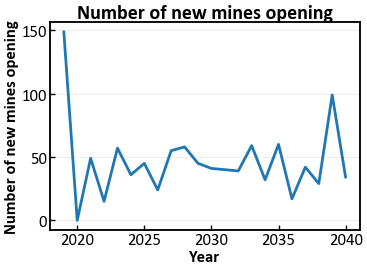

<Figure size 400x275 with 0 Axes>

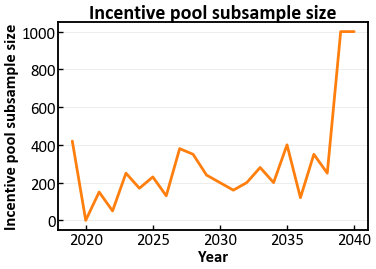

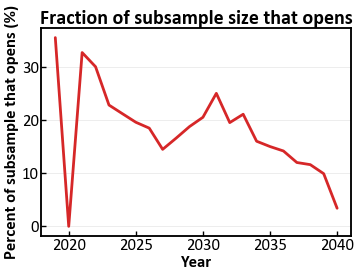

In [23]:
init_plot2(fontsize=24)
# fig,ax=plt.subplots()
new_mines.plot().grid(axis='x')
plt.title('Number of new mines opening')
plt.ylabel('Number of new mines opening')
plt.xlabel('Year')

plt.figure()
open_parameter.plot(legend=False,color='tab:orange').grid(axis='x')
plt.title('Incentive pool subsample size')
plt.ylabel('Incentive pool subsample size')
plt.xlabel('Year')

plt.figure()
(100*new_mines/open_parameter['Subsample size']).loc[2019:].fillna(0).plot(color='tab:red').grid(axis='x')
plt.title('Fraction of subsample size that opens')
plt.ylabel('Percent of subsample that opens (%)')
plt.xlabel('Year')

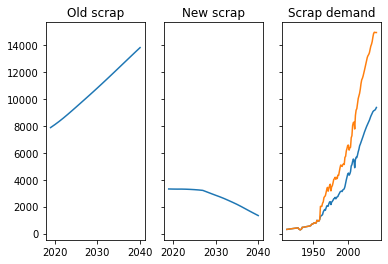

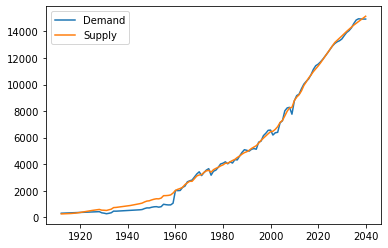

In [13]:
(demand_by_shape.loc[:,'Copper']*0.73+demand_by_shape.loc[:,'Wire'])/demand_by_shape.sum(axis=1)
# 0.73 copper is wire
fig,ax = plt.subplots(1,3,sharey=True)
waste_from_old_future.sum(axis=1).plot(ax=ax[0])
ax[0].set(title='Old scrap')

waste_from_new_future.sum(axis=1).plot(ax=ax[1])
ax[1].set(title='New scrap')

total_scrap_demand_all_life.loc[:, 'Direct melt scrap'].plot(ax=ax[2],label='Direct melt')
total_scrap_demand_all_life.sum(axis=1).plot(ax=ax[2],label='All')
ax[2].set(title='Scrap demand')

plt.figure()
total_scrap_demand_all_life.sum(axis=1).plot(label='Demand')
waste_all_life.sum(axis=1).plot(label='Supply')
plt.legend()

## Save results

In [25]:
prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})

mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
conc_demand_all.name='Concentrate demand'


ref_prod_df_history=\
historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
ref_prod_df_future.columns=ref_prod_df_history.columns
ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS'))
ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
ref_demand_all.name='Refined demand'


scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
scrap_supply.name='Scrap production'

scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')

sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)

mine_life_stats_all_tp=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1).transpose()

In [26]:
prices_simulated.to_excel('Data/scenario results/price baseline_prs10.xlsx')
sd_simulated.to_excel('Data/scenario results/S&D baseline_prs10.xlsx')
mine_life_stats_all_tp.to_excel('Data/scenario results/Mine level info/mine life baseline_prs10.xlsx')

## Price evolution

<IPython.core.display.Javascript object>


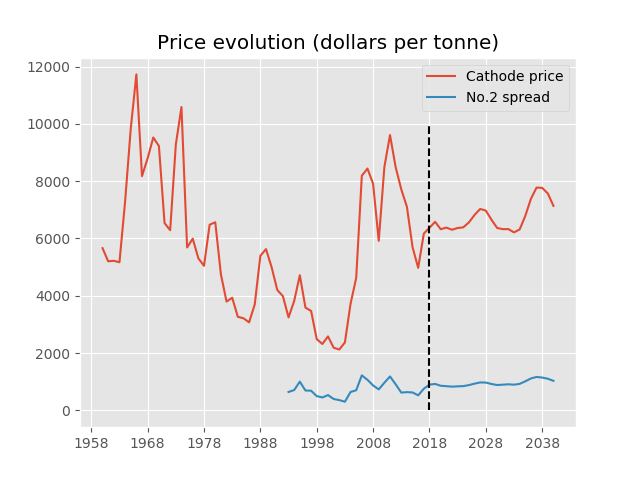

In [23]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(cathode_price_series, label='Cathode price')
plt.plot(sp2_series, label='No.2 spread')
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [0, 10000], 'k--')

plt.legend()
plt.title('Price evolution (dollars per tonne)')
plt.show()


In [24]:
# No.2 spread and cathode price correlation
print(sp2_series.diff().loc[:'20180101'].corr(cathode_price_series.diff().loc[:'20180101']))
print(sp2_series.diff().loc['20190101':].corr(cathode_price_series.diff().loc['20190101':]))

0.8490678763866732
0.9663652659910826


<IPython.core.display.Javascript object>


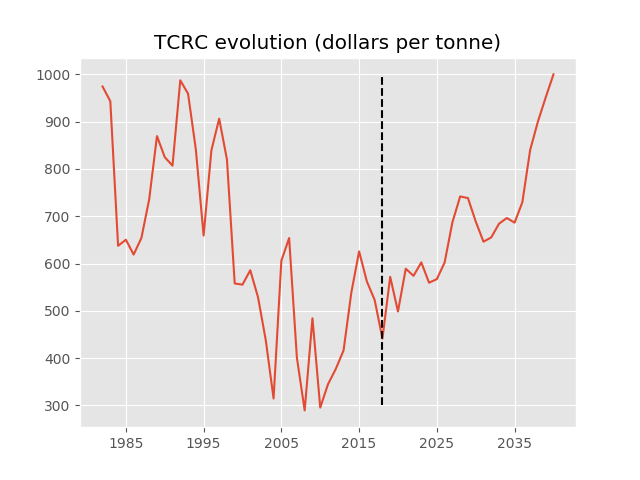

In [25]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(tcrc_series)
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [300, 1000], 'k--')
plt.title('TCRC evolution (dollars per tonne)')
plt.show()


## Supply and demand evolution

<IPython.core.display.Javascript object>


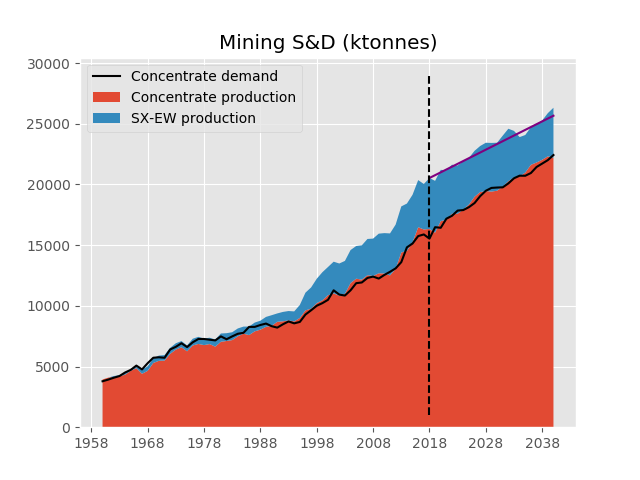

In [26]:
%matplotlib notebook
plt.stackplot(mining_prod_df_all.loc['19600101':, :].index, mining_prod_df_all.loc['19600101':, :].transpose(), 
              labels=mining_prod_df_all.columns)
plt.plot(conc_demand_all, 'k', label='Concentrate demand')
plt.plot([datetime(2018,1,1), datetime(2040,1,1)], [20531, 25662], 'purple')

plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [1000, 29000], 'k--')
plt.legend(loc=2)
plt.title('Mining S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


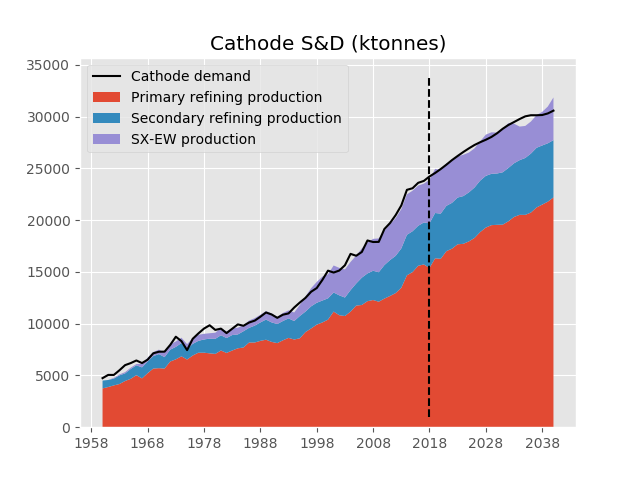

In [27]:
%matplotlib notebook
plt.stackplot(ref_prod_df_all.index, ref_prod_df_all.transpose(), 
              labels=ref_prod_df_all.columns)
plt.plot(ref_demand_all, 'k', label='Cathode demand')

plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [1000, 34000], 'k--')
plt.legend(loc=2)
plt.title('Cathode S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


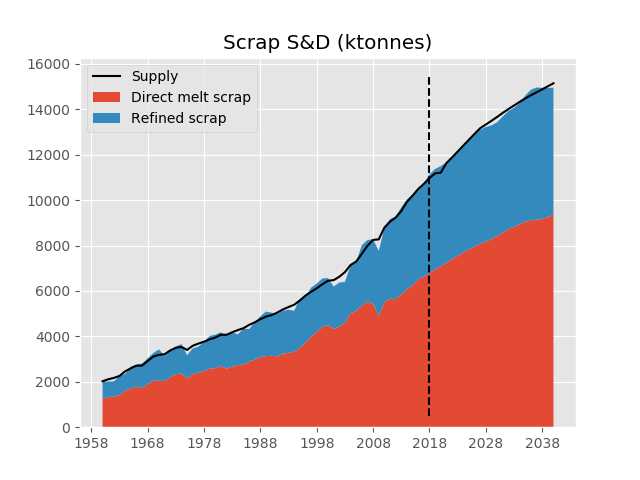

In [28]:
%matplotlib notebook
plt.plot(scrap_supply.loc['19600101':], 'k', label='Supply')
plt.stackplot(scrap_demand.loc['19600101':, :].index, scrap_demand.loc['19600101':, :].transpose(), 
              labels=scrap_demand.columns)

plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [500, 15500], 'k--')
plt.title('Scrap S&D (ktonnes)')
plt.legend()
plt.show()

## Ore grade evolution

In [33]:
def average_og_calculator(mine_life_panel_data):
    og_estimate=mine_life_panel_data.loc[:, idx[:, 'Ore treated (kt)']]\
    .mul(mine_life_panel_data.loc[:, idx[:, 'Head grade (%)']].values).div(1e2).sum(axis=1)\
    .div(mine_life_panel_data.loc[:, idx[:, 'Ore treated (kt)']].sum(axis=1)).mul(1e2)
    
    return og_estimate

In [30]:
og_history=pd.read_excel('Data/primary supply/Ore grade history.xls', sheet_name='Sheet1', index_col=0)
og_history_series=pd.Series(og_history.loc[:, 0].values, index=pd.date_range('19910101', '20180101', freq='AS'))

mine_life_stats_panel_all=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1)

In [34]:
og_future=average_og_calculator(mine_life_stats_panel_all)
og_future.loc['20180101']=og_history_series.loc['20180101']

<IPython.core.display.Javascript object>


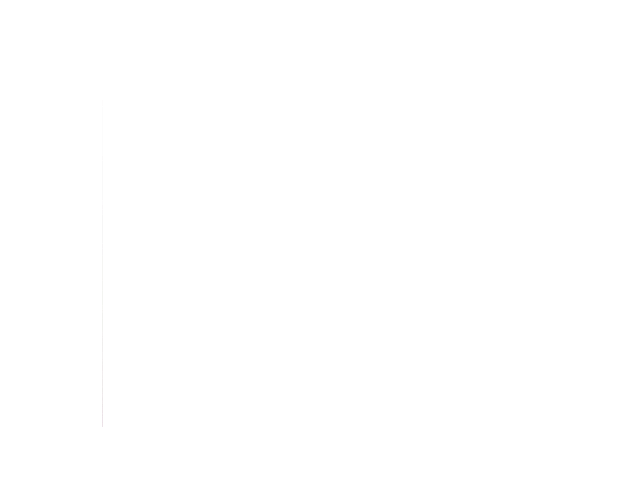

In [35]:
%matplotlib notebook
plt.plot(og_history_series, 'k', label='Historical ore grade')
plt.plot(og_future, 'k--', label='Future ore grade')

#plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [0.4, 0.7], 'k--')
plt.title('Ore grade in percentages')
#plt.legend()
plt.show()

In [32]:
scrap_demand.sum(axis=1)

1950-01-01      756.136390
1951-01-01      789.993244
1952-01-01      801.278861
1953-01-01      762.907761
1954-01-01      799.021738
                  ...     
2036-01-01    16263.860563
2037-01-01    16508.626204
2038-01-01    16605.245569
2039-01-01    16777.412372
2040-01-01    17324.674232
Freq: AS-JAN, Length: 91, dtype: float64

In [29]:
og_future

2018-01-01    0.540173
2019-01-01    0.529229
2020-01-01    0.511303
2021-01-01    0.492989
2022-01-01    0.480173
2023-01-01    0.465682
2024-01-01    0.458036
2025-01-01    0.448443
2026-01-01    0.439494
2027-01-01    0.430258
2028-01-01    0.421672
2029-01-01    0.413704
2030-01-01    0.406653
2031-01-01    0.403313
2032-01-01    0.400255
2033-01-01    0.393154
2034-01-01    0.390808
2035-01-01    0.390588
2036-01-01    0.386520
2037-01-01    0.381418
2038-01-01    0.378526
2039-01-01    0.379952
2040-01-01    0.381938
Freq: AS-JAN, dtype: float64

In [24]:
og_future

NameError: name 'og_future' is not defined

# Validation

In [193]:
cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                  cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)

### TCRC ###
conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)

### SP2 ###
scrap_bal_l1=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                              scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                              cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
        
prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})

mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
conc_demand_all.name='Concentrate demand'


ref_prod_df_history=\
historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
ref_prod_df_future.columns=ref_prod_df_history.columns
ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS'))
ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
ref_demand_all.name='Refined demand'


scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
scrap_supply.name='Scrap production'

scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')

sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)

mine_life_stats_all_tp=pd.concat([mine_life_stats_panel_operating, mine_life_stats_panel_new], axis=1).transpose()

## Prices

In [194]:
historical_prod
conc_demand = (historical_prod.loc[1950:,'Primary refining production']/0.99)
conc_demand.rename(dict(zip(conc_demand.index,[datetime(i,1,1) for i in conc_demand.index])),inplace=True)
conc_supply = historical_prod.loc[1950:,'Concentrate production']
conc_supply.rename(dict(zip(conc_supply.index,[datetime(i,1,1) for i in conc_supply.index])),inplace=True)

refined_demand = historical_prod.loc[1950:,'Refined usage']
refined_demand.rename(dict(zip(refined_demand.index,[datetime(i,1,1) for i in refined_demand.index])),inplace=True)
refined_supply = (historical_prod.loc[1950:,['SX-EW production','Primary refining production','Secondary refining production']].sum(axis=1)*0.99)
refined_supply.rename(dict(zip(refined_supply.index,[datetime(i,1,1) for i in refined_supply.index])),inplace=True)

scrap_demand = historical_prod.loc[1950:,['Direct melt','Secondary refining production']].sum(axis=1)
scrap_demand.rename(dict(zip(scrap_demand.index,[datetime(i,1,1) for i in scrap_demand.index])),inplace=True)
scrap_supply = waste_all_life.loc[1950:].sum(axis=1)
scrap_supply.rename(dict(zip(scrap_supply.index,[datetime(i,1,1) for i in scrap_supply.index])),inplace=True)


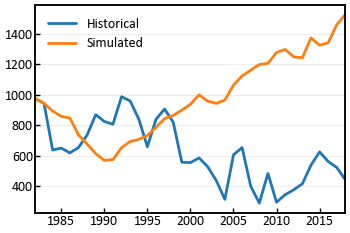

In [200]:
cathode_price_series
sp2_series
tcrc_series
tcrc_series_sim = tcrc_series.loc[:'20180101'].copy().dropna()
for i in np.arange(2,len(tcrc_series_sim.index)):
    t = tcrc_series_sim.index[i]
    t_lag_1 = tcrc_series_sim.index[i-1]
    conc_bal_l1 = conc_supply.loc[t_lag_1] - conc_demand.loc[t_lag_1]
    tcrc_series_sim.loc[t]=tcrc_predict(tcrc_series_sim.loc[t_lag_1], 
                                        conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)
    
tcrc_series.loc[:'20180101'].dropna().plot(label='Historical')
tcrc_series_sim.plot(label='Simulated').grid(axis='x')
plt.legend()

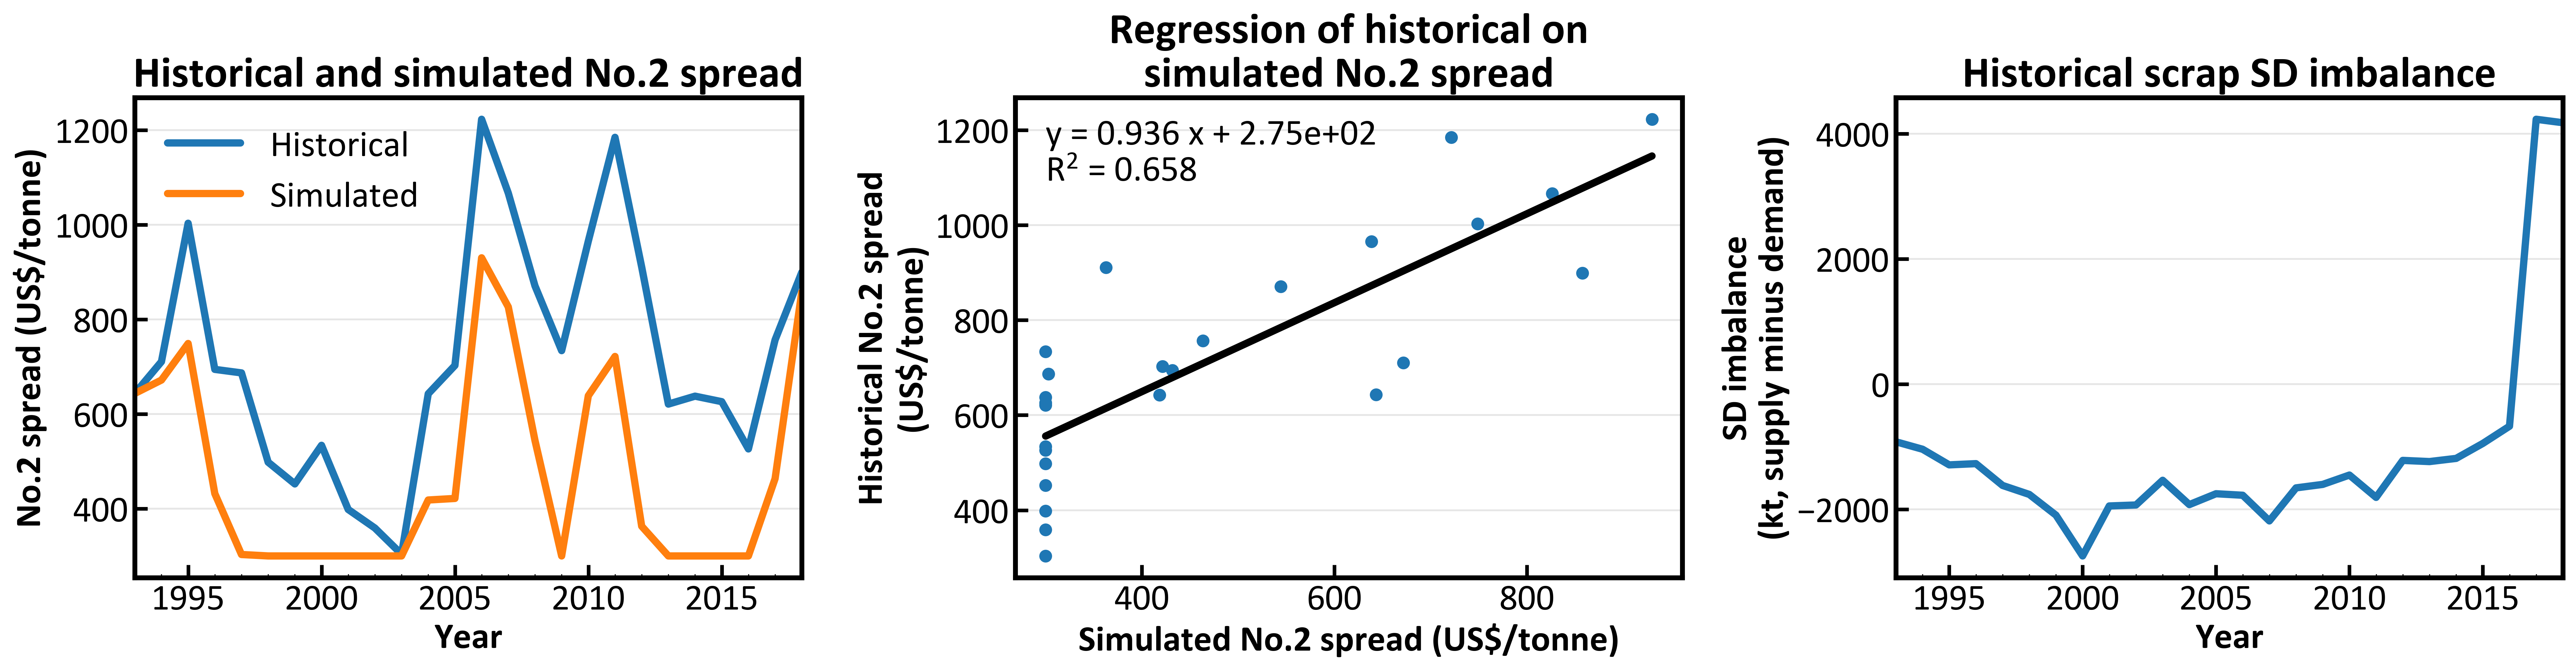

In [202]:
def sp2_predict(sp2_last, scrap_balance, scrap_sd_elas, cathode_diff, 
                cathode_sp2_elas):
    sp2_next=sp2_last+scrap_sd_elas*scrap_balance+cathode_sp2_elas*cathode_diff
    if sp2_next < 300:
        sp2_next=300
    elif sp2_next > 5000: # original: 1250, 5000 seems to work for 100% shocks
        sp2_next=5000
    return sp2_next

fig = plt.figure(figsize=(20,5.5),dpi=400)
ax = []
ax += [fig.add_subplot(1,3,1)]
ax += [fig.add_subplot(1,3,2)]
ax += [fig.add_subplot(1,3,3)]
sp2_series_sim = sp2_series.loc[:'20180101'].copy().dropna()
for i in np.arange(1,len(sp2_series_sim.index)):
    t = sp2_series_sim.index[i]
    t_lag_1 = sp2_series_sim.index[i-1]
    scrap_bal_l1 = scrap_supply.loc[t_lag_1] - scrap_demand.loc[t_lag_1]
    cathode_price_diff = cathode_price_series.loc[t] - cathode_price_series.loc[t_lag_1]
    sp2_series_sim.loc[t]=sp2_predict(sp2_series_sim.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
    
sp2_series.loc[:'20180101'].dropna().plot(label='Historical',ax=ax[0])
sp2_series_sim.plot(label='Simulated',ax=ax[0]).grid(axis='x')
ax[0].legend()

do_a_regress(sp2_series_sim,sp2_series.loc[:'20180101'].dropna(),ax=ax[1])

(scrap_supply-scrap_demand).loc['19930101':'20180101'].plot(ax=ax[2]).grid(axis='x')
ax[0].set(title='Historical and simulated No.2 spread',xlabel='Year',ylabel='No.2 spread (US$/tonne)')
ax[1].set(title='Regression of historical on\nsimulated No.2 spread',xlabel='Simulated No.2 spread (US$/tonne)',ylabel='Historical No.2 spread\n(US$/tonne)')
ax[2].set(title='Historical scrap SD imbalance',xlabel='Year',ylabel='SD imbalance\n(kt, supply minus demand)')
fig.tight_layout()

In [211]:
pd.concat([sp2_series,sp2_series_sim,(scrap_supply-scrap_demand).loc['19930101':'20180101']],axis=1,keys=['Historical','Simulated','Supply minus demand']).dropna()

Historical   Simulated  Supply minus demand
1993-01-01   643.426343  643.426343          -920.063471
1994-01-01   710.644403  671.752766         -1039.493918
1995-01-01  1003.161106  748.992474         -1289.215175
1996-01-01   694.318301  431.811094         -1269.747290
1997-01-01   686.879885  303.028772         -1617.898209
1998-01-01   498.086729  300.000000         -1761.149626
1999-01-01   452.201099  300.000000         -2092.097538
2000-01-01   533.808117  300.000000         -2743.897813
2001-01-01   398.224776  300.000000         -1945.472393
2002-01-01   358.969875  300.000000         -1930.033660
2003-01-01   303.660473  300.000000         -1535.533188
2004-01-01   642.780807  418.235800         -1923.949315
2005-01-01   702.623223  421.530677         -1750.388909
2006-01-01  1222.921211  930.097950         -1774.456543
2007-01-01  1066.917651  826.318476         -2184.385027
2008-01-01   870.858655  544.201641         -1656.782577
2009-01-01   733.937472  300.000000         -1601.246769
2010-01-01   965.477178  638.565098         -1451.922288
2011-01-01  1184.768258  721.601626         -1808.617831
2012-01-01   910.701978  362.835420         -1217.901092
2013-01-01   620.934693  300.000000         -1236.629057
2014-01-01   637.691751  300.000000         -1185.878938
2015-01-01   626.084731  300.000000          -946.968784
2016-01-01   526.182350  300.000000          -671.850282
2017-01-01   756.628960  463.412594          4230.712796
2018-01-01   899.365830  857.693346          4175.681499

59


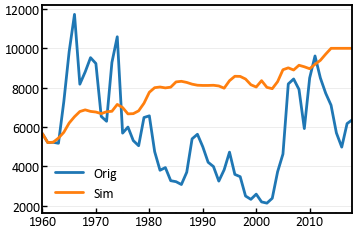

In [203]:
cathode_price_series
tcrc_series
sp2_series
cathode_price_series_sim = cathode_price_series.loc[:'20180101'].copy().dropna()
print(len(cathode_price_series_sim.index))
for i in np.arange(3,len(cathode_price_series_sim.index)):
    t = cathode_price_series_sim.index[i]
    t_lag_1 = cathode_price_series_sim.index[i-1]
    cathode_bal_l1 = refined_supply.loc[t_lag_1] - refined_demand.loc[t_lag_1]
    cathode_price_series_sim.loc[t]=cathode_price_predict(cathode_price_series_sim.loc[t_lag_1], 
                                          cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)
    
cathode_price_series.loc[:'20180101'].dropna().plot(label='Orig')
cathode_price_series_sim.plot(label='Sim').grid(axis='x')
plt.legend()


## Refineries

In [83]:
%store -r ref_stats_hist
# ref_stats_hist.rename(dict(zip(ref_stats_hist.index,[datetime(i,1,1) for i in ref_stats_hist.index])),inplace=True)
ref_stats_hist.dropna(axis=0,inplace=True)

In [92]:
ref_stats_next

Primary CU                  0.842625
Secondary CU                0.793501
Secondary ratio                  NaN
Primary capacity        21855.045716
Secondary capacity       5982.889460
Primary production               NaN
Secondary production             NaN
dtype: float64

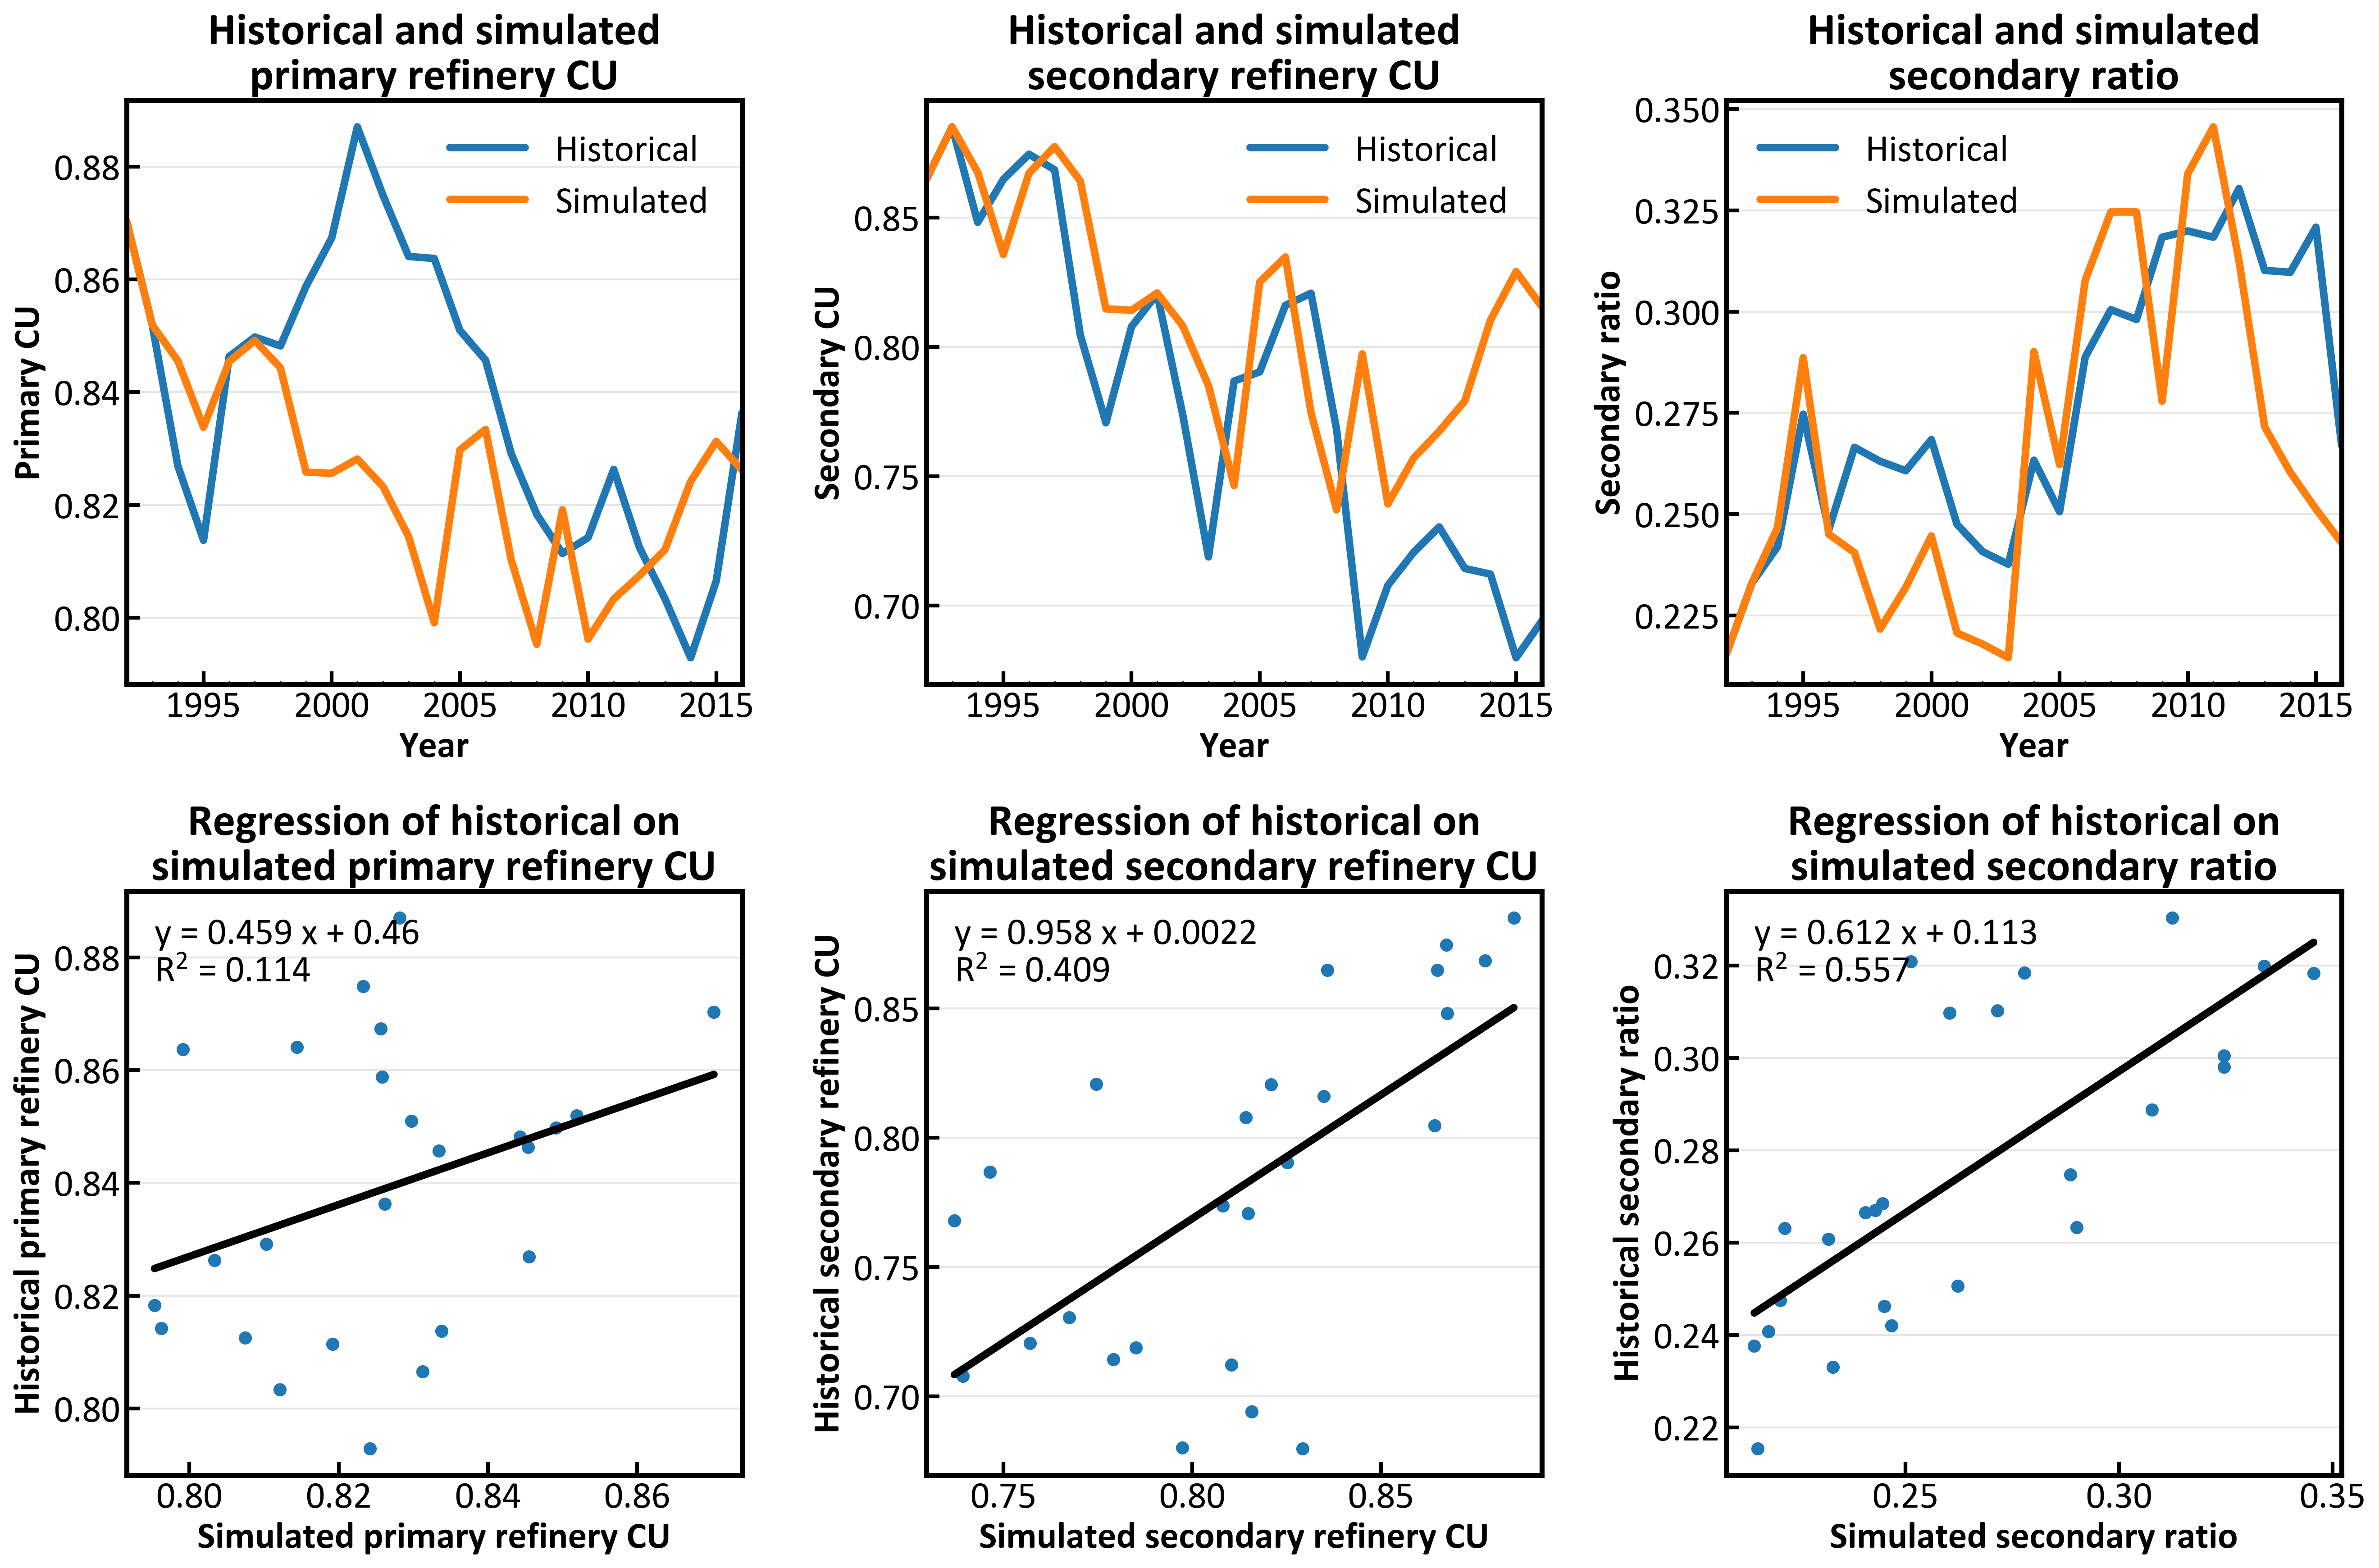

In [204]:
scrap_supply1 = scrap_supply.rename(dict(zip(scrap_supply.index,[int(str(i)[:4]) for i in scrap_supply.index])))
# ref_stats_next=
ref_stats_hist_sim = ref_stats_hist.copy()
for i in ref_stats_hist_sim.index[2:]:
    year_i = int(str(i)[:4])
    ref_stats_next = simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                            refined_demand, scrap_supply1,
                                                            ref_stats_hist_sim, ref_hyper_param, growth_lag=1)
    ref_stats_hist_sim.loc[i] = ref_stats_next

fig=plt.figure(figsize=(18,12),dpi=300)
ax = []
ax += [fig.add_subplot(2,3,1)]
ax += [fig.add_subplot(2,3,2)]
ax += [fig.add_subplot(2,3,3)]
ax += [fig.add_subplot(2,3,4)]
ax += [fig.add_subplot(2,3,5)]
ax += [fig.add_subplot(2,3,6)]
n = 0
for i in ref_stats_hist.columns[:3]:
    ref_stats_hist[i].plot(label='Historical',ax=ax[n])
    ref_stats_hist_sim[i].plot(label='Simulated',ax=ax[n]).grid(axis='x')
    ax[n].set(title='Historical and simulated\n'+i.lower().replace('cu','CU').replace('primary','primary refinery').replace('secondary CU','secondary refinery CU'),
             xlabel='Year',ylabel=i)
    ax[n].legend()
    n += 3
    do_a_regress(ref_stats_hist_sim[i],ref_stats_hist[i],ax=ax[n],intercept=True)
    ax[n].set(title='Regression of historical on\nsimulated '+i.lower().replace('cu','CU').replace('primary','primary refinery').replace('secondary CU','secondary refinery CU'),
             ylabel='Historical '+i.lower().replace('cu','CU').replace('primary','primary refinery').replace('secondary CU','secondary refinery CU'),
             xlabel='Simulated '+i.lower().replace('cu','CU').replace('primary','primary refinery').replace('secondary CU','secondary refinery CU'))
    n -= 2
    fig.tight_layout()

In [209]:
pd.concat([ref_stats_hist[ref_stats_hist.columns[:3]],ref_stats_hist_sim[ref_stats_hist.columns[:3]]],axis=1,keys=['Historical','Simulated'])

Historical                               Simulated               \
           Primary CU Secondary CU Secondary ratio Primary CU Secondary CU   
1992-01-01   0.870325     0.864858        0.215409   0.870325     0.864858   
1993-01-01   0.851936     0.885122        0.233008   0.851936     0.885122   
1994-01-01   0.826923     0.848182        0.241982   0.845547     0.867560   
1995-01-01   0.813746     0.864820        0.274677   0.833789     0.835810   
1996-01-01   0.846328     0.874539        0.246219   0.845426     0.867230   
1997-01-01   0.849785     0.868515        0.266501   0.849171     0.877495   
1998-01-01   0.848212     0.804689        0.263049   0.844318     0.864206   
1999-01-01   0.858791     0.770695        0.260724   0.825843     0.814774   
2000-01-01   0.867336     0.807883        0.268416   0.825627     0.814207   
2001-01-01   0.887038     0.820527        0.247492   0.828166     0.820890   
2002-01-01   0.874899     0.773663        0.240743   0.823295     0.808097   
2003-01-01   0.864068     0.718852        0.237661   0.814409     0.785086   
2004-01-01   0.863705     0.786853        0.263320   0.799128     0.746476   
2005-01-01   0.850967     0.790385        0.250614   0.829766     0.825118   
2006-01-01   0.845684     0.816091        0.288792   0.833412     0.834805   
2007-01-01   0.829153     0.820790        0.300469   0.810321     0.774636   
2008-01-01   0.818341     0.768036        0.298059   0.795323     0.737051   
2009-01-01   0.811424     0.680198        0.318363   0.819164     0.797348   
2010-01-01   0.814216     0.707888        0.319901   0.796241     0.739318   
2011-01-01   0.826318     0.720574        0.318352   0.803351     0.757024   
2012-01-01   0.812536     0.730438        0.330357   0.807482     0.767433   
2013-01-01   0.803386     0.714375        0.310173   0.812091     0.779148   
2014-01-01   0.792932     0.712194        0.309700   0.824173     0.810393   
2015-01-01   0.806544     0.679860        0.320819   0.831295     0.829172   
2016-01-01   0.836295     0.694029        0.266997   0.826201     0.815713   

                            
           Secondary ratio  
1992-01-01        0.215409  
1993-01-01        0.233008  
1994-01-01        0.246724  
1995-01-01        0.288631  
1996-01-01        0.245041  
1997-01-01        0.240533  
1998-01-01        0.221643  
1999-01-01        0.231937  
2000-01-01        0.244628  
2001-01-01        0.220677  
2002-01-01        0.217932  
2003-01-01        0.214560  
2004-01-01        0.290125  
2005-01-01        0.262258  
2006-01-01        0.307734  
2007-01-01        0.324588  
2008-01-01        0.324587  
2009-01-01        0.277887  
2010-01-01        0.334006  
2011-01-01        0.345597  
2012-01-01        0.312505  
2013-01-01        0.271562  
2014-01-01        0.260323  
2015-01-01        0.251289  
2016-01-01        0.242940

<AxesSubplot:>

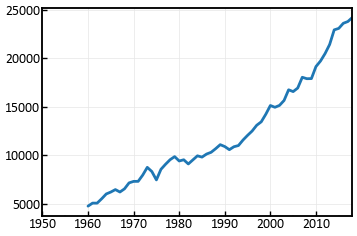

In [206]:
# historical_prod.loc[:,'Primary refining production'].rename(dict(zip(historical_prod.index,[datetime(i,1,1) for i in historical_prod.index]))).plot()
# ref_stats_hist.loc[:,'Primary production'].plot()
refined_demand.plot()

## Mining

In [191]:
def simulate_mine_life(simulation_time, price_series, tcrc_cpp_series, 
                       hyper_param, mine_data, og_elas, 
                       close_price_method='max', close_years_back=5):
    # Read mine specific data
    tonne_to_lbs = 2204.62
    ore_cap_kt = mine_data.loc['Ore capacity (kt)']
    cum_ore_prod_kt = mine_data.loc['Cumulative ore treated (kt)']
    og_current_percent = mine_data.loc['Head grade (%)']
    recovery_percent = mine_data.loc['Recovery rate (%)']
    paid_percent = mine_data.loc['Payable percent (%)']

    minesite_cost_cpp = mine_data.loc['Minesite cost (cents/lb)']
    freight_cpp = mine_data.loc['Transport and offsite (cents/lb)']
    royalty_cpp = mine_data.loc['Royalty (cents/lb)']
    overhead_dollar_annual = mine_data.loc['Overhead cost ($, annual)']
    sustain_dollar_annual = mine_data.loc['Sustaining capex ($, annual)']
    reclamation_dollar = mine_data.loc['Reclamation ($)']
    cash_flow_2018_dollar = mine_data.loc['Cash flow 2018 ($)']
    
    # For minesite, the constant cost is based on per tonne of ore rather than metal
    minesite_cost_pto = minesite_cost_cpp*tonne_to_lbs/(1e2)*og_current_percent/(1e2)*recovery_percent/(1e2)*paid_percent/(1e2)
    
    # Read Hyper-parameters
    cap_uti_base = hyper_param.loc['Capacity utilization constant', 'Value']
    tcm_base = hyper_param.loc['Total cash margin constant ($/tonne)', 'Value']
    prod_elas = hyper_param.loc['Production elasticity', 'Value']
    discount = hyper_param.loc['Discount rate', 'Value']
    
    # Initiation
    n_years = simulation_time.shape[0]
    mine_life_stats = pd.DataFrame(index=simulation_time, columns=['Head grade (%)', 'Ore treated (kt)', 
                                                                   'Recovered metal production (kt)',
                                                                   'Paid metal production (kt)', 
                                                                   'Total cash margin ($/tonne paid metal)', 
                                                                   'Pre-tax cash flow ($)'])
    if cum_ore_prod_kt == 0:
        og_init_percent = og_current_percent
    else:
        og_init_percent = og_current_percent/(cum_ore_prod_kt/ore_cap_kt)**og_elas
    
    # Simulate over life of mine, year i=0 is 2018
    for i in range(n_years):
        t = simulation_time[i]
        price_t = price_series.loc[t]
#         if t == datetime(2018,1,1):
        tcrc_cpp = mine_data.loc['TCRC (cents/lb)']
#         else:
#             tcrc_cpp = tcrc_cpp_series[t]
        
        # If no ore production before, then this first year is a ramp up. Otherwise, if cashflow<0, assume this is ramp down.
        if cum_ore_prod_kt == 0:
            ramp_up_flag=True
            ramp_down_flag=False
        elif cash_flow_2018_dollar < 0 and i == 0:
            ramp_up_flag=False
            ramp_down_flag=True
        else:
            ramp_up_flag=False
            ramp_down_flag=False
                
        # Calculate ore grade
        if i == 0:
            og_percent = og_current_percent
        else:
            og_percent = og_init_percent * (cum_ore_prod_kt/ore_cap_kt+0.84)**og_elas 
            # 0.84 is the first order approx of last year cap uti

        
        # Calculate total cash margin and cash flow under the normal scenario
        ramp_flag=ramp_up_flag or ramp_down_flag
        tot_cash_margin = tot_cash_margin_cal(price_t, minesite_cost_pto, og_percent, recovery_percent, paid_percent, 
                                              tcrc_cpp, freight_cpp, royalty_cpp)
        ore_prod_kt=ore_prod_calculator(ore_cap_kt, cap_uti_base, tot_cash_margin, tcm_base, prod_elas, ramp_flag)
        recovered_metal_prod_kt = ore_prod_kt * og_percent * recovery_percent / (1e4)
        paid_metal_prod_kt = recovered_metal_prod_kt * paid_percent / (1e2)
        cash_flow_dollar = tot_cash_margin * paid_metal_prod_kt * (1e3) - overhead_dollar_annual - sustain_dollar_annual
        # Reminder: it is possible to have a negative cash flow during ramp up

        mine_life_stats.loc[t, 'Head grade (%)'] = og_percent
        mine_life_stats.loc[t, 'Total cash margin ($/tonne paid metal)'] = tot_cash_margin


        # If closing already determined at this point (ramp_down_flag=True), execute closing produciton
        if ramp_down_flag:
            # This year at 40% cap uti
            mine_life_stats.loc[t, 'Ore treated (kt)'] = ore_prod_kt
            mine_life_stats.loc[t, 'Paid metal production (kt)'] = paid_metal_prod_kt
            mine_life_stats.loc[t, 'Recovered metal production (kt)'] = recovered_metal_prod_kt
            mine_life_stats.loc[t, 'Pre-tax cash flow ($)'] = cash_flow_dollar
            
            # Next year incurring reclamation
            t_plus_1=t+relativedelta(years=1)
            mine_life_stats.loc[t_plus_1, 'Ore treated (kt)'] = 0
            mine_life_stats.loc[t_plus_1, 'Paid metal production (kt)'] = 0
            mine_life_stats.loc[t_plus_1, 'Recovered metal production (kt)'] = 0
            mine_life_stats.loc[t_plus_1, 'Pre-tax cash flow ($)'] = -reclamation_dollar
            break
            
        # If not closing not determined yet, calculate cashflow under expected price, not assuming ramp down yet. If this cash
        # flow turns out to be negative, begin to calculate the ramp down cash flow
        else:
            # Expected price: assume miners look back on historical price as well, use trailing price (3 years trailing for now)
            if close_price_method=='mean':
                price_expect = price_series.rolling(close_years_back).mean().loc[t]
            elif close_price_method=='max':
                t_back=t-relativedelta(years=close_years_back-1)
                price_expect = price_series.loc[t_back:t].max()
                
            tot_cash_margin_expect = tot_cash_margin_cal(price_expect, minesite_cost_pto, og_percent, recovery_percent, 
                                                         paid_percent, tcrc_cpp, freight_cpp, royalty_cpp)            
            ore_prod_kt_expect=ore_prod_calculator(ore_cap_kt, cap_uti_base, tot_cash_margin_expect, tcm_base, prod_elas, 
                                                   ramp_flag=False)
            recovered_metal_prod_kt_expect = ore_prod_kt_expect * og_percent * recovery_percent / (1e4)
            paid_metal_prod_kt_expect = recovered_metal_prod_kt_expect * paid_percent / (1e2)
            cash_flow_dollar_expect = tot_cash_margin_expect * paid_metal_prod_kt_expect * (1e3) \
            - overhead_dollar_annual - sustain_dollar_annual

        # If cash flow expected is negative, determine if mine should incur ramp down this year and reclamation next year, 
        # based on max NPV
        if cash_flow_dollar_expect < 0 and not ramp_up_flag:
            ### Scenario 1: ramp down this year, reclaim the next ###
            ore_prod_kt_ramp_down_this=ore_prod_calculator(ore_cap_kt, cap_uti_base, tot_cash_margin_expect, 
                                                           tcm_base, prod_elas, ramp_flag=True)
            og_percent_ramp_down_this=og_init_percent * (cum_ore_prod_kt/ore_cap_kt+0.4)**og_elas
            recovered_metal_prod_kt_ramp_down_this = ore_prod_kt_ramp_down_this * og_percent_ramp_down_this * recovery_percent \
            / (1e4)
            paid_metal_prod_kt_ramp_down_this = recovered_metal_prod_kt_ramp_down_this * paid_percent / (1e2)
            cash_flow_dollar_ramp_down_this = tot_cash_margin_expect * paid_metal_prod_kt_ramp_down_this * (1e3) \
            - overhead_dollar_annual - sustain_dollar_annual
            npv_close_this_year = cash_flow_dollar_ramp_down_this - reclamation_dollar/(1+discount)

            ### Scenario 2: continue operation this year, ramp down next year, reclaim two years from now ###
            ore_prod_kt_ramp_down_next=ore_prod_calculator(ore_cap_kt, cap_uti_base, tot_cash_margin_expect, 
                                                           tcm_base, prod_elas, ramp_flag=True)
            og_percent_ramp_down_next=og_init_percent * (cum_ore_prod_kt/ore_cap_kt+0.75+0.4)**og_elas
            recovered_metal_prod_kt_ramp_down_next = ore_prod_kt_ramp_down_next * og_percent_ramp_down_next * recovery_percent \
            / (1e4)
            paid_metal_prod_kt_ramp_down_next = recovered_metal_prod_kt_ramp_down_next * paid_percent / (1e2)
            cash_flow_dollar_ramp_down_next = tot_cash_margin_expect * paid_metal_prod_kt_ramp_down_next * (1e3) \
            - overhead_dollar_annual - sustain_dollar_annual
            npv_close_next_year = cash_flow_dollar_expect + cash_flow_dollar_ramp_down_next/(1+discount)\
            - reclamation_dollar/(1+discount)**2
            
            if npv_close_this_year > npv_close_next_year:
                # This year at 40% cap uti
                mine_life_stats.loc[t, 'Ore treated (kt)'] = ore_prod_kt_ramp_down_this
                mine_life_stats.loc[t, 'Paid metal production (kt)'] = paid_metal_prod_kt_ramp_down_this
                mine_life_stats.loc[t, 'Recovered metal production (kt)'] = recovered_metal_prod_kt_ramp_down_this
                mine_life_stats.loc[t, 'Pre-tax cash flow ($)'] = cash_flow_dollar_ramp_down_this

                # Next year incurring reclamation
                t_plus_1=t+relativedelta(years=1)
                mine_life_stats.loc[t_plus_1, 'Ore treated (kt)'] = 0
                mine_life_stats.loc[t_plus_1, 'Paid metal production (kt)'] = 0
                mine_life_stats.loc[t_plus_1, 'Recovered metal production (kt)'] = 0
                mine_life_stats.loc[t_plus_1, 'Pre-tax cash flow ($)'] = -reclamation_dollar
                break

        mine_life_stats.loc[t, 'Ore treated (kt)'] = ore_prod_kt
        mine_life_stats.loc[t, 'Paid metal production (kt)'] = paid_metal_prod_kt
        mine_life_stats.loc[t, 'Recovered metal production (kt)'] = recovered_metal_prod_kt
        mine_life_stats.loc[t, 'Pre-tax cash flow ($)'] = cash_flow_dollar

        cum_ore_prod_kt += ore_prod_kt
    
    return mine_life_stats

In [192]:
hist_sim_time = pd.date_range('20000101','20180101',freq='AS')
mine_life_stats_panel_operating_hist = mine_life_stats_panel_init(hist_sim_time, operating_mine_pool)

for year_i in np.arange(2000,2019):
    print(year_i)
    for mine_id in operating_mine_pool.index:
        mine_data = operating_mine_pool.loc[mine_id]
        mine_life_stats = simulate_mine_life_stats_panel(hist_sim_time, year_i, 2000, 
                                                         mine_life_stats_panel_operating_hist, mine_data, 
                                                         cathode_price_series, tcrc_cpp_series, pri_hyper_param)
        mine_life_stats_panel_operating_hist.loc[:, idx[mine_id, :]]=mine_life_stats.loc[hist_sim_time, :].values


2000


KeyboardInterrupt: 

In [184]:
mine_life_stats_panel_operating_hist.loc[:,idx[:,'Recovered metal production (kt)']].sum(axis=1)
# mine_life_stats_panel_operating_hist.columns.levels[1]

2000-01-01    12621.415934
2001-01-01     5267.953777
2002-01-01     1818.570952
2003-01-01        5.074692
2004-01-01        5.111332
2005-01-01        4.924008
2006-01-01        4.835240
2007-01-01        4.656257
2008-01-01        4.477882
2009-01-01        4.270740
2010-01-01        0.000000
2011-01-01        0.000000
2012-01-01        0.000000
2013-01-01        0.000000
2014-01-01        0.000000
2015-01-01        0.000000
2016-01-01        0.000000
2017-01-01        0.000000
2018-01-01        0.000000
Freq: AS-JAN, dtype: float64

In [185]:
mine_data
operating_mine_pool

Ore capacity (kt)  Ore treated (kt)  Cumulative ore treated (kt)  \
80820             649.999862        260.000000                   430.000000   
27291           39937.362631      35328.000000                616303.574219   
28811           23267.793969      20580.000000                  4265.000000   
81253             175.770300        148.500000                   297.000000   
26483            1143.892729       1000.080017                  7752.619079   
...                      ...               ...                          ...   
29365_dup         496.271508        435.000000                   950.000000   
81258_dup         175.000000         70.000000                   120.000000   
27495_dup       36811.718199      32000.000000                579300.400391   
36767_dup         937.500000        375.000000                   771.000000   
27653_dup       16932.869252      14800.000000                239168.732910   

           Head grade (%)  Recovery rate (%)  Recovered metal production (kt)  \
80820            0.441600          82.000000                         0.941491   
27291            0.317858          95.202896                       106.905998   
28811            0.620000          80.000000                       102.076797   
81253            0.207000          85.000000                         0.261286   
26483            2.250000          79.993599                        18.000000   
...                   ...                ...                              ...   
29365_dup        0.900000          85.000000                         3.327750   
81258_dup        0.420000          77.000000                         0.226380   
27495_dup        0.536000          86.000000                       147.507202   
36767_dup        0.640000          85.000000                         2.040000   
27653_dup        0.480000          83.000000                        58.963200   

           Payable percent (%)  Paid metal production (kt)  \
80820                97.000000                    0.913246   
27291                97.000000                  103.698822   
28811                97.000000                   99.014496   
81253                97.000000                    0.253447   
26483                96.000000                   17.280001   
...                        ...                         ...   
29365_dup            97.000000                    3.227917   
81258_dup            97.000000                    0.219589   
27495_dup            95.416664                  140.746460   
36767_dup            97.000000                    1.978800   
27653_dup            95.000000                   56.015041   

           Minesite cost (cents/lb)  Transport and offsite (cents/lb)  ...  \
80820                    203.422256                          9.616452  ...   
27291                     77.161728                          4.917267  ...   
28811                     31.420416                         34.678505  ...   
81253                    147.535126                         30.277929  ...   
26483                    141.340149                          8.879767  ...   
...                             ...                               ...  ...   
29365_dup                 92.802437                          6.774909  ...   
81258_dup                257.508789                          4.401599  ...   
27495_dup                 87.158661                         41.261982  ...   
36767_dup                205.317703                          3.375463  ...   
27653_dup                126.492516                         20.191711  ...   

           Overhead cost ($, annual)  Sustaining capex ($, annual)  \
80820                   3.523983e+05                  3.291446e+05   
27291                   1.070341e+07                  9.264353e+07   
28811                   3.958775e+07                  3.888555e+07   
81253                   8.201570e+04                  5.047120e+04   
26483                   0.000000e+00                  0.0